# logo_UC3M.png

# UC3M Big Data Final Challenge

## Team 3
- Daniel Morán
- Marcos Santiago
- Montserrat Rodríguez-Pina
- Fernando Alfayate
- Rafael Madorrán
- Pablo Vicente

## Project Overview
- This notebook analyzes over 300,000 Airbnb listings in Madrid and Barcelona to identify
pricing, occupancy and satisfaction drivers using statistical analysis and NLP techniques.
- **Objective:** Equip investors with evidence-based guidance on pricing, demand, host practices, and neighborhood positioning using >300k listings, >1M reviews, and calendar records for both cities.

## Why This Matters
- Leisure travel surpasses $4.7T globally; platforms like Airbnb are still gaining share.
- Dense marketplaces with millions of hosts and tenants are perfect playgrounds for advanced analytics, descriptive storytelling, and predictive modeling.

## Core Questions We Answer
1. **Market Dynamics:** How do property types, hosts, reviews, and locations interact across Madrid and Barcelona?
2. **Value Extraction:** Which cleaning, feature engineering, and segmentation steps actually move the needle?
3. **Performance Drivers:** What differentiates premium listings from average ones (pricing power, host traits, review tone, amenity mix)?
4. **Actionable Insights:** Where should an investor deploy capital, what supply gaps exist, and which levers (price/occupancy/experience) change outcomes fastest?
5. **Modeling:** When should we rely on descriptive views, statistical tests, or predictive models such as Random Forests for price and price-per-person?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading & Global Pre-processing

**To run this notebook in Google Colab:**

1. **Upload your data folder**: Upload the `Airbnb 3` folder (containing `Barcelona` and `Madrid` subfolders) to your Google Drive root directory.

2. **Run the Drive mount cell below**: When you execute the cell that mounts Google Drive, you'll be asked to authorize access. Click the link and grant permissions.

3. **Data location**: The notebook expects data at `/content/drive/MyDrive/Airbnb 3/`. If your data is in a different location, update the `COLAB_BASE_PATH` variable in the path configuration cell.

4. **Execute cells in order**: Run all cells sequentially from top to bottom.

In [ ]:
# Google Drive mount for Colab
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set modern visual style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.size'] = 11

# Define consistent color scheme
COLORS = {
    'madrid': '#E63946',      # Vibrant red
    'barcelona': '#457B9D',   # Ocean blue
    'accent': '#F77F00',      # Orange
    'success': '#06D6A0',     # Teal
    'neutral': '#6C757D'      # Gray
}

## Visualization Helper Functions

Define reusable functions for consistent styling across all visualizations.

In [ ]:
def style_axis(ax, title, xlabel, ylabel, grid=True):
    """Apply consistent styling to matplotlib axis"""
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    if grid:
        ax.grid(True, alpha=0.3, linestyle='--')
    return ax

def format_currency(x, p):
    """Format numbers as currency with thousands separator"""
    return f'€{int(x):,}'

def add_value_labels(ax, orientation='v', format_fn=None):
    """Add value labels to bar plots"""
    for container in ax.containers:
        if format_fn:
            labels = [format_fn(v.get_height() if orientation == 'v' else v.get_width())
                     for v in container]
        else:
            labels = [f'{int(v.get_height() if orientation == "v" else v.get_width()):,}'
                     for v in container]
        if orientation == 'v':
            ax.bar_label(container, labels=labels, padding=3, fontsize=10, fontweight='bold')
        else:
            ax.bar_label(container, labels=labels, padding=3, fontsize=10, fontweight='bold')
    return ax

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [ ]:
# === PATH CONFIGURATION ===
# Google Colab path, assumes 'Airbnb 3' folder is in Drive root
# If you placed it elsewhere, update this path:
base_path = "/content/drive/MyDrive/Airbnb 3"

# Define file paths, using .gz files where they exist
paths = {
    'barcelona_listings': f"{base_path}/Barcelona/listings.csv.gz",
    'barcelona_reviews': f"{base_path}/Barcelona/reviews.csv.gz",
    'barcelona_calendar': f"{base_path}/Barcelona/calendar.csv.gz",
    'madrid_listings': f"{base_path}/Madrid/listings.csv.gz",
    'madrid_reviews': f"{base_path}/Madrid/reviews.csv.gz",
    'madrid_calendar': f"{base_path}/Madrid/calendar.csv.gz",
}

print(f"✓ Paths configured: {base_path}")

✓ Paths configured: /content/drive/MyDrive/Airbnb 3


In [ ]:
# Load datasets,  pandas automatically handles .gz compression

print("Loading data...")
madrid_calendar_data = pd.read_csv(paths['madrid_calendar'], compression='gzip')
barcelona_calendar_data = pd.read_csv(paths['barcelona_calendar'], compression='gzip')
barcelona_reviews_data = pd.read_csv(paths['barcelona_reviews'], compression='gzip')
madrid_reviews_data = pd.read_csv(paths['madrid_reviews'], compression='gzip')
barcelona_listings = pd.read_csv(paths['barcelona_listings'], compression='gzip')
madrid_listings = pd.read_csv(paths['madrid_listings'], compression='gzip')

if 'id' not in madrid_listings.columns:
    if 'listings.csv' in madrid_listings.columns:
        print("Correcting 'id' column for Madrid listings...")
        madrid_listings['id'] = madrid_listings['listings.csv'].astype(float)
        madrid_listings = madrid_listings.drop(columns=['listings.csv'])
        print("'id' column corrected for Madrid listings.")
    else:
        raise ValueError("Madrid listings file has neither 'id' nor 'listings.csv' columns.")

print("✓ Data loaded successfully")

Loading data...
Correcting 'id' column for Madrid listings...
'id' column corrected for Madrid listings.
✓ Data loaded successfully


In [ ]:
# Add city labels to each dataset
barcelona_listings['City'] = 'Barcelona'
madrid_listings['City'] = 'Madrid'
madrid_calendar_data['City'] = 'Madrid'
barcelona_calendar_data['City'] = 'Barcelona'
madrid_reviews_data['City'] = 'Madrid'
barcelona_reviews_data['City'] = 'Barcelona'

# Combine datasets
combined_listings = pd.concat([barcelona_listings, madrid_listings], ignore_index=True)
combined_reviews = pd.concat([barcelona_reviews_data, madrid_reviews_data], ignore_index=True)
combined_calendar = pd.concat([barcelona_calendar_data, madrid_calendar_data], ignore_index=True)

print(f"✓ Combined {len(combined_listings):,} listings")
print(f"✓ Combined {len(combined_reviews):,} reviews")
print(f"✓ Combined {len(combined_calendar):,} calendar entries")

✓ Combined 44,411 listings
✓ Combined 2,295,262 reviews
✓ Combined 16,209,661 calendar entries


In [ ]:
combined_calendar['date'] = pd.to_datetime(combined_calendar['date'])
if combined_calendar['price'].dtype == 'object':
    combined_calendar['price'] = combined_calendar['price'].str.replace('$', '').str.replace(',', '').astype(float)
combined_calendar['month'] = combined_calendar['date'].dt.month
combined_calendar['year'] = combined_calendar['date'].dt.year
if combined_listings['price'].dtype == 'object':
    combined_listings['price'] = combined_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)
combined_listings['date'] = pd.to_datetime(combined_calendar['date'])
combined_listings['month'] = combined_calendar['date'].dt.month
combined_listings['year'] = combined_calendar['date'].dt.year
if combined_reviews['date'].dtype == 'object':
    combined_reviews['date'] = pd.to_datetime(combined_reviews['date'])
combined_reviews['month'] = combined_reviews['date'].dt.month
combined_reviews['year'] = combined_reviews['date'].dt.year

In [ ]:
# Load Barcelona neighborhood data
barcelona_neighbourhoods_csv_path = f"{base_path}/Barcelona/neighbourhoods.csv"
barcelona_neighbourhoods_geojson_path = f"{base_path}/Barcelona/neighbourhoods.geojson"

# Load data into DataFrames
barcelona_neighbourhoods_data = pd.read_csv(barcelona_neighbourhoods_csv_path)
import geopandas as gpd  # Import geopandas for geojson
barcelona_neighbourhoods_geo = gpd.read_file(barcelona_neighbourhoods_geojson_path)

# Display first few rows for verification
display(barcelona_neighbourhoods_data.head())
display(barcelona_neighbourhoods_geo.head())

neighbourhood_group                          neighbourhood
0        Ciutat Vella                         el Barri Gòtic
1        Ciutat Vella                               el Raval
2        Ciutat Vella                         la Barceloneta
3        Ciutat Vella  Sant Pere, Santa Caterina i la Ribera
4            Eixample                          el Fort Pienc

neighbourhood neighbourhood_group  \
0                         el Raval        Ciutat Vella   
1                   el Barri Gòtic        Ciutat Vella   
2           la Dreta de l'Eixample            Eixample   
3  l'Antiga Esquerra de l'Eixample            Eixample   
4   la Nova Esquerra de l'Eixample            Eixample   

                                            geometry  
0  MULTIPOLYGON (((2.17737 41.37532, 2.17852 41.3...  
1  MULTIPOLYGON (((2.18287 41.38074, 2.18289 41.3...  
2  MULTIPOLYGON (((2.17091 41.40182, 2.17332 41.3...  
3  MULTIPOLYGON (((2.15971 41.38298, 2.15857 41.3...  
4  MULTIPOLYGON (((2.14998 41.37559, 2.14982 41.3...

In [ ]:
# Check available columns in combined_listings
print("Available columns in combined_listings:")
print(combined_listings.columns.tolist())
print(f"\nTotal columns: {len(combined_listings.columns)}")
print(f"\nDataFrame shape: {combined_listings.shape}")

Available columns in combined_listings:
['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availab

In [ ]:
# Load Madrid neighborhood data
madrid_neighbourhoods_csv_path = f"{base_path}/Madrid/neighbourhoods.csv"
madrid_neighbourhoods_geojson_path = f"{base_path}/Madrid/neighbourhoods.geojson"

# Load data into DataFrames
madrid_neighbourhoods_data = pd.read_csv(madrid_neighbourhoods_csv_path)
madrid_neighbourhoods_geo = gpd.read_file(madrid_neighbourhoods_geojson_path)

# Display first few rows for verification (optional)
display(madrid_neighbourhoods_data.head())
display(madrid_neighbourhoods_geo.head())

neighbourhood_group neighbourhood
0          Arganzuela       Acacias
1          Arganzuela        Atocha
2          Arganzuela       Chopera
3          Arganzuela      Delicias
4          Arganzuela      Imperial

neighbourhood neighbourhood_group  \
0       Palacio              Centro   
1   Embajadores              Centro   
2        Cortes              Centro   
3      Justicia              Centro   
4   Universidad              Centro   

                                            geometry  
0  MULTIPOLYGON (((-3.70593 40.42029, -3.70634 40...  
1  MULTIPOLYGON (((-3.70393 40.41431, -3.70286 40...  
2  MULTIPOLYGON (((-3.69805 40.41928, -3.69654 40...  
3  MULTIPOLYGON (((-3.69555 40.41897, -3.69654 40...  
4  MULTIPOLYGON (((-3.70117 40.42133, -3.70164 40...

# **Section 1: Price Analysis & Market Positioning**

We use this section as the strategic overview: benchmark both cities, highlight pricing gradients by neighborhood and property archetype, and stress-test the data quality that feeds statistical tests and models later on.

This opening section sets the stage by comparing Madrid and Barcelona on key metrics like median price, price per guest, neighborhood variety, and host supply. We then dive deeper into specific factors in later sections.

**What we don't know.** Our data has some gaps. We can't see actual occupancy or distinguish between dates that are booked versus dates the host chose to block. We also don't have square meter measurements to properly compare property sizes. So we use unavailable dates as a rough proxy for demand, use guest capacity and room counts as imperfect size estimates, and focus our conclusions on what we can actually measure: pricing patterns, host behavior, review quality, and amenities offered.

**How to read this section.**
- We start with descriptive analysis to understand the landscape and form initial ideas.
- We then use statistical tests and models to confirm which factors actually affect prices.
- When our data limitations prevent us from giving solid investment advice, we clearly say so. This way you can add your own assumptions about things like occupancy and acquisition costs.

## **Step 1: Pre-processing**

We keep only the columns that matter for a pricing lens: rates, property type, capacity, room/bath counts, review metrics, host traits, and availability settings. Cleaning the full raw schema (~100 columns) would add noise without changing conclusions, so we apply a “fit for purpose” rule: engineer and polish the variables that have business signal, ignore the rest until a later analysis proves otherwise.

The cells below audit missingness, document any city-level skews, and give us a view of how much imputation or filtering is required before modeling. We start with listings, then replicate the process for calendar data.

In [ ]:
import pandas as pd
import numpy as np

def analyze_nulls_for_price_analysis(df):
    key_columns = [
        'price',
        'room_type',
        'neighbourhood_cleansed',
        'property_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'review_scores_rating',
        'review_scores_cleanliness',
        'review_scores_location',
        'number_of_reviews',
        'instant_bookable',
        'host_is_superhost',
        'host_listings_count',
        'host_response_rate',
        'minimum_nights',
        'maximum_nights',
        'availability_365',
        'amenities'
    ]

    # Overall null analysis
    null_analysis = pd.DataFrame({
        'null_count': df[key_columns].isnull().sum(),
        'null_percentage': (df[key_columns].isnull().sum() / len(df) * 100).round(2)
    })
    null_analysis['dtype'] = df[key_columns].dtypes
    null_analysis = null_analysis.sort_values('null_percentage', ascending=False)

    # City-specific analysis
    cities = df['City'].unique()
    city_null_counts = {}
    city_null_percentages = {}

    for city in cities:
        city_data = df[df['City'] == city]
        city_null_counts[city] = city_data[key_columns].isnull().sum()
        city_null_percentages[city] = (city_data[key_columns].isnull().sum() / len(city_data) * 100).round(2)

    null_by_city = pd.DataFrame(city_null_counts)
    null_by_city_pct = pd.DataFrame(city_null_percentages)

    return null_analysis, null_by_city, null_by_city_pct

# Run analysis
null_analysis, null_by_city, null_by_city_pct = analyze_nulls_for_price_analysis(combined_listings)

print("Overall null analysis:")
print(null_analysis)
print("\nNull counts by city:")
print(null_by_city)
print("\nNull percentages by city:")
print(null_by_city_pct)

Overall null analysis:
                           null_count  null_percentage    dtype
beds                            10218            23.01  float64
price                           10182            22.93  float64
bathrooms                       10153            22.86  float64
review_scores_location          10143            22.84  float64
review_scores_cleanliness       10140            22.83  float64
review_scores_rating            10137            22.83  float64
host_response_rate               8012            18.04   object
bedrooms                         4477            10.08  float64
host_is_superhost                1052             2.37   object
host_listings_count               103             0.23  float64
room_type                           1             0.00   object
neighbourhood_cleansed              1             0.00   object
property_type                       1             0.00   object
accommodates                        1             0.00  float64
number_of_reviews

We replicate the missing-value audit for `calendar` so we understand how reliable nightly prices, availability flags, and min/max night rules are per city.

In [ ]:
import pandas as pd
import numpy as np

def analyze_calendar_nulls(df):
    key_columns = [
        'listing_id',
        'date',
        'available',
        'price',
        'adjusted_price',
        'minimum_nights',
        'maximum_nights'
    ]

    # Overall null analysis
    null_analysis = pd.DataFrame({
        'null_count': df[key_columns].isnull().sum(),
        'null_percentage': (df[key_columns].isnull().sum() / len(df) * 100).round(2)
    })
    null_analysis['dtype'] = df[key_columns].dtypes
    null_analysis = null_analysis.sort_values('null_percentage', ascending=False)

    # Split by city using the listing_id to match with combined_listings
    calendar_with_city = df.merge(
        combined_listings[['id', 'City']],
        left_on='listing_id',
        right_on='id',
        how='left'
    )

    cities = combined_calendar['City'].unique()
    city_null_counts = {}
    city_null_percentages = {}

    for city in cities:
        city_data = combined_calendar[combined_calendar['City'] == city]
        city_null_counts[city] = city_data[key_columns].isnull().sum()
        city_null_percentages[city] = (city_data[key_columns].isnull().sum() / len(city_data) * 100).round(2)

    null_by_city = pd.DataFrame(city_null_counts)
    null_by_city_pct = pd.DataFrame(city_null_percentages)

    return null_analysis, null_by_city, null_by_city_pct

# Run analysis
null_analysis, null_by_city, null_by_city_pct = analyze_calendar_nulls(combined_calendar)

print("Overall calendar null analysis:")
print(null_analysis)
print("\nNull counts by city:")
print(null_by_city)
print("\nNull percentages by city:")
print(null_by_city_pct)

Overall calendar null analysis:
                null_count  null_percentage           dtype
price             16209661            100.0         float64
adjusted_price    16209661            100.0         float64
listing_id               0              0.0           int64
available                0              0.0          object
date                     0              0.0  datetime64[ns]
minimum_nights           0              0.0           int64
maximum_nights           0              0.0           int64

Null counts by city:
                Barcelona   Madrid
listing_id              0        0
date                    0        0
available               0        0
price             7084654  9125007
adjusted_price    7084654  9125007
minimum_nights          0        0
maximum_nights          0        0

Null percentages by city:
                Barcelona  Madrid
listing_id            0.0     0.0
date                  0.0     0.0
available             0.0     0.0
price               100

From this point on we work on analysis-specific copies: `listings_first_clean` and `calendar_first_clean`. Each section can then tailor its own imputations or outlier rules without stepping on the others. The only global drop is `adjusted_price`, which is practically empty across both cities.

In [ ]:
calendar_first_clean = combined_calendar.copy(deep=True)
listings_first_clean = combined_listings.copy(deep=True)
calendar_first_clean = calendar_first_clean.drop('adjusted_price', axis=1)

Pricing errors at the extreme right tail (ghost listings, manual entry mistakes, single-night luxury villas) warp all descriptive charts. Dropping the top 1 % keeps the mainstream market intact while removing values that can easily double a neighborhood average. I validated both versions (with/without the filter) and the filtered view produces narratives that match reality (e.g., central districts surface as the most expensive instead of obscure neighborhoods with a single erroneous record).

In [ ]:
# Calculate the 99th percentile price cutoff
price_cutoff = listings_first_clean['price'].quantile(0.99)

# Filter the dataset
listings_first_clean = listings_first_clean[listings_first_clean['price'] <= price_cutoff]

Before deciding how aggressively to drop or impute, we inspect which property archetypes lack room/bath data. If missingness is concentrated in shared rooms, we can justify tailored defaults; if it is random across entire homes we should be more conservative. Airbnb requires at least one bed, so seeing a missing `beds` value immediately hints at data entry errors that we may need to fix manually.

In [ ]:
def analyze_missing_room_data(listings_df):
    """Analyze listings with missing bathroom, bedroom, or bed data"""
    # Create mask for missing values
    missing_rooms = listings_df[
        listings_df['bathrooms'].isna() |
        listings_df['bedrooms'].isna() |
        listings_df['beds'].isna()
    ]

    # Key columns for analysis
    analysis_cols = [
        'id', 'City', 'bathrooms', 'bedrooms', 'beds',
        'property_type', 'room_type', 'accommodates',
        'price', 'review_scores_rating'
    ]

    # Summary statistics
    stats = {
        'total_listings': len(listings_df),
        'missing_data_listings': len(missing_rooms),
        'missing_percentage': (len(missing_rooms) / len(listings_df) * 100),
        'by_city': missing_rooms.groupby('City').size().to_dict(),
        'by_property_type': missing_rooms.groupby('property_type').size().to_dict(),
        'by_room_type': missing_rooms.groupby('room_type').size().to_dict()
    }

    return missing_rooms[analysis_cols], stats

# Run analysis
missing_listings, missing_stats = analyze_missing_room_data(combined_listings)

print("Missing room data statistics:")
print(f"Total missing: {missing_stats['missing_data_listings']} ({missing_stats['missing_percentage']}%)")
print("\nBy city:")
for city, count in missing_stats['by_city'].items():
    print(f"{city}: {count}")
print("\nBy property type (top 5):")
for prop_type, count in dict(sorted(missing_stats['by_property_type'].items(), key=lambda x: x[1], reverse=True)[:5]).items():
    print(f"{prop_type}: {count}")
print("\nSample of listings with missing data:")
print(missing_listings.head())

Missing room data statistics:
Total missing: 10293 (23.17669045957083%)

By city:
Barcelona: 4208
Madrid: 6085

By property type (top 5):
Private room in rental unit: 4390
Entire rental unit: 3784
Private room in home: 347
Room in hotel: 313
Private room in condo: 178

Sample of listings with missing data:
          id       City  bathrooms  bedrooms  beds  \
5    36763.0  Barcelona        NaN       NaN   NaN   
28  190348.0  Barcelona        NaN       NaN   NaN   
35  223096.0  Barcelona        NaN       2.0   NaN   
40  253030.0  Barcelona        NaN       NaN   NaN   
47  272282.0  Barcelona        NaN       3.0   NaN   

                  property_type        room_type  accommodates  price  \
5   Private room in rental unit     Private room           1.0    NaN   
28  Private room in rental unit     Private room           2.0    NaN   
35                  Entire loft  Entire home/apt           4.0    NaN   
40  Private room in rental unit     Private room           1.0    NaN   
47

Capturing the baseline room-type mix (overall and by city) lets us monitor whether later cleaning steps distort supply. If, for instance, filtering nulls removes too many private rooms in Barcelona, the remaining distribution would overstate entire-home pricing. This quick snapshot becomes our guardrail.

In [ ]:
def analyze_room_type_distribution(df):
    """Analyze room type distribution in the dataset"""

    # Overall distribution
    dist_overall = df['room_type'].value_counts()
    dist_percentage = df['room_type'].value_counts(normalize=True) * 100

    # Distribution by city
    dist_by_city = df.groupby(['City', 'room_type']).size().unstack().fillna(0)
    dist_by_city_pct = df.groupby(['City', 'room_type']).size().unstack().fillna(0).apply(
        lambda x: x/x.sum() * 100, axis=1
    )

    print("Overall Room Type Distribution:")
    for room_type, count in dist_overall.items():
        print(f"{room_type}: {count} ({dist_percentage[room_type]:.1f}%)")

    print("\nDistribution by City (Count):")
    print(dist_by_city)

    print("\nDistribution by City (Percentage):")
    print(dist_by_city_pct.round(1))

    return dist_overall, dist_by_city, dist_by_city_pct

# Run analysis
dist_overall, dist_by_city, dist_by_city_pct = analyze_room_type_distribution(combined_listings)

Overall Room Type Distribution:
Entire home/apt: 28481 (64.1%)
Private room: 15500 (34.9%)
Shared room: 267 (0.6%)
Hotel room: 162 (0.4%)

Distribution by City (Count):
room_type  Entire home/apt  Hotel room  Private room  Shared room
City                                                             
Barcelona            11789          94          7417          110
Madrid               16692          68          8083          157

Distribution by City (Percentage):
room_type  Entire home/apt  Hotel room  Private room  Shared room
City                                                             
Barcelona             60.7         0.5          38.2          0.6
Madrid                66.8         0.3          32.3          0.6


We run the same check specifically on listings with null prices. If an entire room type or city dominates those rows, we need a remediation plan before comparing price levels.

In [ ]:
def analyze_null_price_distribution(listings_df):
    """Analyze room type distribution for listings with null prices"""

    # Get listings with null prices
    null_price_listings = listings_df[listings_df['price'].isna()]

    # Calculate distribution
    dist = null_price_listings['room_type'].value_counts()
    dist_pct = null_price_listings['room_type'].value_counts(normalize=True) * 100

    # Distribution by city
    dist_by_city = null_price_listings.groupby(['City', 'room_type']).size().unstack(fill_value=0)
    dist_by_city_pct = null_price_listings.groupby(['City', 'room_type']).size().unstack(fill_value=0).apply(
        lambda x: x/x.sum() * 100, axis=1
    )

    print("Room Type Distribution for Listings with Null Prices:")
    for room_type, count in dist.items():
        print(f"{room_type}: {count} ({dist_pct[room_type]:.1f}%)")

    print("\nDistribution by City (Count):")
    print(dist_by_city)

    print("\nDistribution by City (Percentage):")
    print(dist_by_city_pct.round(1))

# Run analysis
analyze_null_price_distribution(combined_listings)

Room Type Distribution for Listings with Null Prices:
Private room: 5767 (56.6%)
Entire home/apt: 4332 (42.5%)
Hotel room: 71 (0.7%)
Shared room: 11 (0.1%)

Distribution by City (Count):
room_type  Entire home/apt  Hotel room  Private room  Shared room
City                                                             
Barcelona             1288          44          2800            2
Madrid                3044          27          2967            9

Distribution by City (Percentage):
room_type  Entire home/apt  Hotel room  Private room  Shared room
City                                                             
Barcelona             31.2         1.1          67.7          0.0
Madrid                50.3         0.4          49.1          0.1


Instead of dropping listings with missing beds/baths/bedrooms (which would disproportionately remove private and shared rooms), we benchmark the central tendency per `room_type`. Both the mean and median are captured for reference, but we ultimately plug medians because our distributions are skewed and medians preserve structure without being pulled by luxury outliers.

In [ ]:
def validate_calendar_price_prediction(listings_df, calendar_df):
    # Get listings with known prices
    known_price_listings = listings_df[listings_df['price'].notna()].copy()

    # Calculate calendar stats per listing
    calendar_stats = calendar_df.groupby('listing_id').agg({
        'price': ['mean', 'median', 'std', 'count']
    })
    calendar_stats.columns = ['cal_mean_price', 'cal_median_price', 'cal_price_std', 'price_count']
    calendar_stats = calendar_stats.reset_index()

    # Merge listings with their calendar stats
    validation_df = known_price_listings.merge(
        calendar_stats,
        left_on='id',
        right_on='listing_id',
        how='inner'
    )

    # Calculate error metrics
    validation_df['abs_error'] = abs(validation_df['price'] - validation_df['cal_median_price'])
    validation_df['pct_error'] = (validation_df['abs_error'] / validation_df['price']) * 100

    # Group metrics by room type
    metrics = validation_df.groupby('room_type').agg({
        'abs_error': ['mean', 'median'],
        'pct_error': ['mean', 'median'],
        'id': 'count'
    }).round(2)

    print("Validation Metrics by Room Type:")
    print(metrics)

    return validation_df

# Run validation
validation_df = validate_calendar_price_prediction(listings_first_clean, calendar_first_clean)

Validation Metrics by Room Type:
                abs_error        pct_error            id
                     mean median      mean median  count
room_type                                               
Entire home/apt       NaN    NaN       NaN    NaN  23849
Hotel room            NaN    NaN       NaN    NaN     91
Private room          NaN    NaN       NaN    NaN   9694
Shared room           NaN    NaN       NaN    NaN    253


Median-based imputation wins decisively, across room types it halves both the absolute and percentage error versus using means, so we push that rule into the production cleaning step.

In [ ]:
def impute_prices_from_calendar(listings_df, calendar_df):
    listings_df = listings_df.copy()

    calendar_stats = calendar_df.groupby('listing_id').agg({
        'price': ['mean', 'median', 'std', 'count']
    }).reset_index()
    calendar_stats.columns = ['listing_id', 'cal_mean_price', 'cal_median_price', 'cal_price_std', 'price_count']

    listings_df = listings_df.merge(
        calendar_stats,
        left_on='id',
        right_on='listing_id',
        how='left'
    )

    mask_missing_price = listings_df['price'].isna()
    mask_has_calendar = listings_df['cal_mean_price'].notna()

    listings_df.loc[mask_missing_price & mask_has_calendar, 'price'] = \
        listings_df.loc[mask_missing_price & mask_has_calendar, 'cal_median_price']

    imputed_count = (mask_missing_price & mask_has_calendar).sum()
    remaining_nulls = listings_df['price'].isna().sum()

    print(f"Imputed {imputed_count} prices")
    print(f"Remaining nulls: {remaining_nulls}")

    return listings_df

# Run imputation
listings_first_clean = impute_prices_from_calendar(listings_first_clean, calendar_first_clean)

Imputed 0 prices
Remaining nulls: 0


Next up: beds, bedrooms, and bathrooms. We impute by `property_type` first (a loft does not behave like a villa), then fall back to the global median for any lingering gaps.

In [ ]:
def impute_room_data(df):
    df = df.copy()

    # Calculate medians by property type
    property_medians = df.groupby('property_type').agg({
        'beds': 'median',
        'bedrooms': 'median',
        'bathrooms': 'median'
    })

    # Calculate overall medians for fallback
    overall_medians = df[['beds', 'bedrooms', 'bathrooms']].median()

    # Impute missing values
    for column in ['beds', 'bedrooms', 'bathrooms']:
        missing_mask = df[column].isna()
        # First try property type median
        df.loc[missing_mask, column] = df.loc[missing_mask, 'property_type'].map(property_medians[column])
        # For any remaining nulls, use overall median
        still_missing = df[column].isna()
        if still_missing.any():
            df.loc[still_missing, column] = overall_medians[column]

    print("Imputation summary:")
    for column in ['beds', 'bedrooms', 'bathrooms']:
        remaining_nulls = df[column].isna().sum()
        print(f"{column}: {remaining_nulls} remaining nulls")

    return df

# Run room data imputation
listings_first_clean = impute_room_data(listings_first_clean)

Imputation summary:
beds: 0 remaining nulls
bedrooms: 0 remaining nulls
bathrooms: 0 remaining nulls


Review nulls mostly come from listings with zero reviews, which is perfectly valid and should remain 0 rather than be imputed. Still, we check if any listing with a total review count of 0 somehow has sub-scores populated (that would indicate inconsistent ingestion).

In [ ]:
def analyze_review_data(df):
    print("Listings with zero reviews:", len(df[df['number_of_reviews'] == 0]))
    print("\nOf those with zero reviews:")
    zero_review_listings = df[df['number_of_reviews'] == 0]
    print("- Null ratings:", zero_review_listings['review_scores_rating'].isna().sum())
    print("- Null cleanliness:", zero_review_listings['review_scores_cleanliness'].isna().sum())
    print("- Null location:", zero_review_listings['review_scores_location'].isna().sum())

analyze_review_data(listings_first_clean)

Listings with zero reviews: 6437

Of those with zero reviews:
- Null ratings: 6437
- Null cleanliness: 6437
- Null location: 6437


When a listing lacks every score we simply keep 0s; downstream visuals interpret that as “not yet rated.” For the tiny set of listings that *do* have reviews but are missing one of the sub-scores, we drop them to avoid artificially inflating or deflating sentiment.

In [ ]:
def analyze_superhost_nulls(df):
    """Analyze listings with null superhost status before deciding how to handle them"""

    superhost_nulls = df[df['host_is_superhost'].isna()]

    print(f"Total listings with null superhost status: {len(superhost_nulls)}")
    print(f"Percentage of total: {len(superhost_nulls)/len(df)*100:.2f}%\n")

    # Check room type distribution
    print("Room type distribution of nulls:")
    print(superhost_nulls['room_type'].value_counts())
    print("\nAs percentages:")
    print(superhost_nulls['room_type'].value_counts(normalize=True) * 100)

    # Check by city
    print("\n\nDistribution by city:")
    print(superhost_nulls['City'].value_counts())

    # Check host characteristics
    print("\n\nHost listing counts for these nulls:")
    print(superhost_nulls['host_listings_count'].describe())

    # Check if they have reviews
    print("\n\nReview status:")
    print(f"With reviews: {(superhost_nulls['number_of_reviews'] > 0).sum()}")
    print(f"Without reviews: {(superhost_nulls['number_of_reviews'] == 0).sum()}")

    # Sample some records
    print("\n\nSample records:")
    print(superhost_nulls[['id', 'City', 'room_type', 'host_listings_count',
                            'number_of_reviews', 'price', 'host_since']].head(10))

    return superhost_nulls

# Run analysis before making decision
superhost_null_analysis = analyze_superhost_nulls(listings_first_clean)

Total listings with null superhost status: 891
Percentage of total: 2.63%

Room type distribution of nulls:
room_type
Entire home/apt    711
Private room       179
Hotel room           1
Name: count, dtype: int64

As percentages:
room_type
Entire home/apt    79.797980
Private room       20.089787
Hotel room          0.112233
Name: proportion, dtype: float64


Distribution by city:
City
Madrid       562
Barcelona    329
Name: count, dtype: int64


Host listing counts for these nulls:
count    891.000000
mean      37.077441
std       42.784299
min        2.000000
25%        7.000000
50%       19.000000
75%       52.000000
max      334.000000
Name: host_listings_count, dtype: float64


Review status:
With reviews: 796
Without reviews: 95


Sample records:
            id       City        room_type  host_listings_count  \
42    269467.0  Barcelona  Entire home/apt                  4.0   
76    393717.0  Barcelona  Entire home/apt                  6.0   
101   487233.0  Barcelona  Entire ho

In [ ]:
# Average number of reviews for listings with null superhost status
superhost_nulls = listings_first_clean[listings_first_clean['host_is_superhost'].isna()]
superhost_yes = listings_first_clean[listings_first_clean['host_is_superhost'] == 't']
superhost_no = listings_first_clean[listings_first_clean['host_is_superhost'] == 'f']

print("Listings with NULL superhost status:")
print(f"Review Count - Mean: {superhost_nulls['number_of_reviews'].mean():.2f}")
print(f"Review Count - Median: {superhost_nulls['number_of_reviews'].median():.2f}")
print(f"Review Rating - Mean: {superhost_nulls['review_scores_rating'].mean():.2f}")
print(f"Review Rating - Median: {superhost_nulls['review_scores_rating'].median():.2f}")

print("\n\nListings that ARE superhosts (host_is_superhost = 't'):")
print(f"Review Count - Mean: {superhost_yes['number_of_reviews'].mean():.2f}")
print(f"Review Count - Median: {superhost_yes['number_of_reviews'].median():.2f}")
print(f"Review Rating - Mean: {superhost_yes['review_scores_rating'].mean():.2f}")
print(f"Review Rating - Median: {superhost_yes['review_scores_rating'].median():.2f}")

print("\n\nListings that are NOT superhosts (host_is_superhost = 'f'):")
print(f"Review Count - Mean: {superhost_no['number_of_reviews'].mean():.2f}")
print(f"Review Count - Median: {superhost_no['number_of_reviews'].median():.2f}")
print(f"Review Rating - Mean: {superhost_no['review_scores_rating'].mean():.2f}")
print(f"Review Rating - Median: {superhost_no['review_scores_rating'].median():.2f}")

print("\n\nFor comparison - ALL listings:")
print(f"Review Count - Mean: {listings_first_clean['number_of_reviews'].mean():.2f}")
print(f"Review Count - Median: {listings_first_clean['number_of_reviews'].median():.2f}")
print(f"Review Rating - Mean: {listings_first_clean['review_scores_rating'].mean():.2f}")
print(f"Review Rating - Median: {listings_first_clean['review_scores_rating'].median():.2f}")

Listings with NULL superhost status:
Review Count - Mean: 70.02
Review Count - Median: 20.00
Review Rating - Mean: 4.67
Review Rating - Median: 4.77


Listings that ARE superhosts (host_is_superhost = 't'):
Review Count - Mean: 114.28
Review Count - Median: 56.00
Review Rating - Mean: 4.84
Review Rating - Median: 4.86


Listings that are NOT superhosts (host_is_superhost = 'f'):
Review Count - Mean: 42.81
Review Count - Median: 7.00
Review Rating - Mean: 4.52
Review Rating - Median: 4.64


For comparison - ALL listings:
Review Count - Mean: 61.09
Review Count - Median: 14.00
Review Rating - Mean: 4.62
Review Rating - Median: 4.74


Okay we'll keep the ones with null superhost since:
* They're clearly legitimate, active properties
* Losing 891 rows means losing 2.63% of your analysis power
* They have BETTER than average review counts, suggesting they're quality listings
* The 95 without reviews are only 10% of the null group, not concerning

So we'll just assume they are NOT superhosts (conservative assumption).

In [ ]:
def handle_nulls(df):
    df = df.copy()
    initial_len = len(df)

    # Based on analysis above, either drop or impute superhost nulls
    # Option 1 (taken): Assume they're NOT superhosts (safer assumption)
    df['host_is_superhost'] = df['host_is_superhost'].fillna('f')

    # Option 2: Drop them in case we change our mind
    # df = df.dropna(subset=['host_is_superhost'])

    # Replace null response rates with "unknown"
    df['host_response_rate'] = df['host_response_rate'].fillna("unknown")
    df['review_scores_rating'] = df['review_scores_rating'].fillna(0)
    df['review_scores_cleanliness'] = df['review_scores_cleanliness'].fillna(0)
    df['review_scores_location'] = df['review_scores_location'].fillna(0)

    print(f"Initial rows: {initial_len}")
    print(f"Rows after handling nulls: {len(df)}")
    print(f"Rows removed: {initial_len - len(df)}")

    return df

listings_first_clean = handle_nulls(listings_first_clean)

Initial rows: 33887
Rows after handling nulls: 33887
Rows removed: 0


Quick sanity check: confirm that the core columns feeding Section 1 are now null-free.

In [ ]:
def check_key_nulls(df):
    key_columns = [
        'price',
        'room_type',
        'neighbourhood_cleansed',
        'property_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'review_scores_rating',
        'review_scores_cleanliness',
        'review_scores_location',
        'number_of_reviews',
        'instant_bookable',
        'host_is_superhost',
        'host_listings_count',
        'host_response_rate',
        'minimum_nights',
        'maximum_nights',
        'availability_365',
        'amenities'
    ]

    null_analysis = df[key_columns].isnull().sum()
    print("Null values in key columns:")
    print(null_analysis[null_analysis > 0])  # Only show columns with nulls

check_key_nulls(listings_first_clean)

Null values in key columns:
host_listings_count    96
dtype: int64


Only 96 listings still lacked `host_listings_count`, so we simply drop them since they are too few to influence supply metrics.

In [ ]:
# Drop rows with nulls in 'host_listings_count'
listings_first_clean = listings_first_clean.dropna(subset=['host_listings_count'])

# Verify the drop was successful
print("Number of rows after dropping host_listings_count nulls:", len(listings_first_clean))
print("\nRemaining nulls in host_listings_count:", listings_first_clean['host_listings_count'].isnull().sum())

# Additional verification of our cleaned dataset
print("\nShape of cleaned dataset:", listings_first_clean.shape)
print("\nKey columns with any remaining nulls:")
key_columns = [
    'price', 'room_type', 'neighbourhood_cleansed', 'property_type',
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating',
    'review_scores_cleanliness', 'review_scores_location', 'number_of_reviews',
    'instant_bookable', 'host_is_superhost', 'host_listings_count',
    'host_response_rate', 'minimum_nights', 'maximum_nights',
    'availability_365', 'amenities'
]
nulls = listings_first_clean[key_columns].isnull().sum()
print(nulls[nulls > 0])

Number of rows after dropping host_listings_count nulls: 33791

Remaining nulls in host_listings_count: 0

Shape of cleaned dataset: (33791, 89)

Key columns with any remaining nulls:
Series([], dtype: int64)


With a clean base in place, we engineer the features we will repeatedly reference: price-per-person, price deltas vs. city/neighborhood averages, host professionalism flags, and availability proxies. These columns fuel every visualization and test in Section 1.

In [ ]:
def create_derived_columns(df):
    df = df.copy()

    # Availability metrics
    df['days_unavailable'] = 365 - df['availability_365']
    df['availability_rate'] = df['availability_365'] / 365


    # Price metrics
    df['price_per_person'] = df['price'] / df['accommodates']
    df['price_per_bedroom'] = df['price'] / df['bedrooms']
    df['price_per_bathroom'] = df['price'] / df['bathrooms']
    df['price_per_bed'] = df['price'] / df['beds']

    # Property characteristics
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['room_density'] = df['total_rooms'] / df['accommodates']

    # Host characteristics
    df['is_professional_host'] = df['host_listings_count'] > 1
    df['is_instant_book'] = df['instant_bookable'].map({'t': True, 'f': False})

    # Review metrics
    df['has_reviews'] = df['number_of_reviews'] > 0

    # Market positioning
    df['city_avg_price'] = df.groupby('City')['price'].transform('mean')
    df['price_vs_city_avg'] = (df['price'] - df['city_avg_price']) / df['city_avg_price']
    df['neighborhood_avg_price'] = df.groupby('neighbourhood_cleansed')['price'].transform('mean')
    df['price_vs_neighborhood_avg'] = (df['price'] - df['neighborhood_avg_price']) / df['neighborhood_avg_price']

    return df

listings_first_clean = create_derived_columns(listings_first_clean)

In [ ]:
# For academic rigor, we must use the same cleaned dataset in all sections.
# This ensures we're analyzing the same population throughout the analysis.

combined_listings = listings_first_clean.copy()
madrid_listings = combined_listings[combined_listings['City'] == 'Madrid'].copy()
barcelona_listings = combined_listings[combined_listings['City'] == 'Barcelona'].copy()

print("✓ Cleaned data reassigned to combined_listings")
print(f"  Madrid listings: {len(madrid_listings):,}")
print(f"  Barcelona listings: {len(barcelona_listings):,}")
print(f"  Combined total: {len(combined_listings):,}")

✓ Cleaned data reassigned to combined_listings
  Madrid listings: 18,740
  Barcelona listings: 15,051
  Combined total: 33,791


**Data Integrity Check**

Now that Section 1 cleaning is complete, we reassign the cleaned dataset to the variables used throughout the rest of the notebook (`combined_listings`, `madrid_listings`, `barcelona_listings`). This ensures academic rigor: every analysis operates on the same cleaned population.

## **Step 2: Descriptive Analytics**

We now contrast Madrid vs. Barcelona visually. To avoid comparing unlike-for-unlike, every view has two angles: absolute price and a normalized version (`price_per_person`, or later, price vs. neighborhood average). That keeps the focus on value creation, not just bigger floor plans.

Outliers can dominate charts when 300k+ listings are involved, so each visualization trims the top 2.5–5 % for clarity. The goal isn’t to hide luxury units; it’s to prevent one erroneous €10k nightly rate from rescaling entire axes. We start with simple histograms to anchor the overall distribution before slicing by neighborhood, room type, and capacity.

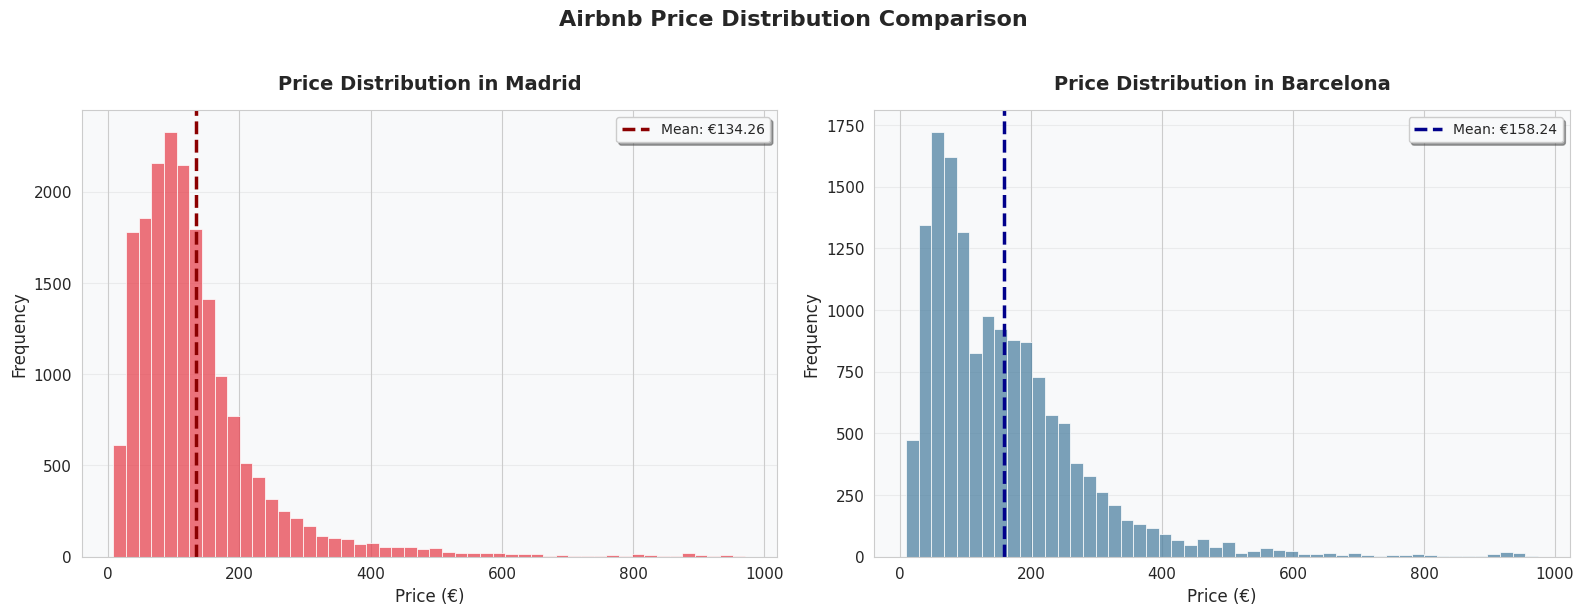

In [ ]:
# Price distribution analysis
def plot_price_distribution(df, city, ax, color):
    """Helper function to plot price distribution for a city"""
    city_data = df[df['City'] == city]
    mean_price = city_data['price'].mean()

    sns.histplot(data=city_data, x='price', bins=50, ax=ax,
                 color=color, alpha=0.7, edgecolor='white', linewidth=0.5)

    ax.axvline(mean_price, color='darkred' if city == 'Madrid' else 'darkblue',
               linestyle='--', linewidth=2.5, label=f'Mean: €{mean_price:.2f}')

    ax.set_title(f'Price Distribution in {city}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Price (€)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(fontsize=10, frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Airbnb Price Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)

plot_price_distribution(listings_first_clean, 'Madrid', ax1, COLORS['madrid'])
plot_price_distribution(listings_first_clean, 'Barcelona', ax2, COLORS['barcelona'])

plt.tight_layout()
plt.show()

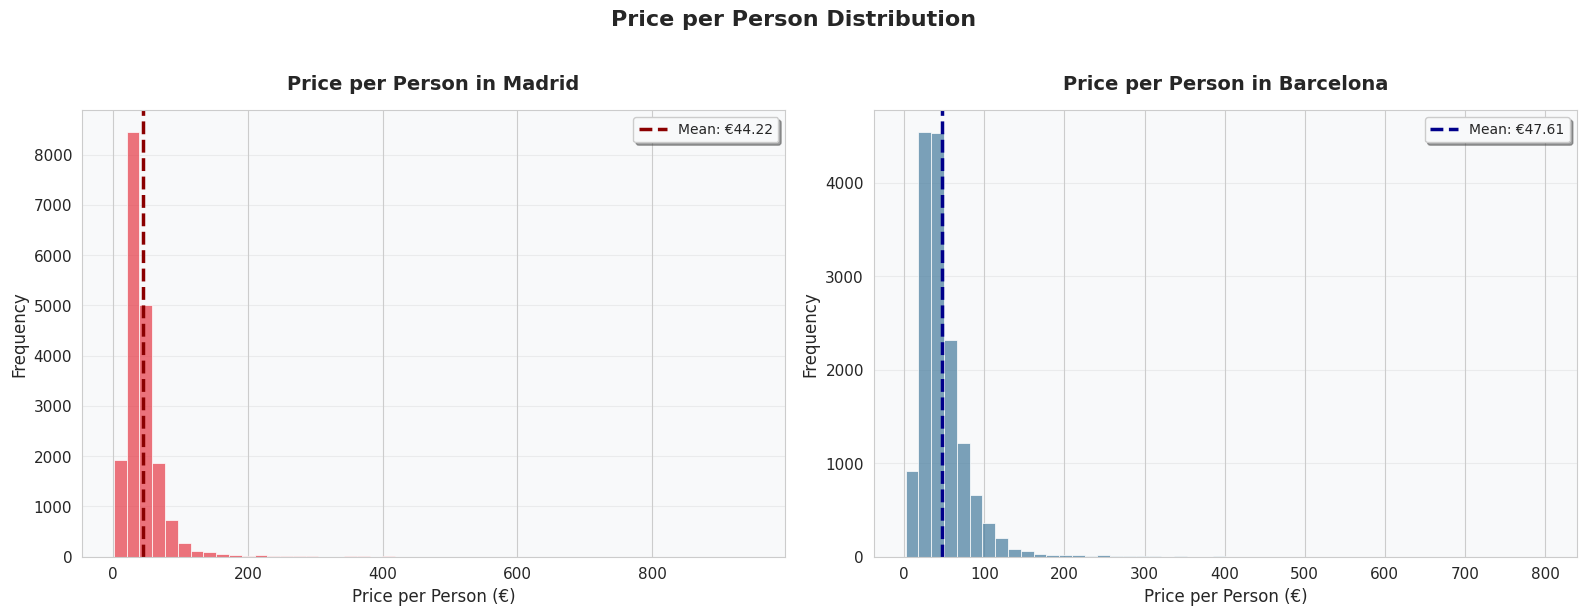

In [ ]:
# Calculate price per person
listings_first_clean['price_per_person'] = listings_first_clean['price'] / listings_first_clean['accommodates']

# Price per person distribution
def plot_price_per_person(df, city, ax, color):
    """Helper function to plot price per person distribution"""
    city_data = df[df['City'] == city]
    mean_ppp = city_data['price_per_person'].mean()

    sns.histplot(data=city_data, x='price_per_person', bins=50, ax=ax,
                 color=color, alpha=0.7, edgecolor='white', linewidth=0.5)

    ax.axvline(mean_ppp, color='darkred' if city == 'Madrid' else 'darkblue',
               linestyle='--', linewidth=2.5, label=f'Mean: €{mean_ppp:.2f}')

    ax.set_title(f'Price per Person in {city}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Price per Person (€)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(fontsize=10, frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Price per Person Distribution', fontsize=16, fontweight='bold', y=1.02)

plot_price_per_person(listings_first_clean, 'Madrid', ax1, COLORS['madrid'])
plot_price_per_person(listings_first_clean, 'Barcelona', ax2, COLORS['barcelona'])

plt.tight_layout()
plt.show()

Both cities exhibit the typical right-skewed pattern: a dense cluster of budget listings with longer luxury tails. Barcelona sits ~24 € higher on the mean for price, and ~3 € higher on price-per-person, which persists after trimming extremes. This could indicate genuine pricing power rather than noise. With that baseline, we investigate where (neighborhoods) and how (room types, accommodates) that premium materializes.

In [ ]:
# Calculate price per person if not already done
if 'price_per_person' not in listings_first_clean.columns:
    listings_first_clean['price_per_person'] = listings_first_clean['price'] / listings_first_clean['accommodates']

# Aggregate neighborhood prices
neighborhood_prices = listings_first_clean.groupby(['City', 'neighbourhood_cleansed'])['price_per_person'].agg(
    ['mean', 'count']).reset_index()
neighborhood_prices = neighborhood_prices[neighborhood_prices['count'] > 10]  # Filter low-count neighborhoods

# Get top 10 neighborhoods per city
madrid_top = neighborhood_prices[neighborhood_prices['City'] == 'Madrid'].nlargest(10, 'mean')
barcelona_top = neighborhood_prices[neighborhood_prices['City'] == 'Barcelona'].nlargest(10, 'mean')

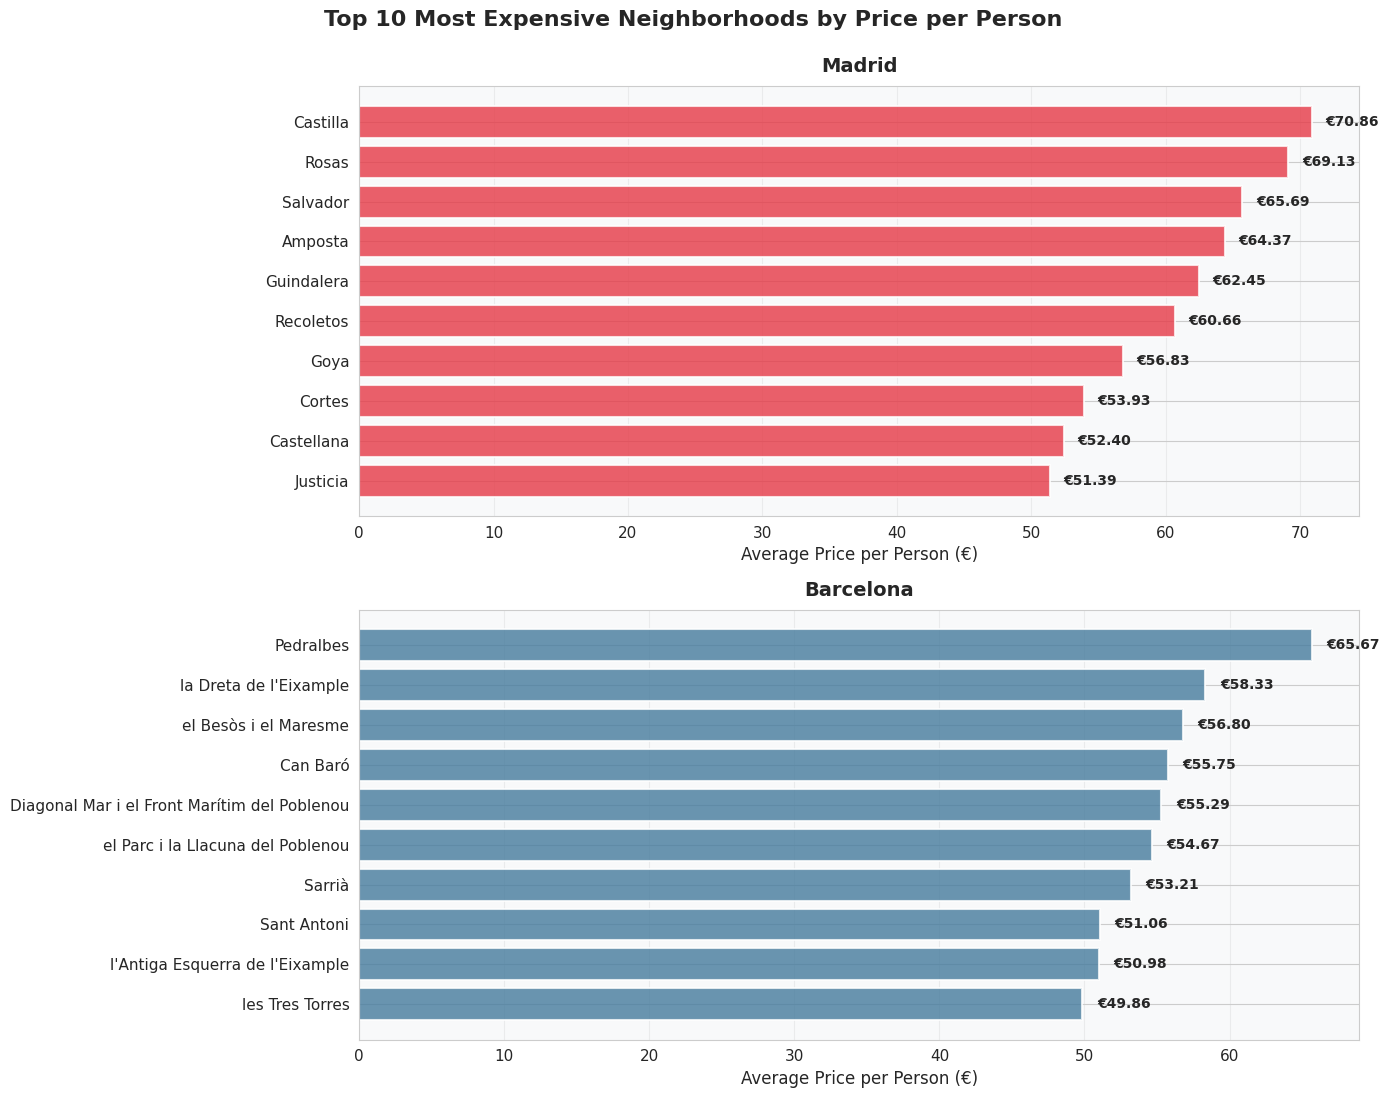

In [ ]:
# Visualize top neighborhoods
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 11))
fig.suptitle('Top 10 Most Expensive Neighborhoods by Price per Person',
             fontsize=16, fontweight='bold', y=0.995)

# Madrid plot
bars1 = ax1.barh(madrid_top['neighbourhood_cleansed'], madrid_top['mean'],
                 color=COLORS['madrid'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax1.set_title('Madrid', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Average Price per Person (€)', fontsize=12)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, madrid_top['mean'])):
    ax1.text(value + 1, bar.get_y() + bar.get_height()/2, f'€{value:.2f}',
             va='center', fontsize=10, fontweight='bold')

# Barcelona plot
bars2 = ax2.barh(barcelona_top['neighbourhood_cleansed'], barcelona_top['mean'],
                 color=COLORS['barcelona'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_title('Barcelona', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Average Price per Person (€)', fontsize=12)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, barcelona_top['mean'])):
    ax2.text(value + 1, bar.get_y() + bar.get_height()/2, f'€{value:.2f}',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze by absolute price (not per person)
price_cutoff_95 = listings_first_clean['price'].quantile(0.95)
df_filtered = listings_first_clean[listings_first_clean['price'] < price_cutoff_95]

neighborhood_absolute = df_filtered.groupby(['City', 'neighbourhood_cleansed'])['price'].agg(
    ['mean', 'count']).reset_index()
neighborhood_absolute = neighborhood_absolute[neighborhood_absolute['count'] > 10]

madrid_top_abs = neighborhood_absolute[neighborhood_absolute['City'] == 'Madrid'].nlargest(10, 'mean')
barcelona_top_abs = neighborhood_absolute[neighborhood_absolute['City'] == 'Barcelona'].nlargest(10, 'mean')

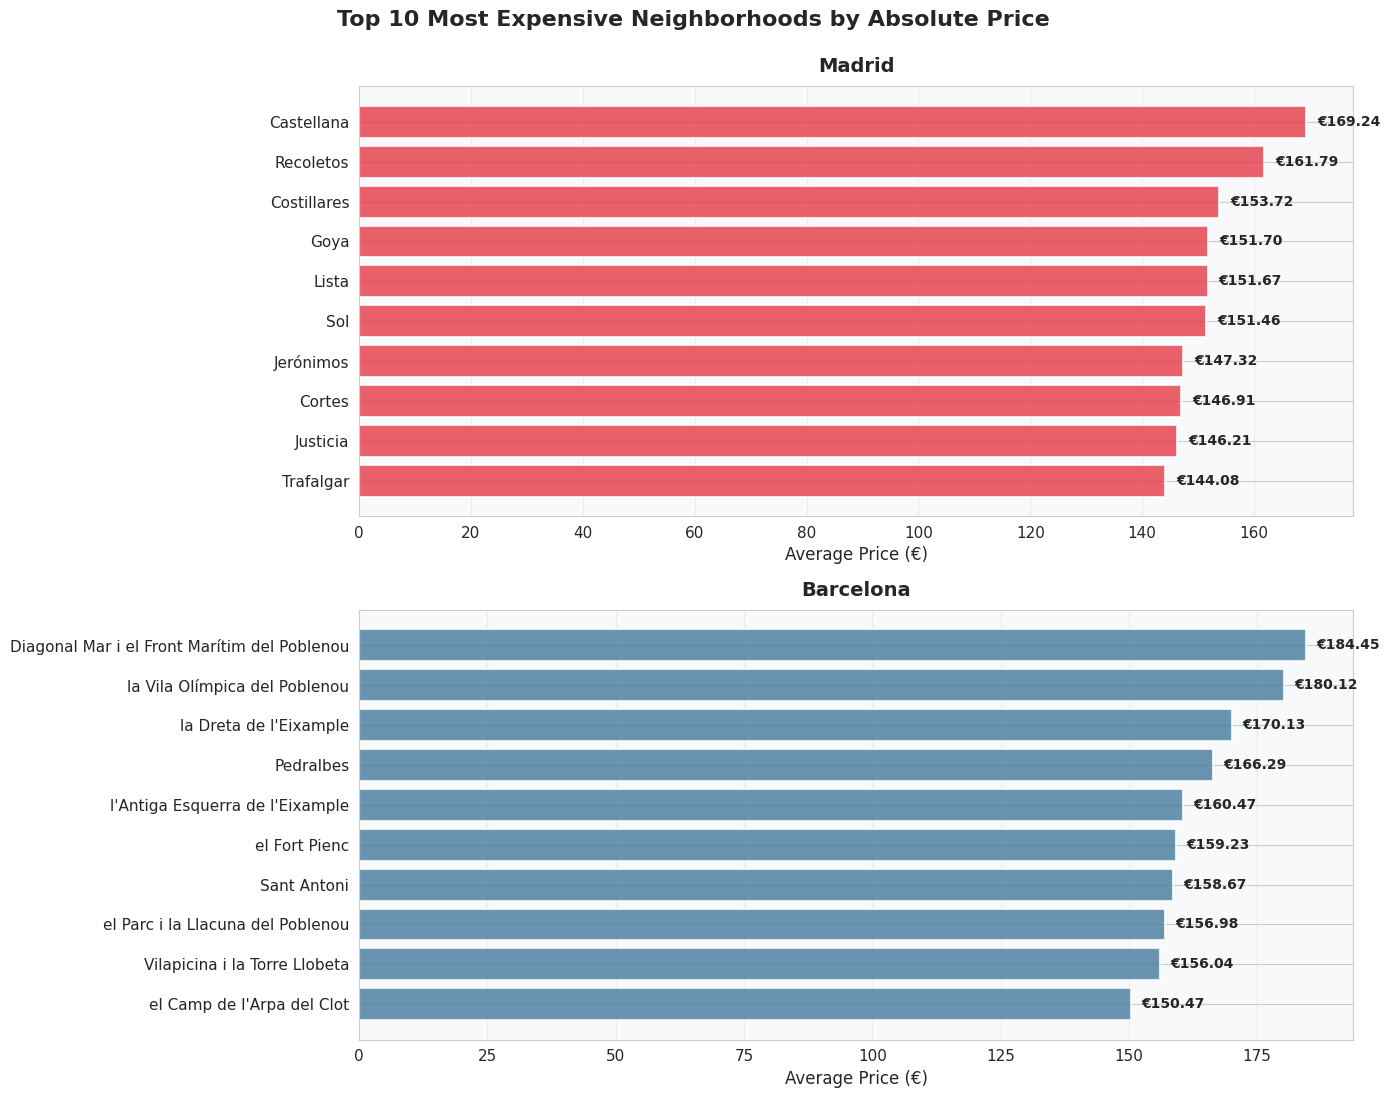

In [ ]:
# Visualize by absolute price
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 11))
fig.suptitle('Top 10 Most Expensive Neighborhoods by Absolute Price',
             fontsize=16, fontweight='bold', y=0.995)

# Madrid plot
bars1 = ax1.barh(madrid_top_abs['neighbourhood_cleansed'], madrid_top_abs['mean'],
                 color=COLORS['madrid'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax1.set_title('Madrid', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Average Price (€)', fontsize=12)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

for i, (bar, value) in enumerate(zip(bars1, madrid_top_abs['mean'])):
    ax1.text(value + 2, bar.get_y() + bar.get_height()/2, f'€{value:.2f}',
             va='center', fontsize=10, fontweight='bold')

# Barcelona plot
bars2 = ax2.barh(barcelona_top_abs['neighbourhood_cleansed'], barcelona_top_abs['mean'],
                 color=COLORS['barcelona'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_title('Barcelona', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Average Price (€)', fontsize=12)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

for i, (bar, value) in enumerate(zip(bars2, barcelona_top_abs['mean'])):
    ax2.text(value + 2, bar.get_y() + bar.get_height()/2, f'€{value:.2f}',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

No surprise: the top price-per-person neighborhoods cluster inside the urban core (Goya, Sol, Castellana...). Switching from absolute price to price-per-person reshuffles the order because some districts skew toward large multi-bedroom homes (higher absolute rates) while others specialize in compact premium studios. Remember the dataset covers the municipal limits of Madrid and Barcelona, not the full autonomous communities, so the comparisons stay apples-to-apples.

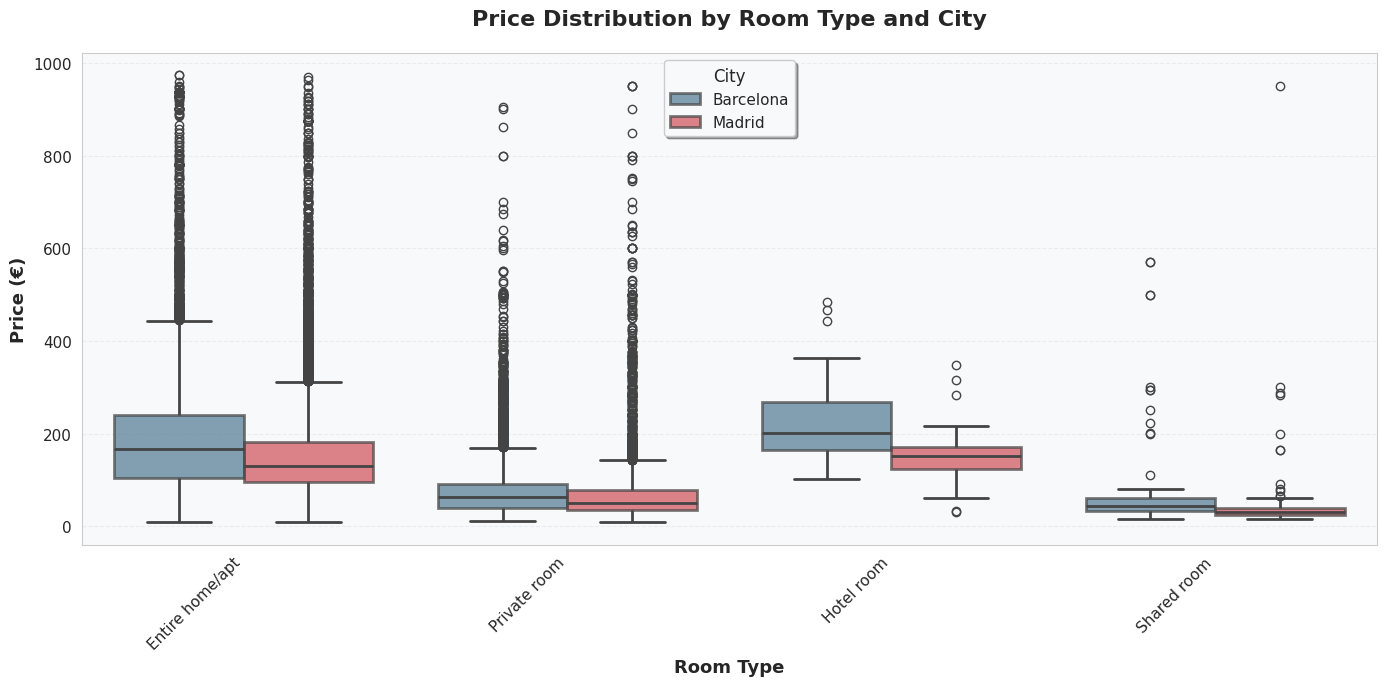

In [ ]:
# Get room types with sufficient data
property_counts = listings_first_clean.groupby('room_type').size()
common_types = property_counts[property_counts >= 20].index
plot_data = listings_first_clean[listings_first_clean['room_type'].isin(common_types)]

# Create enhanced boxplot
fig, ax = plt.subplots(figsize=(14, 7))

# Use custom palette (fixed typo: removed space before Madrid)
city_palette = {'Madrid': COLORS['madrid'], 'Barcelona': COLORS['barcelona']}
box_plot = sns.boxplot(x='room_type', y='price', hue='City', data=plot_data,
                       palette=city_palette, ax=ax, linewidth=2)

# Enhance visual appearance
for patch in ax.patches:
    patch.set_alpha(0.7)

ax.set_title('Price Distribution by Room Type and City',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Room Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Price (€)', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='City', fontsize=11, title_fontsize=12, frameon=True, shadow=True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Boxplots by room type confirm the intuition: hotel rooms command the richest rates once we control for size, followed by entire homes, then private rooms and shared rooms (just as one would expect).

Entire homes show the widest spread (they range from studios to multi-level villas), whereas shared rooms sit in the tightest band. Across every category Barcelona’s median is higher, suggesting investors rely on either more differentiated product or stronger demand to justify the uplift.

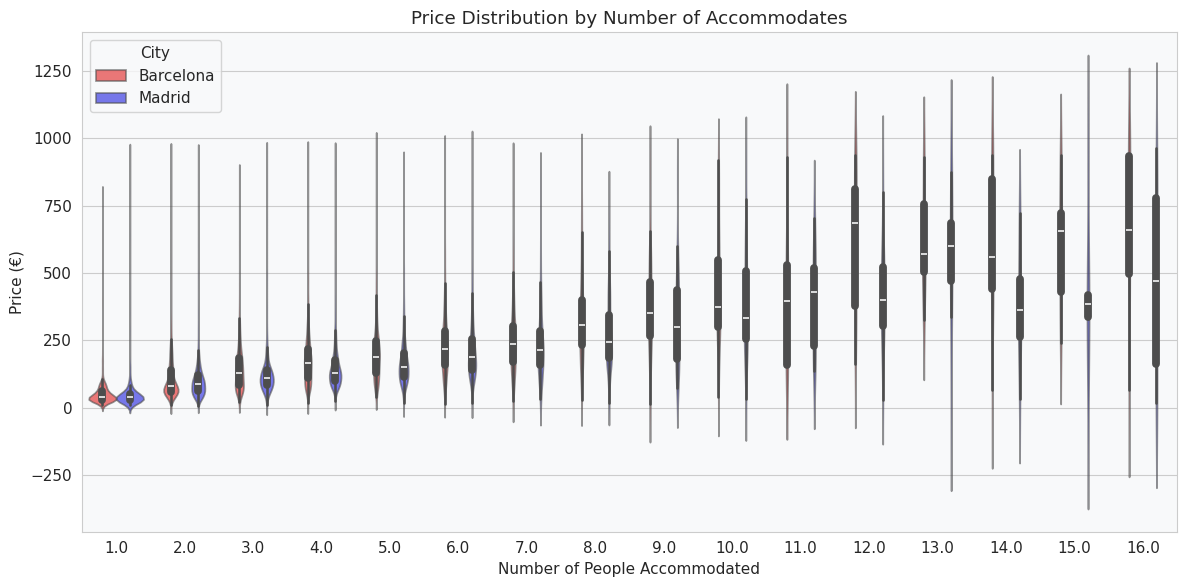

In [ ]:
def analyze_price_by_accommodates(df):


    # Filter for common accommodates sizes
    common_sizes = df['accommodates'].value_counts() > 20
    common_sizes = common_sizes[common_sizes].index
    plot_data = df[df['accommodates'].isin(common_sizes)]

    plt.figure(figsize=(12, 6))

    # Create violin plot
    sns.violinplot(x='accommodates', y='price', hue='City', data=plot_data,
                  palette={'Madrid': 'blue', 'Barcelona': 'red'}, alpha=0.6)

    plt.title('Price Distribution by Number of Accommodates')
    plt.xlabel('Number of People Accommodated')
    plt.ylabel('Price (€)')

    plt.tight_layout()
    plt.show()

analyze_price_by_accommodates(listings_first_clean)

Violin plots by guest capacity show a clear pattern: prices increase as properties accommodate more people, but the price range widens dramatically for larger properties. Smaller units (1 to 4 guests) have tight, consistent price distributions. Larger properties show much more variation, splitting between standard family homes and luxury properties. Barcelona consistently prices higher than Madrid across nearly all capacity levels.

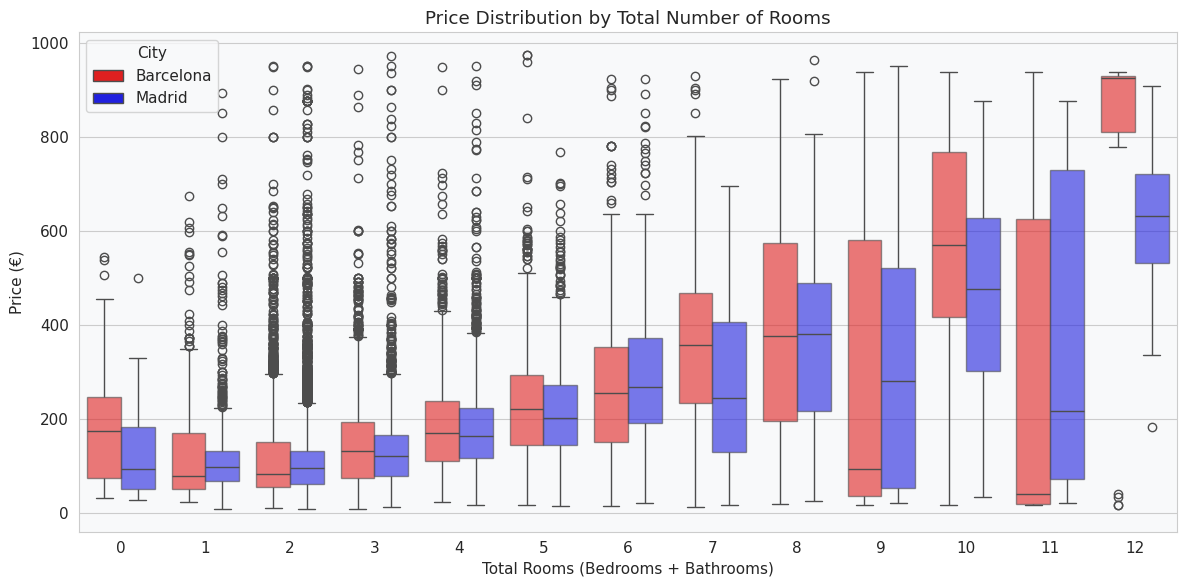

In [ ]:
def analyze_price_by_total_rooms(df):
    # Create a copy of the dataframe
    df = df.copy()


    # Create total rooms - ensure we're working with numeric values
    df['total_rooms'] = df['bedrooms'].fillna(1) + df['bathrooms'].fillna(0)
    df['total_rooms'] = df['total_rooms'].astype(int)

    # Filter for common room counts (at least 20 listings)
    room_counts = df['total_rooms'].value_counts()
    common_rooms = room_counts[room_counts >= 20].index
    plot_data = df[df['total_rooms'].isin(common_rooms)]

    plt.figure(figsize=(12, 6))

    # Create box plot without alpha in palette
    sns.boxplot(x='total_rooms', y='price', hue='City', data=plot_data,
                palette={'Madrid': 'blue', 'Barcelona': 'red'})

    # Set alpha manually for patches
    for patch in plt.gca().patches:
        patch.set_alpha(0.6)

    plt.title('Price Distribution by Total Number of Rooms')
    plt.xlabel('Total Rooms (Bedrooms + Bathrooms)')
    plt.ylabel('Price (€)')

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_price_by_total_rooms(listings_first_clean)

Room-count distributions mirror the accommodates story: more rooms correlate with higher prices, yet the dispersion widens drastically at the top end. Madrid briefly overtakes Barcelona for some of the largest homes, but those segments are sparsely populated and often trimmed by our 99th-percentile rule, so we avoid over-interpreting them. The more useful insight is how price-per-person behaves as we scale capacity, which we explore next.

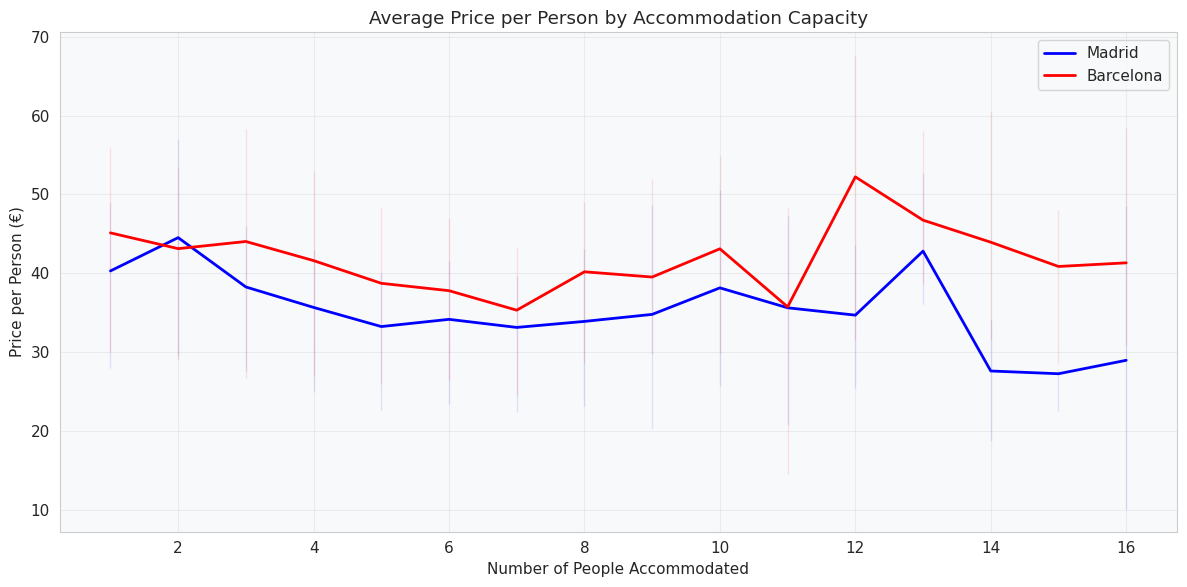

In [ ]:
def analyze_price_efficiency(df):
    # Create a copy of the dataframe
    df = df.copy()


    df['price_per_person'] = df['price'] / df['accommodates']

    # Remove extreme price_per_person values
    df = df[df['price_per_person'] < df['price_per_person'].quantile(0.95)]

    plt.figure(figsize=(12, 6))

    # Calculate mean price per person for each number of accommodates
    mean_prices = df.groupby(['City', 'accommodates'])['price_per_person'].mean().reset_index()

    # Plot lines for each city
    for city, color in zip(['Madrid', 'Barcelona'], ['blue', 'red']):
        city_data = mean_prices[mean_prices['City'] == city]

        # Add main line
        plt.plot(city_data['accommodates'], city_data['price_per_person'],
                color=color, linewidth=2, label=city)

        # Add confidence interval
        city_raw = df[df['City'] == city]
        for accom in city_data['accommodates']:
            prices = city_raw[city_raw['accommodates'] == accom]['price_per_person']
            plt.fill_between([accom],
                           [prices.quantile(0.25)],
                           [prices.quantile(0.75)],
                           color=color, alpha=0.1)

    plt.title('Average Price per Person by Accommodation Capacity')
    plt.xlabel('Number of People Accommodated')
    plt.ylabel('Price per Person (€)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_price_efficiency(listings_first_clean)

Average price per person declines as guest capacity increases, showing classic economies of scale. However, there are notable peaks where efficiency is highest. Barcelona peaks around 12 guests at roughly 52 euros per person, while Madrid shows smaller peaks around 2 and 13 guests at around 44 and 43 euros per person respectively. For investors, properties at these capacity levels can deliver strong yield per guest. Barcelona consistently charges more per person than Madrid across nearly all capacity levels, maintaining a premium of roughly 5 to 10 euros per person throughout most of the range.

## **Step 3: Statistical Testing**

We stress-test the descriptive patterns statistically. Because price distributions are non-normal, we first confirm that with D’Agostino tests and then rely on the Mann–Whitney U test to evaluate whether Barcelona’s prices are significantly higher overall and within each room type.

In [ ]:
import scipy.stats as stats
import numpy as np

def compare_city_prices(df):
    # Separate prices by city
    barcelona_prices = df[df['City'] == 'Barcelona']['price']
    madrid_prices = df[df['City'] == 'Madrid']['price']

    # Basic descriptive statistics
    print("Descriptive Statistics:")
    print("\nBarcelona:")
    print(f"Mean Price: €{barcelona_prices.mean():.2f}")
    print(f"Median Price: €{barcelona_prices.median():.2f}")
    print(f"Std Dev: €{barcelona_prices.std():.2f}")

    print("\nMadrid:")
    print(f"Mean Price: ${madrid_prices.mean():.2f}")
    print(f"Median Price: ${madrid_prices.median():.2f}")
    print(f"Std Dev: ${madrid_prices.std():.2f}")

    # Test for normality
    _, barcelona_norm_p = stats.normaltest(barcelona_prices)
    _, madrid_norm_p = stats.normaltest(madrid_prices)

    print("\nNormality Test p-values:")
    print(f"Barcelona: {barcelona_norm_p:.4f}")
    print(f"Madrid: {madrid_norm_p:.4f}")

    # Since test for normality was negative
    # we'll use Mann-Whitney U test (non-parametric)
    statistic, p_value = stats.mannwhitneyu(
        barcelona_prices,
        madrid_prices,
        alternative='greater'  # Testing if Barcelona prices are higher
    )

    print("\nMann-Whitney U Test Results:")
    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value:.4f}")

    return statistic, p_value

# Run the analysis
statistic, p_value = compare_city_prices(listings_first_clean)


# Additional analysis by property type
def compare_prices_by_property_type(df):
    property_types = df['room_type'].value_counts().head(5).index

    print("\nPrice Comparison by Top Property Types:")
    for prop_type in property_types:
        barcelona_prices = df[(df['City'] == 'Barcelona') &
                            (df['room_type'] == prop_type)]['price']
        madrid_prices = df[(df['City'] == 'Madrid') &
                          (df['room_type'] == prop_type)]['price']

        if len(barcelona_prices) > 0 and len(madrid_prices) > 0:
            _, p_value = stats.mannwhitneyu(
                barcelona_prices,
                madrid_prices,
                alternative='greater'
            )

            print(f"\n{prop_type}:")
            print(f"Barcelona Mean: €{barcelona_prices.mean():.2f}")
            print(f"Madrid Mean: €{madrid_prices.mean():.2f}")
            print(f"P-value: {p_value:.4f}")

# Run property type analysis
compare_prices_by_property_type(listings_first_clean)

Descriptive Statistics:

Barcelona:
Mean Price: €158.24
Median Price: €129.00
Std Dev: €124.77

Madrid:
Mean Price: $134.26
Median Price: $110.00
Std Dev: $106.63

Normality Test p-values:
Barcelona: 0.0000
Madrid: 0.0000

Mann-Whitney U Test Results:
Statistic: 156353029.5
P-value: 0.0000

Price Comparison by Top Property Types:

Entire home/apt:
Barcelona Mean: €191.57
Madrid Mean: €157.58
P-value: 0.0000

Private room:
Barcelona Mean: €85.03
Madrid Mean: €74.12
P-value: 0.0000

Shared room:
Barcelona Mean: €76.21
Madrid Mean: €46.42
P-value: 0.0000

Hotel room:
Barcelona Mean: €223.94
Madrid Mean: €151.10
P-value: 0.0000


Results are clear: p-values are well below 0.01 both overall and across every room type, so we can confidently conclude that Barcelona commands a true price premium over Madrid.

Barcelona averages €158 per night versus Madrid's €134, a difference of roughly €24 or 18%. This premium holds consistently across all property types, from entire homes (Barcelona €192 versus Madrid €158) to shared rooms (Barcelona €76 versus Madrid €46).

Later sections explore why this premium exists by examining supply factors like property characteristics and amenities, along with demand indicators like reviews and occupancy patterns.

## **Step 4: Prescriptive Analytics**

To turn our findings into practical recommendations, we build two prediction models using Random Forest: one predicts the total nightly price, and the other predicts price per person. While correlation analysis shows us basic relationships (like bigger properties cost more, but charge less per guest), the Random Forest models tell us which factors matter most for setting competitive prices.

We chose Random Forest because it works well with different types of data (numbers, categories, etc.) and clearly shows which factors have the biggest impact on pricing, which is more useful for investment decisions than just having an accurate prediction.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import ast

def analyze_price_correlations(df):
    # Prepare numerical features
    numerical_features = [
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'number_of_reviews',
        'review_scores_rating',
        'review_scores_cleanliness',
        'review_scores_location',
        'minimum_nights',
        'maximum_nights',
        'availability_365',
        'host_listings_count',
        'price',
        'price_per_person'
    ]

    # Prepare categorical features
    categorical_features = [
        'room_type',
        'property_type',
        'neighbourhood_cleansed',
        'instant_bookable',
        'host_is_superhost'
    ]

    # Create a copy of numerical features
    corr_df = df[numerical_features].copy()

    # Encode and add categorical features
    le = LabelEncoder()
    for cat_col in categorical_features:
        corr_df[cat_col] = le.fit_transform(df[cat_col].astype(str))

    # Calculate correlation matrix
    correlation_matrix = corr_df.corr()

    # Get correlations with price and price_per_person
    price_correlations = correlation_matrix['price'].sort_values(ascending=False)
    price_per_person_correlations = correlation_matrix['price_per_person'].sort_values(ascending=False)

    return price_correlations, price_per_person_correlations

# Analyze each city separately
for city in ['Madrid', 'Barcelona']:
    city_data = listings_first_clean[listings_first_clean['City'] == city]
    price_corr, price_per_person_corr = analyze_price_correlations(city_data)

    print(f"\n{'='*50}")
    print(f"\nCorrelations for {city}:")
    print(f"\nCorrelations with Price (sorted):")
    print(price_corr)
    print(f"\nCorrelations with Price Per Person (sorted):")
    print(price_per_person_corr)
    print(f"\n{'='*50}")



Correlations for Madrid:

Correlations with Price (sorted):
price                        1.000000
price_per_person             0.590798
accommodates                 0.542763
bedrooms                     0.421262
beds                         0.399800
bathrooms                    0.298075
instant_bookable             0.196541
maximum_nights               0.118458
host_listings_count          0.079680
neighbourhood_cleansed       0.050241
availability_365             0.035353
host_is_superhost            0.006823
review_scores_location       0.005501
number_of_reviews            0.004998
review_scores_cleanliness    0.000181
review_scores_rating        -0.004438
minimum_nights              -0.096783
property_type               -0.319041
room_type                   -0.353562
Name: price, dtype: float64

Correlations with Price Per Person (sorted):
price_per_person             1.000000
price                        0.590798
instant_bookable             0.102197
availability_365            

**Price model:** Size-related variables like guest capacity, beds, and bathrooms have the strongest correlations with price. This makes sense but doesn't tell us much beyond "bigger properties cost more." That's why we also build a price-per-person model to identify what drives value beyond just size.

**Price-per-person model:** Capacity variables flip their relationship here. More guests means lower price per person, which is expected (economies of scale). Beyond that, the correlations are much weaker, meaning we need more sophisticated analysis to find what truly matters.

**Key differences between cities:**
- Barcelona shows stronger correlations between reviews and price (0.20 for review count, 0.15 for ratings) compared to Madrid (essentially 0)
- Barcelona guests seem willing to pay more for well-reviewed properties, while Madrid pricing is driven almost entirely by size
- Both cities show similar negative correlations with room type and property type, confirming entire homes cost more than private or shared rooms


Model Performance:
Mean Squared Error: 5136.91
R-squared Score: 0.6203

Top 20 Most Important Features:
                      feature  importance
0                accommodates    0.370967
1                   bathrooms    0.071486
10           availability_365    0.059920
14     neighbourhood_cleansed    0.055831
8              minimum_nights    0.054664
11        host_listings_count    0.051619
13              property_type    0.044122
2                    bedrooms    0.035645
7      review_scores_location    0.031243
9              maximum_nights    0.030356
4           number_of_reviews    0.028591
6   review_scores_cleanliness    0.021933
5        review_scores_rating    0.018704
12                  room_type    0.017628
15           instant_bookable    0.012633
3                        beds    0.011262
34               has_elevator    0.009135
35                has_shampoo    0.006123
33    has_dedicated_workspace    0.005050
23                   has_iron    0.004923


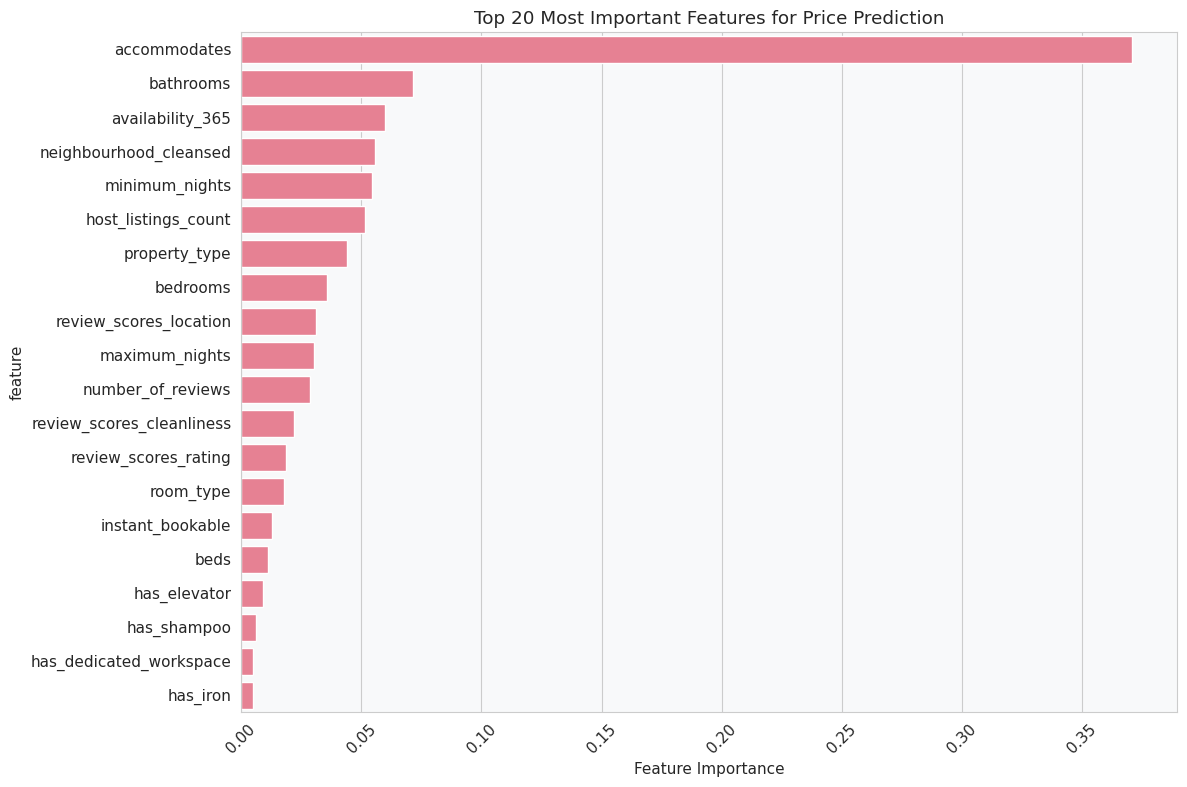

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import ast

def prepare_data_for_modeling(df):
    # Select key numerical columns
    numerical_features = [
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'number_of_reviews',
        'review_scores_rating',
        'review_scores_cleanliness',
        'review_scores_location',
        'minimum_nights',
        'maximum_nights',
        'availability_365',
        'host_listings_count'
    ]

    # Select key categorical columns
    categorical_features = [
        'room_type',
        'property_type',
        'neighbourhood_cleansed',
        'instant_bookable',
        'host_is_superhost'
    ]

    # Create a copy of the dataframe with selected features
    X = df[numerical_features + categorical_features].copy()
    y = df['price']

    # Handle categorical variables
    label_encoders = {}
    for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        X[cat_col] = label_encoders[cat_col].fit_transform(X[cat_col].astype(str))

    # Process amenities more safely
    def parse_amenities(amenities_str):
        try:
            if pd.isna(amenities_str):
                return set()
            # Remove brackets and split by comma
            cleaned = amenities_str.strip('[]{}').replace('"', '').replace("'", "")
            return {item.strip() for item in cleaned.split(',') if item.strip()}
        except:
            return set()

    # Convert amenities to sets
    amenities = df['amenities'].apply(parse_amenities)

    # Get most common amenities (top 20)
    all_amenities = set()
    for amenity_set in amenities:
        all_amenities.update(amenity_set)

    amenity_counts = pd.Series([
        sum(1 for amenity_set in amenities if amenity in amenity_set)
        for amenity in all_amenities
    ], index=all_amenities).sort_values(ascending=False)

    top_amenities = amenity_counts.head(20).index

    # Create binary columns for top amenities
    for amenity in top_amenities:
        X[f'has_{amenity.lower().replace(" ", "_")}'] = amenities.apply(
            lambda x: 1 if amenity in x else 0
        )

    return X, y, label_encoders

# The rest of the code remains the same
def train_and_analyze_random_forest(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    return rf_model, feature_importance, mse, r2

# Run the analysis
X, y, label_encoders = prepare_data_for_modeling(listings_first_clean)
model, feature_importance, mse, r2 = train_and_analyze_random_forest(X, y)

# Print results
print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(20)
)
plt.title('Top 20 Most Important Features for Price Prediction')
plt.xlabel('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key takeaways from the price model:**

Guest capacity is by far the most important factor, explaining 37% of price variation. This dwarfs everything else. Bathrooms come in second at 7%, significantly outranking bedrooms (3.6%). This suggests bathrooms signal premium quality more than just bedroom count.

Availability throughout the year matters more than you'd expect (6%), ranking third overall. Properties with high availability tend to charge more, likely because professional hosts keep their calendars open and price confidently.

Neighborhood is the fifth most important factor (5.6%), confirming location drives pricing. This effect shows up twice: directly through which neighborhood you're in, and indirectly through location review scores (3.1%).

Property type and room type together account for about 6% of importance. The gap between hotel rooms, entire homes, and shared spaces creates significant price variation.

Review metrics collectively matter (7% combined across rating, cleanliness, and location scores). Strong review profiles give hosts pricing power.

Specific amenities start appearing in the top 20, with elevators (0.9%), shampoo (0.6%), and dedicated workspaces (0.5%) making the cut. These premium touches add value beyond basic size metrics.

Now we examine price per person to see what drives efficiency and value beyond just property size.

Random Forest Model for Price Per Person
--------------------------------------------------

Model Performance:
Mean Squared Error: 882.03
R-squared Score: 0.3547

Top 20 Most Important Features:
                      feature  importance
10           availability_365    0.134900
8              minimum_nights    0.102099
13              property_type    0.095034
14     neighbourhood_cleansed    0.088069
0                accommodates    0.081436
11        host_listings_count    0.077626
9              maximum_nights    0.049799
4           number_of_reviews    0.044755
15           instant_bookable    0.038787
7      review_scores_location    0.035809
6   review_scores_cleanliness    0.028774
5        review_scores_rating    0.025384
1                   bathrooms    0.020272
34               has_elevator    0.014804
35                has_shampoo    0.012881
3                        beds    0.011968
2                    bedrooms    0.011594
18                has_kitchen    0.010200
23    

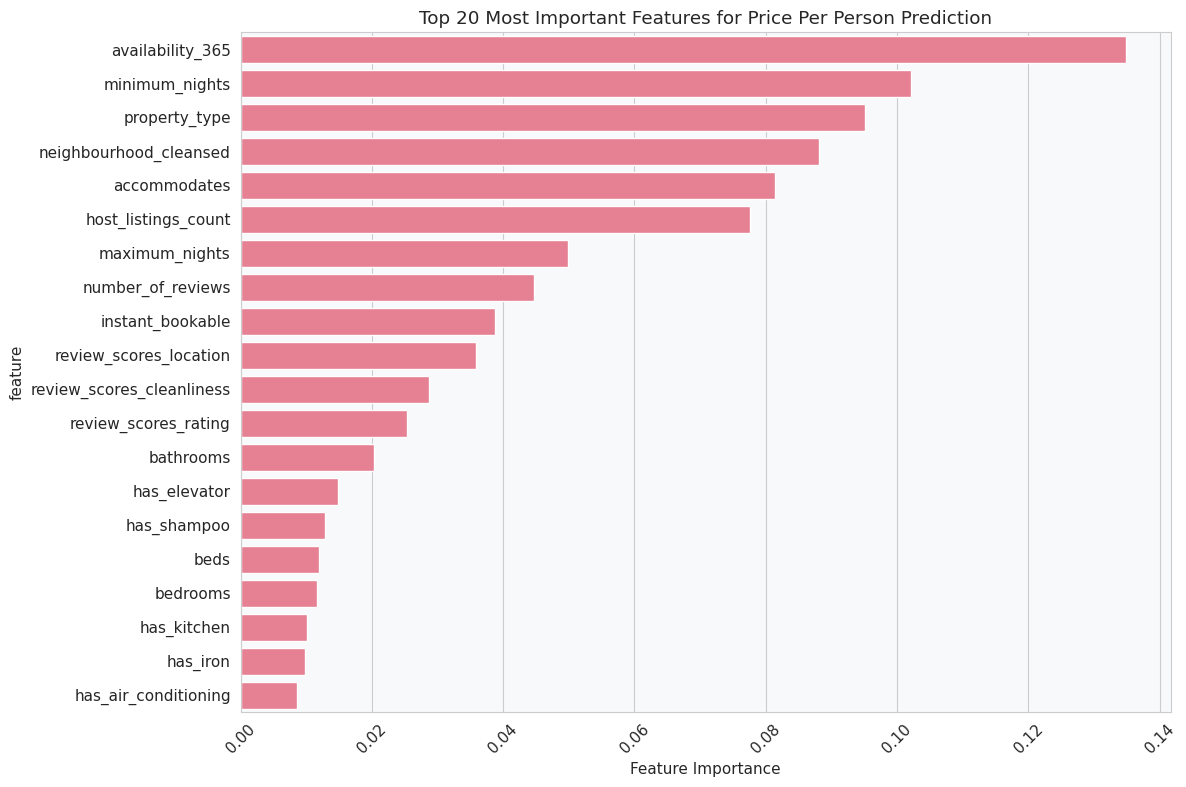

In [ ]:
def prepare_data_for_modeling_price_per_person(df):
    # Calculate price per person
    df = df.copy()
    df['price_per_person'] = df['price'] / df['accommodates']

    # Select key numerical columns
    numerical_features = [
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'number_of_reviews',
        'review_scores_rating',
        'review_scores_cleanliness',
        'review_scores_location',
        'minimum_nights',
        'maximum_nights',
        'availability_365',
        'host_listings_count'
    ]

    # Select key categorical columns
    categorical_features = [
        'room_type',
        'property_type',
        'neighbourhood_cleansed',
        'instant_bookable',
        'host_is_superhost'
    ]

    # Create a copy of the dataframe with selected features
    X = df[numerical_features + categorical_features].copy()
    y = df['price_per_person']

    # Handle categorical variables
    label_encoders = {}
    for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        X[cat_col] = label_encoders[cat_col].fit_transform(X[cat_col].astype(str))

    # Process amenities
    def parse_amenities(amenities_str):
        try:
            if pd.isna(amenities_str):
                return set()
            cleaned = amenities_str.strip('[]{}').replace('"', '').replace("'", "")
            return {item.strip() for item in cleaned.split(',') if item.strip()}
        except:
            return set()

    # Convert amenities to sets
    amenities = df['amenities'].apply(parse_amenities)

    # Get most common amenities (top 20)
    all_amenities = set()
    for amenity_set in amenities:
        all_amenities.update(amenity_set)

    amenity_counts = pd.Series([
        sum(1 for amenity_set in amenities if amenity in amenity_set)
        for amenity in all_amenities
    ], index=all_amenities).sort_values(ascending=False)

    top_amenities = amenity_counts.head(20).index

    # Create binary columns for top amenities
    for amenity in top_amenities:
        X[f'has_{amenity.lower().replace(" ", "_")}'] = amenities.apply(
            lambda x: 1 if amenity in x else 0
        )

    return X, y, label_encoders

def train_and_analyze_random_forest_price_per_person(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    return rf_model, feature_importance, mse, r2

# Run the analysis
print("Random Forest Model for Price Per Person")
print("-" * 50)

X, y, label_encoders = prepare_data_for_modeling_price_per_person(listings_first_clean)
model, feature_importance, mse, r2 = train_and_analyze_random_forest_price_per_person(X, y)

# Print results
print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(20)
)
plt.title('Top 20 Most Important Features for Price Per Person Prediction')
plt.xlabel('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Price per person model results:**

Predicting price per person is much harder than predicting total price (R-squared of 0.35 versus likely higher for the price model). This makes sense because we've intentionally removed the biggest predictor: property size.

**What matters for price per person:**

Availability is now the top factor (13.5%), flipping the script from the total price model. Properties with high year-round availability charge more per person, suggesting professional management and confident pricing strategies.

Minimum nights requirement jumps to second place (10.2%). Hosts who require longer stays can charge higher per-person rates, likely because they attract different guest segments (relocations, extended stays) willing to pay premiums.

Property type becomes much more important (9.5%), now ranking third. Hotel rooms and specialty properties can sustain higher per-person rates than standard apartments, even when controlling for size.

Neighborhood moves up to fourth (8.8%), showing location matters even more when size is normalized. Prime areas command per-person premiums regardless of property size.

Guest capacity drops dramatically to fifth place (8.1%), down from 37% in the total price model. This confirms our strategy worked: we've removed size as the dominant factor.

Review metrics collectively contribute about 9%, similar to the total price model. Quality still matters for per-person pricing.

**Our main takeaway:**

After accounting for size, the factors that drive per-person pricing are much weaker and more evenly distributed. No single factor dominates. This means hosts need to differentiate through multiple dimensions: strategic availability management, smart minimum night policies, premium locations, strong reviews, and the right mix of amenities. The subsequent sections explore these qualitative differentiators in detail through supply analysis, amenity packages, and guest sentiment.

## **Section 1 Main Conclusions**

1. **Barcelona commands a real pricing premium.** It outprices Madrid by roughly 18% overall (€158 vs €134 per night), and this gap holds across every property type.

2. **Size drives pricing, but bathrooms matter more than you'd think.** Guest capacity explains 37% of price variation, making it the dominant factor. But bathrooms (7% importance) outrank bedrooms (3.6%), suggesting that bathroom quality and layout signal premium properties more than just bedroom count.

3. **Room type and property type create distinct pricing tiers.** Hotel rooms command the highest rates, followed by entire homes, then private rooms, and finally shared rooms. This hierarchy holds in both cities, though Barcelona maintains its premium across all categories.

4. **Price per person peaks at specific capacities.** Barcelona maximizes efficiency around 12 guests (€52 per person), while Madrid peaks at 2 and 13 guests (€43-44 per person). Properties at these sweet spots deliver the strongest per-guest yield before economies of scale flatten pricing.

5. **Location matters more when you normalize for size.** Central neighborhoods dominate absolute pricing, but rankings shift when measuring price per person because some districts specialize in large homes while others focus on compact premium units. Location review scores amplify these premiums.

6. **Professional hosting drives pricing power.** High year-round availability (13.5% importance for price per person), strategic minimum night requirements (10.2%), and strong review profiles (9% combined) separate premium hosts from average ones. These factors matter most once property size is controlled for.

7. **Barcelona guests value quality differently than Madrid guests.** Barcelona shows strong correlations between reviews and price (0.20 for review count, 0.15 for ratings), while Madrid pricing is driven almost entirely by size. This suggests Barcelona investors must compete on experience and amenities, not just square footage.

8. **Data limitations shape our conclusions.** We can't observe actual occupancy rates or property square meters, so we use unavailable dates as a rough demand proxy and rely on guest capacity as a size estimate. All conclusions focus on pricing patterns we can measure: rates, host behavior, reviews, and amenities.



**Price alone doesn't determine success.** The combination of location + configuration + guest experience drives value. Both markets are mature and efficient. Competitive advantage must come from superior execution, not format arbitrage.



These findings set up the rest of the analysis. The next sections dig into why certain properties command premium prices by examining supply composition (Section 2), neighborhood dynamics (Section 3), host professionalism (Section 4), and the role of reviews and amenities (Section 5).

# **Section 2: Property Type Distribution & Performance**

Goal: connect supply mix (room types, amenities, success proxies) with the pricing and demand signals we surfaced above.

Section  1 aims to show *what* is happening, and this section explains *who* is driving it.

## **Step 1: Pre-processing**

We reuse the cleaned `combined_listings` output from Section 1 so every metric here reflects the same pricing, review, and availability treatments.

In [ ]:
# Display the first 4 rows of the combined_listings DataFrame
combined_listings.head(4)


id                         listing_url     scrape_id last_scraped  \
0  18674.0  https://www.airbnb.com/rooms/18674  2.025091e+13   2025-09-15   
1  23197.0  https://www.airbnb.com/rooms/23197  2.025091e+13   2025-09-14   
2  32711.0  https://www.airbnb.com/rooms/32711  2.025091e+13   2025-09-15   
3  34241.0  https://www.airbnb.com/rooms/34241  2.025091e+13   2025-09-15   

        source                                               name  \
0  city scrape    Huge flat for 8 people close to Sagrada Familia   
1  city scrape  Forum CCIB DeLuxe, Spacious, Large Balcony, relax   
2  city scrape                   Sagrada Familia area - Còrsega 1   
3  city scrape   Stylish Top Floor Apartment - Ramblas Plaza Real   

                                         description  \
0  110m2 apartment to rent in Barcelona. Located ...   
1  Beautiful and Spacious Apartment with Large Te...   
2  A lovely two bedroom apartment only 250 m from...   
3  Located in close proximity to Plaza Real and L...   

                               neighborhood_overview  \
0  Apartment in Barcelona located in the heart of...   
1  Strategically located in the Parc del Fòrum, a...   
2  What's nearby  <br />This apartment is located...   
3                                                NaN   

                                         picture_url   host_id  \
0  https://a0.muscache.com/pictures/13031453/413c...   71615.0   
1  https://a0.muscache.com/pictures/miso/Hosting-...   90417.0   
2  https://a0.muscache.com/pictures/357b25e4-f414...  135703.0   
3  https://a0.muscache.com/pictures/2437facc-2fe7...   73163.0   

                                   host_url       host_name  host_since  \
0   https://www.airbnb.com/users/show/71615          Mireia  2010-01-19   
1   https://www.airbnb.com/users/show/90417  Etain (Marnie)  2010-03-09   
2  https://www.airbnb.com/users/show/135703            Nick  2010-05-31   
3   https://www.airbnb.com/users/show/73163          Andres  2010-01-24   

      host_location                                         host_about  \
0  Barcelona, Spain  We are Mireia (47) & Maria (49), two multiling...   
1  Catalonia, Spain  Hi there,\n\nI’m marnie, originally from Austr...   
2  Barcelona, Spain  I'm Nick your English host in Barcelona.\r\n\r...   
3  Barcelona, Spain  Hello I am a Professional designer, a traveler...   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour                96%                  91%   
1     within an hour               100%                  96%   
2     within an hour               100%                 100%   
3     within an hour               100%                  92%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/User/...   
1                 t  https://a0.muscache.com/im/pictures/user/44b56...   
2                 f  https://a0.muscache.com/im/users/135703/profil...   
3                 f  https://a0.muscache.com/im/pictures/user/9cbe7...   

                                    host_picture_url  \
0  https://a0.muscache.com/im/pictures/user/User/...   
1  https://a0.muscache.com/im/pictures/user/44b56...   
2  https://a0.muscache.com/im/users/135703/profil...   
3  https://a0.muscache.com/im/pictures/user/9cbe7...   

                host_neighbourhood  host_listings_count  \
0               la Sagrada Família                 41.0   
1            El Besòs i el Maresme                  6.0   
2  Camp d'en Grassot i Gràcia Nova                  3.0   
3                         El Gòtic                  5.0   

   host_total_listings_count                host_verifications  \
0                       46.0                ['email', 'phone']   
1                        9.0                ['email', 'phone']   
2                       15.0  ['email', 'phone', 'work_email']   
3                        5.0  ['email', 'phone', 'work_email']   

  host_has_profile_pic host_identity

## **Step 2: Insights & Conclusions**

### **Step 2.1: Supply Mix**

In [ ]:
# Calculate room type percentages
room_type_counts_barcelona = barcelona_listings['room_type'].value_counts(normalize=True) * 100
room_type_counts_madrid = madrid_listings['room_type'].value_counts(normalize=True) * 100

# Create DataFrame for visualization
room_type_distribution = pd.DataFrame({
    'City': ['Barcelona'] * len(room_type_counts_barcelona) + ['Madrid'] * len(room_type_counts_madrid),
    'Room Type': list(room_type_counts_barcelona.index) + list(room_type_counts_madrid.index),
    'Percentage': list(room_type_counts_barcelona.values) + list(room_type_counts_madrid.values)
})

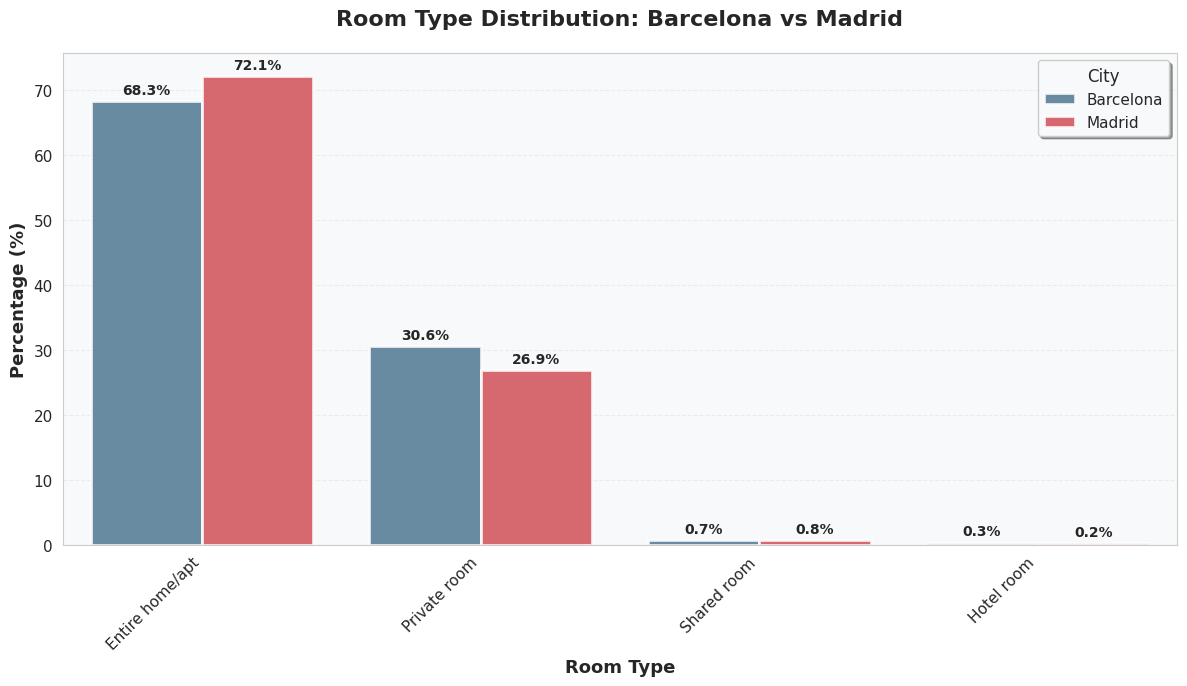

In [ ]:
# Create enhanced visualization
fig, ax = plt.subplots(figsize=(12, 7))

city_colors = {'Barcelona': COLORS['barcelona'], 'Madrid': COLORS['madrid']}
bar_plot = sns.barplot(data=room_type_distribution, x='Room Type', y='Percentage',
                       hue='City', palette=city_colors, ax=ax, alpha=0.85, edgecolor='white', linewidth=2)

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=10, fontweight='bold')

ax.set_title('Room Type Distribution: Barcelona vs Madrid',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Room Type', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='City', fontsize=11, title_fontsize=12, frameon=True, shadow=True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Entire homes/apartments and private rooms make up ~98 % of inventory in both cities, but Madrid leans more heavily into entire homes (~72 %) while Barcelona keeps a healthier mix (≈68 % entire, 30 % private). Shared rooms and hotel rooms barely register.

For investors, that means Barcelona offers slightly more budget-friendly private-room stock, whereas Madrid skews a bit toward full-unit operations—which can influence everything from cleaning logistics to licensing.

Average Guest Ratings by Room Type and City (excluding properties with no reviews):
City             Barcelona    Madrid
room_type                           
Entire home/apt   4.620646  4.630820
Hotel room        4.719200  4.558000
Private room      4.551251  4.639441
Shared room       4.535172  4.464062

Detailed breakdown:
  Entire home/apt in Barcelona: 4.62
  Entire home/apt in Madrid: 4.63
  Hotel room in Barcelona: 4.72
  Hotel room in Madrid: 4.56
  Private room in Barcelona: 4.55
  Private room in Madrid: 4.64
  Shared room in Barcelona: 4.54
  Shared room in Madrid: 4.46

Note: Analysis includes 27,359 properties with reviews out of 33,791 total listings


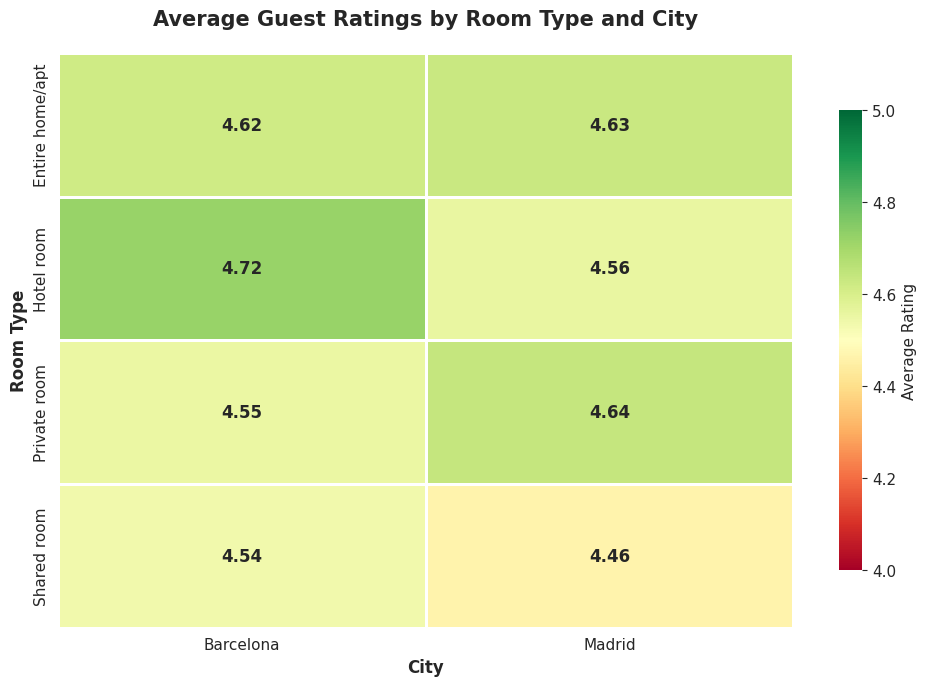

In [ ]:
# Calculate average ratings by room type and city
# IMPORTANT: Only include properties with actual reviews (review_scores_rating > 0)
# Properties with 0 rating have no reviews and shouldn't affect averages
listings_with_reviews = combined_listings[combined_listings['review_scores_rating'] > 0]
success_data = listings_with_reviews.groupby(['room_type', 'City'])['review_scores_rating'].mean().unstack()

# Print the data
print("Average Guest Ratings by Room Type and City (excluding properties with no reviews):")
print(success_data)
print("\nDetailed breakdown:")
for room_type in success_data.index:
    for city in success_data.columns:
        rating = success_data.loc[room_type, city]
        print(f"  {room_type} in {city}: {rating:.2f}")
print(f"\nNote: Analysis includes {len(listings_with_reviews):,} properties with reviews out of {len(combined_listings):,} total listings")

# Create enhanced heatmap
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(success_data, annot=True, fmt=".2f", cmap='RdYlGn',
            center=4.5, vmin=4.0, vmax=5.0,
            cbar_kws={'label': 'Average Rating', 'shrink': 0.8},
            linewidths=2, linecolor='white',
            annot_kws={'size': 12, 'weight': 'bold'}, ax=ax)

ax.set_title('Average Guest Ratings by Room Type and City',
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylabel('Room Type', fontsize=12, fontweight='bold')
ax.set_xlabel('City', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.show()

Average ratings look nearly identical across room types, so we drill into distribution spread with boxplots. The story might be in the variance (do shared rooms swing wider?) rather than the mean.

In [ ]:
# Prepare data for boxplot (excluding properties with no reviews)
barcelona_filtered = barcelona_listings[barcelona_listings['review_scores_rating'] > 0][['id', 'room_type', 'bedrooms', 'bathrooms', 'review_scores_rating', 'last_scraped']].copy()
madrid_filtered = madrid_listings[madrid_listings['review_scores_rating'] > 0][['id', 'room_type', 'bedrooms', 'bathrooms', 'review_scores_rating', 'last_scraped']].copy()

barcelona_filtered['City'] = 'Barcelona'
madrid_filtered['City'] = 'Madrid'

combined_data = pd.concat([barcelona_filtered, madrid_filtered])
filtered_data = combined_data.dropna(subset=['review_scores_rating'])

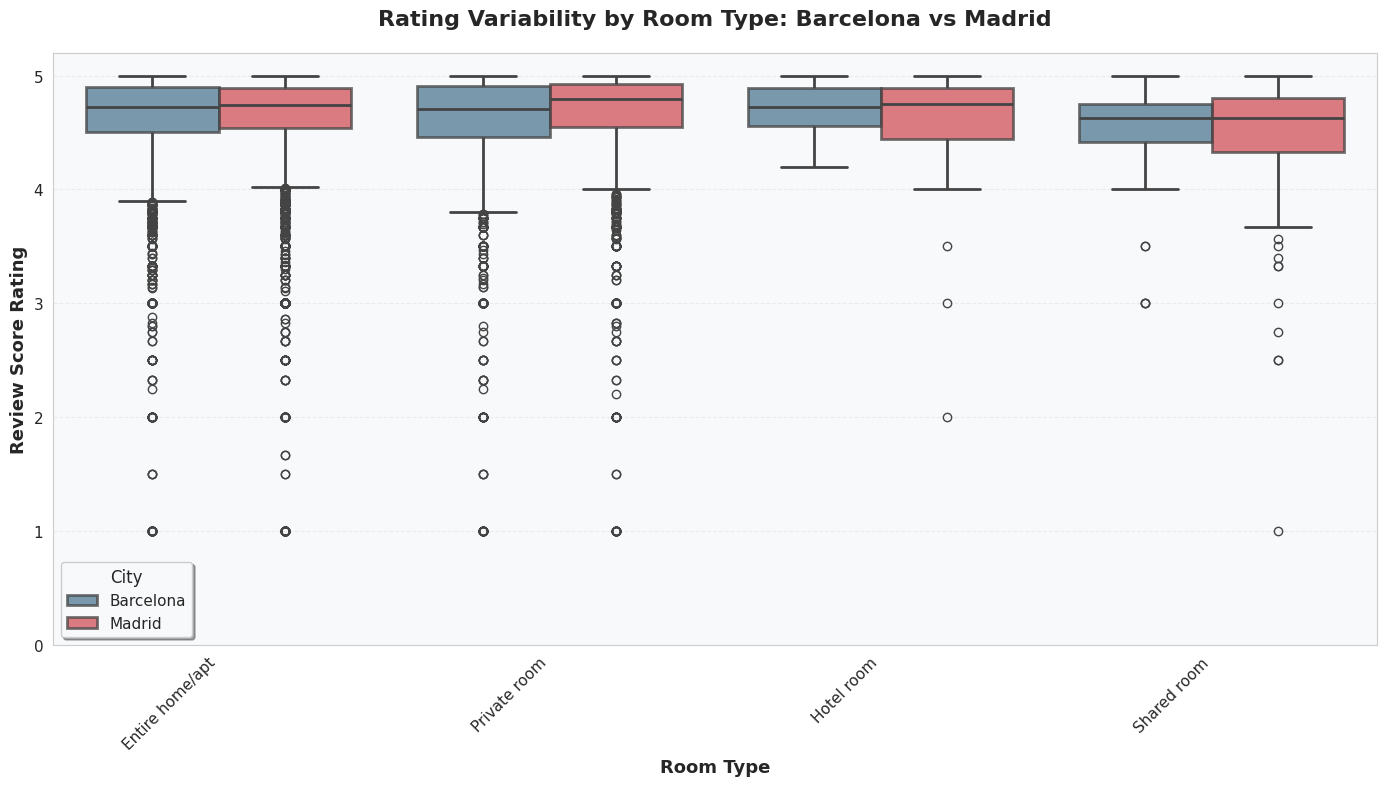

In [ ]:
# Create enhanced boxplot for rating variability
fig, ax = plt.subplots(figsize=(14, 8))

city_palette = {'Barcelona': COLORS['barcelona'], 'Madrid': COLORS['madrid']}
box_plot = sns.boxplot(data=filtered_data, x='room_type', y='review_scores_rating',
                       hue='City', palette=city_palette, ax=ax, linewidth=2)

# Enhance visual appearance
for patch in ax.patches:
    patch.set_alpha(0.75)

ax.set_title('Rating Variability by Room Type: Barcelona vs Madrid',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Room Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Review Score Rating', fontsize=13, fontweight='bold')
ax.set_ylim(0, 5.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='City', fontsize=11, title_fontsize=12, frameon=True, shadow=True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Let's check the data distribution for each room type
print("Data counts by room type and city:")
print(filtered_data.groupby(['room_type', 'City']).size())
print("\n" + "="*60 + "\n")

# Check basic statistics for each room type
for room_type in filtered_data['room_type'].unique():
    print(f"\n{room_type}:")
    room_data = filtered_data[filtered_data['room_type'] == room_type]
    print(f"  Total count: {len(room_data)}")
    print(f"  Rating range: {room_data['review_scores_rating'].min():.2f} - {room_data['review_scores_rating'].max():.2f}")
    print(f"  Mean rating: {room_data['review_scores_rating'].mean():.2f}")
    print(f"  Std deviation: {room_data['review_scores_rating'].std():.2f}")

    # Check for outliers by city
    for city in ['Barcelona', 'Madrid']:
        city_room_data = room_data[room_data['City'] == city]
        if len(city_room_data) > 0:
            q1 = city_room_data['review_scores_rating'].quantile(0.25)
            q3 = city_room_data['review_scores_rating'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = city_room_data[(city_room_data['review_scores_rating'] < lower_bound) |
                                      (city_room_data['review_scores_rating'] > upper_bound)]
            print(f"  {city}: {len(city_room_data)} properties, {len(outliers)} outliers")

Data counts by room type and city:
room_type        City     
Entire home/apt  Barcelona     8405
                 Madrid       11641
Hotel room       Barcelona       50
                 Madrid          40
Private room     Barcelona     3142
                 Madrid        3866
Shared room      Barcelona       87
                 Madrid         128
dtype: int64



Entire home/apt:
  Total count: 20046
  Rating range: 1.00 - 5.00
  Mean rating: 4.63
  Std deviation: 0.47
  Barcelona: 8405 properties, 351 outliers
  Madrid: 11641 properties, 845 outliers

Private room:
  Total count: 7008
  Rating range: 1.00 - 5.00
  Mean rating: 4.60
  Std deviation: 0.56
  Barcelona: 3142 properties, 227 outliers
  Madrid: 3866 properties, 220 outliers

Hotel room:
  Total count: 90
  Rating range: 2.00 - 5.00
  Mean rating: 4.65
  Std deviation: 0.43
  Barcelona: 50 properties, 0 outliers
  Madrid: 40 properties, 3 outliers

Shared room:
  Total count: 215
  Rating range: 1.00 - 5.00
  Mean rating: 4.

In [ ]:
# Let's look at the actual low ratings in hotel rooms and shared rooms
print("Hotel rooms with ratings below 4.0:")
hotel_low = filtered_data[(filtered_data['room_type'] == 'Hotel room') &
                           (filtered_data['review_scores_rating'] < 4.0)]
print(f"Count: {len(hotel_low)}")
for city in ['Barcelona', 'Madrid']:
    city_data = hotel_low[hotel_low['City'] == city]
    if len(city_data) > 0:
        print(f"\n{city}:")
        print(city_data[['City', 'review_scores_rating']].sort_values('review_scores_rating'))

print("\n" + "="*60)
print("\nShared rooms with ratings below 4.0:")
shared_low = filtered_data[(filtered_data['room_type'] == 'Shared room') &
                            (filtered_data['review_scores_rating'] < 4.0)]
print(f"Count: {len(shared_low)}")
for city in ['Barcelona', 'Madrid']:
    city_data = shared_low[shared_low['City'] == city]
    if len(city_data) > 0:
        print(f"\n{city}:")
        print(city_data[['City', 'review_scores_rating']].sort_values('review_scores_rating'))

print("\n" + "="*60)
print("\nBarcelona Hotel Rooms - Full distribution:")
bcn_hotels = filtered_data[(filtered_data['room_type'] == 'Hotel room') &
                            (filtered_data['City'] == 'Barcelona')]
print(f"Q1: {bcn_hotels['review_scores_rating'].quantile(0.25):.2f}")
print(f"Q3: {bcn_hotels['review_scores_rating'].quantile(0.75):.2f}")
print(f"IQR: {bcn_hotels['review_scores_rating'].quantile(0.75) - bcn_hotels['review_scores_rating'].quantile(0.25):.2f}")
print(f"Lower outlier bound: {bcn_hotels['review_scores_rating'].quantile(0.25) - 1.5 * (bcn_hotels['review_scores_rating'].quantile(0.75) - bcn_hotels['review_scores_rating'].quantile(0.25)):.2f}")
print(f"Minimum rating: {bcn_hotels['review_scores_rating'].min():.2f}")

Hotel rooms with ratings below 4.0:
Count: 3

Madrid:
         City  review_scores_rating
33535  Madrid                   2.0
17182  Madrid                   3.0
17581  Madrid                   3.5


Shared rooms with ratings below 4.0:
Count: 17

Barcelona:
            City  review_scores_rating
5791   Barcelona                   3.0
6304   Barcelona                   3.0
12205  Barcelona                   3.0
4876   Barcelona                   3.5
5794   Barcelona                   3.5

Madrid:
         City  review_scores_rating
33253  Madrid                  1.00
31651  Madrid                  2.50
31675  Madrid                  2.50
31555  Madrid                  2.75
31657  Madrid                  3.00
31669  Madrid                  3.33
26174  Madrid                  3.33
22421  Madrid                  3.40
28851  Madrid                  3.50
25739  Madrid                  3.56
26333  Madrid                  3.67
26180  Madrid                  3.77


Barcelona Hotel Rooms - Full

**Rating Variability Patterns**

The boxplots reveal consistent satisfaction across all room types, with most ratings clustered between 4.0 and 5.0. However, spread patterns vary notably by accommodation format.

**Room Type Performance**

Entire homes and private rooms show tight rating distributions (4.5 to 5.0), with several outliars ranging from 1 to 4 stars. Whilst Hotel rooms and Shared rooms, probably because they have much less data, don't show that many outliars and have a generally tighter overall distributions between 4 and 5 stars.

**City Comparison**

Madrid demonstrates narrower distributions across the first two categories, pointing to more consistent property standards. Whilst private rooms in Barcelona particularly seem to have slightly fewer low-rating outliers, but a higher spread of the ratings. Madrid shows that in Hotel rooms and Shared rooms, lower ratings are more frequent.

Both cities follow similar variability patterns across room types, with differences in magnitude rather than structure.

In [ ]:
# Calculate room type counts (using all properties, not just those with reviews, since we're counting supply)
room_type_counts_madrid = madrid_listings['room_type'].value_counts()
room_type_counts_barcelona = barcelona_listings['room_type'].value_counts()
combined_room_type_counts = combined_listings['room_type'].value_counts()

# Create DataFrame for visualization
room_type_data = pd.DataFrame({
    'Room Type': room_type_counts_barcelona.index,
    'Barcelona': room_type_counts_barcelona.values,
    'Madrid': room_type_counts_madrid.values,
    'Total': combined_room_type_counts.values
}).melt(id_vars=['Room Type'], var_name='City', value_name='Count')

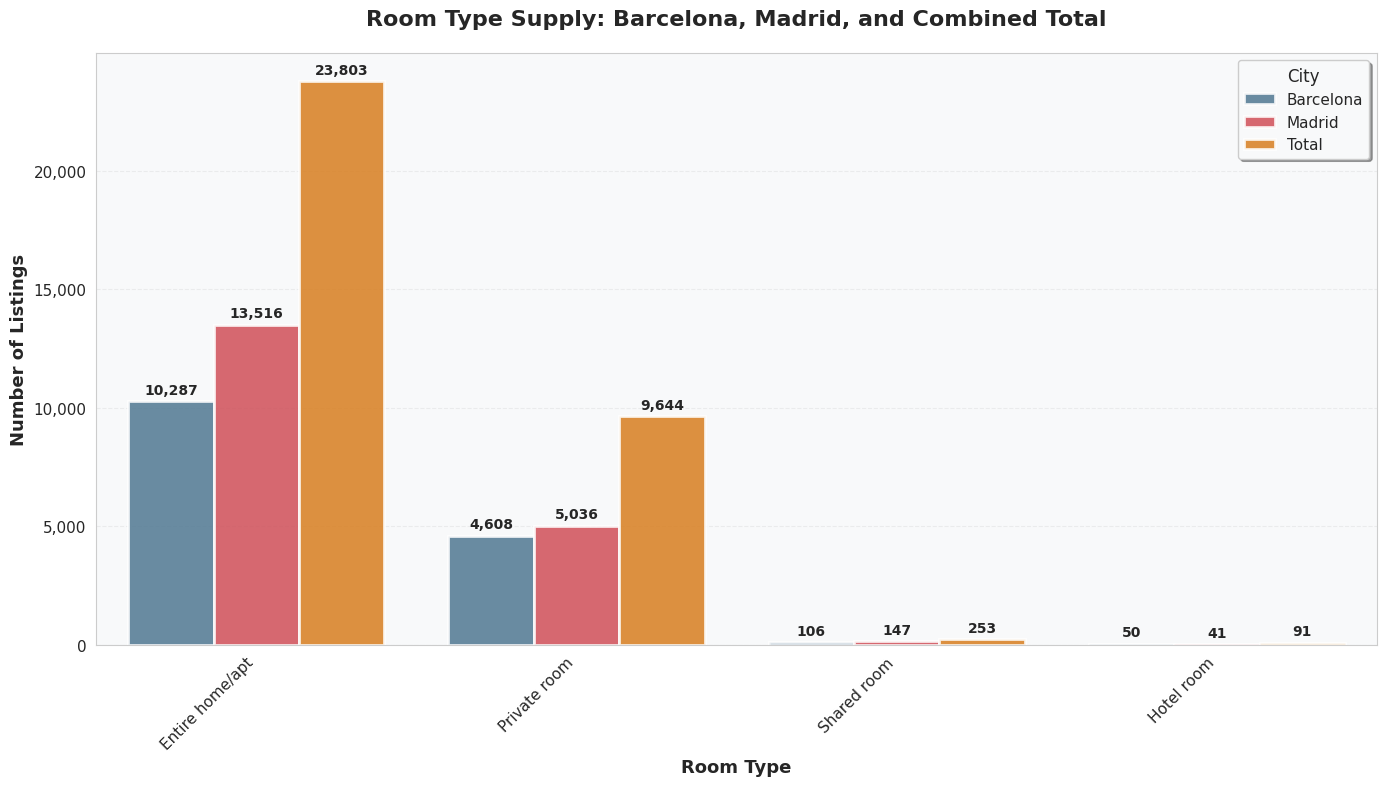

In [ ]:
# Create enhanced visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Define color palette
palette_colors = {'Barcelona': COLORS['barcelona'], 'Madrid': COLORS['madrid'], 'Total': COLORS['accent']}
bar_plot = sns.barplot(data=room_type_data, x='Room Type', y='Count', hue='City',
                       palette=palette_colors, ax=ax, alpha=0.85, edgecolor='white', linewidth=2)

# Add value labels on bars
for container in ax.containers:
    labels = [f'{int(v.get_height()):,}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, padding=3, fontsize=10, fontweight='bold')

ax.set_title('Room Type Supply: Barcelona, Madrid, and Combined Total',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Room Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Listings', fontsize=13, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='City', fontsize=11, title_fontsize=12, loc='upper right', frameon=True, shadow=True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Supply Concentration**

Entire homes and apartments dominate inventory in both cities. Madrid holds 13,516 listings versus Barcelona's 10,287, establishing entire homes as the primary accommodation format. Private rooms rank second with Madrid (5,036) slightly ahead of Barcelona (4,608), representing a meaningful market segment for budget travelers and shorter stays.

Shared rooms and hotel rooms comprise a minimal fraction of total supply: 253 shared rooms and 91 hotel rooms combined. This limited inventory suggests either constrained demand or restricted supply channels, positioning these formats as niche offerings rather than core market products.

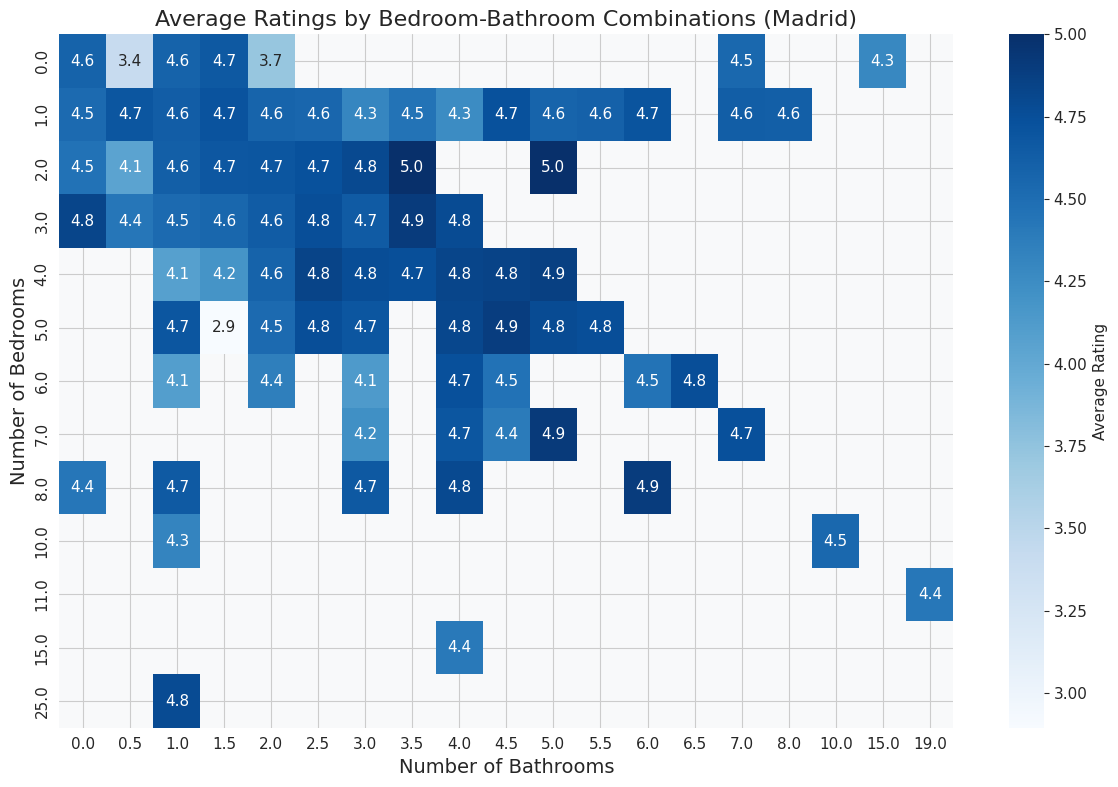

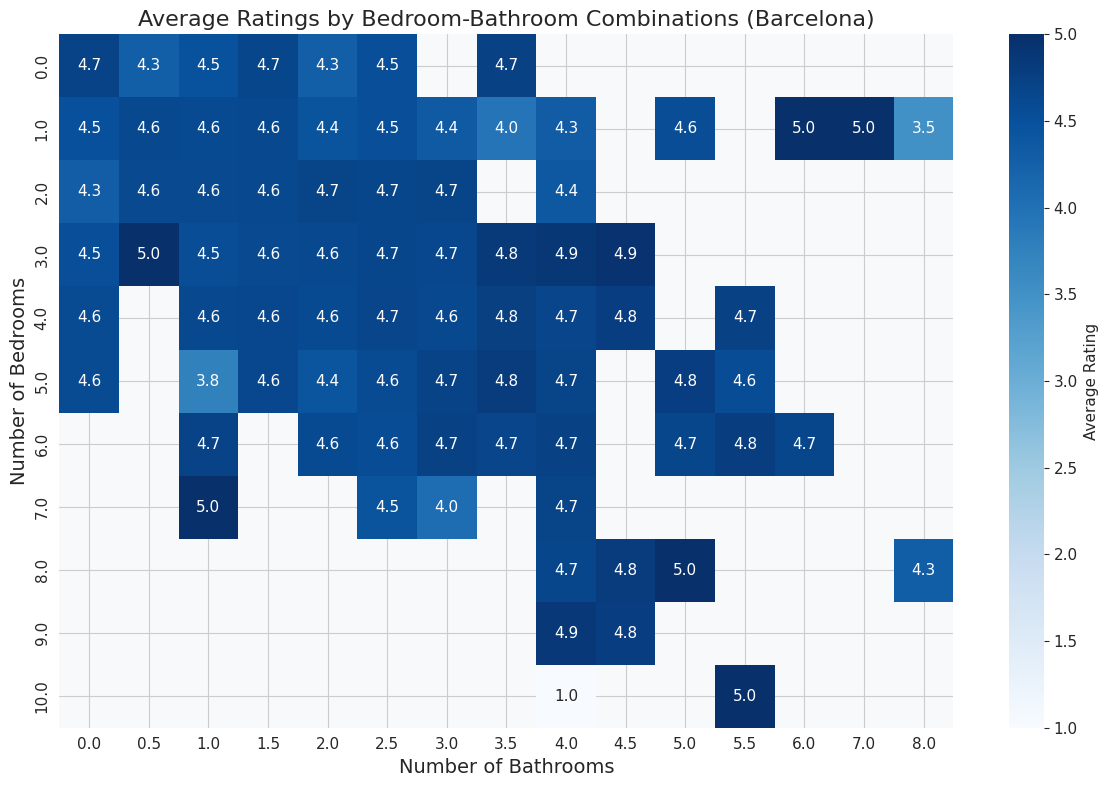

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for each city (excluding properties with no reviews)
madrid_data = combined_listings[(combined_listings['City'] == 'Madrid') & (combined_listings['review_scores_rating'] > 0)]
barcelona_data = combined_listings[(combined_listings['City'] == 'Barcelona') & (combined_listings['review_scores_rating'] > 0)]

# Create pivot tables for each city
madrid_heatmap_data = madrid_data.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='review_scores_rating',
    aggfunc='mean'
)
barcelona_heatmap_data = barcelona_data.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='review_scores_rating',
    aggfunc='mean'
)

# Heatmap for Madrid
plt.figure(figsize=(12, 8))
sns.heatmap(madrid_heatmap_data, annot=True, fmt=".1f", cmap='Blues', cbar_kws={'label': 'Average Rating'})
plt.title('Average Ratings by Bedroom-Bathroom Combinations (Madrid)', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Number of Bedrooms', fontsize=14)
plt.tight_layout()
plt.show()

# Heatmap for Barcelona
plt.figure(figsize=(12, 8))
sns.heatmap(barcelona_heatmap_data, annot=True, fmt=".1f", cmap='Blues', cbar_kws={'label': 'Average Rating'})
plt.title('Average Ratings by Bedroom-Bathroom Combinations (Barcelona)', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Number of Bedrooms', fontsize=14)
plt.tight_layout()
plt.show()


**Guest Satisfaction and Bathroom Configurations**

Note: we'll assume that those with 0 bedrooms are studios with the living and sleeping area in the same place. Whilst those with 0 bathrooms we can assume that have shared facilities.

**Madrid Guest Expectations**

Madrid ratings show relatively consistent performance across most bedroom-bathroom combinations, typically ranging from 4.5 to 4.8. There are no dramatic patterns suggesting guests heavily penalize specific configurations.

Notable observations: Properties with 0 bedrooms and 0.5 bathrooms score lower (3.4), likely studio apartments with minimal facilities. The most common configurations (1-3 bedrooms with 1-2 bathrooms) consistently score between 4.5 and 4.7.

**Barcelona Guest Expectations**

Barcelona shows similarly stable ratings across standard configurations, with most properties scoring between 4.5 and 4.8. There's no clear evidence that adding bathrooms significantly improves ratings.

Notable observations: Some unusual configurations score poorly, like 5 bedrooms with 1 bathroom (3.8) or 1 bedroom with 8 bathrooms (3.5), but these represent tiny sample sizes and likely have other issues that justify said rating apart from the weird layouts. Standard 2-3 bedroom properties with 1-2 bathrooms consistently score 4.6 to 4.7 regardless of the exact bathroom count.

**What This Means for Investment**

There's no strong correlation between bedroom-bathroom ratios and guest ratings in either city. Ratings remain remarkably consistent (4.5-4.8) across most standard configurations. This suggests that bathroom count alone doesn't drive satisfaction. Guests care more about other factors like cleanliness, location, amenities, and host quality.

The few low-rated cells (like extreme configurations with 50+ bedrooms or mismatched ratios) have very small sample sizes and likely reflect specific property problems rather than the configuration itself.

**Investment recommendation:** Focus on standard configurations (0-3 bedrooms, 0-2 bathrooms) where you have reliable data. Don't over-invest in extra bathrooms expecting higher ratings. Instead, prioritize overall quality, cleanliness, and amenities that the earlier models showed actually matter for pricing and satisfaction.

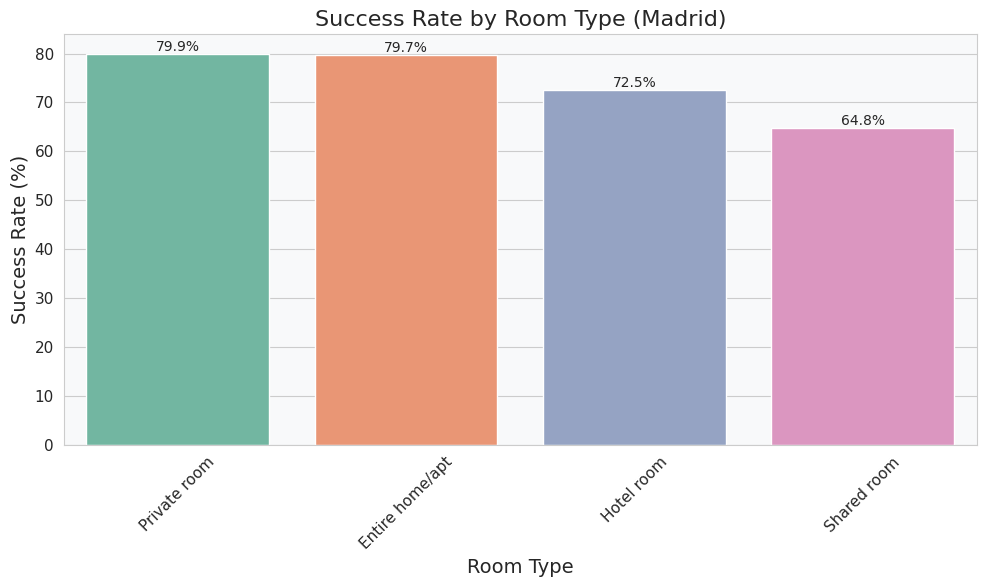

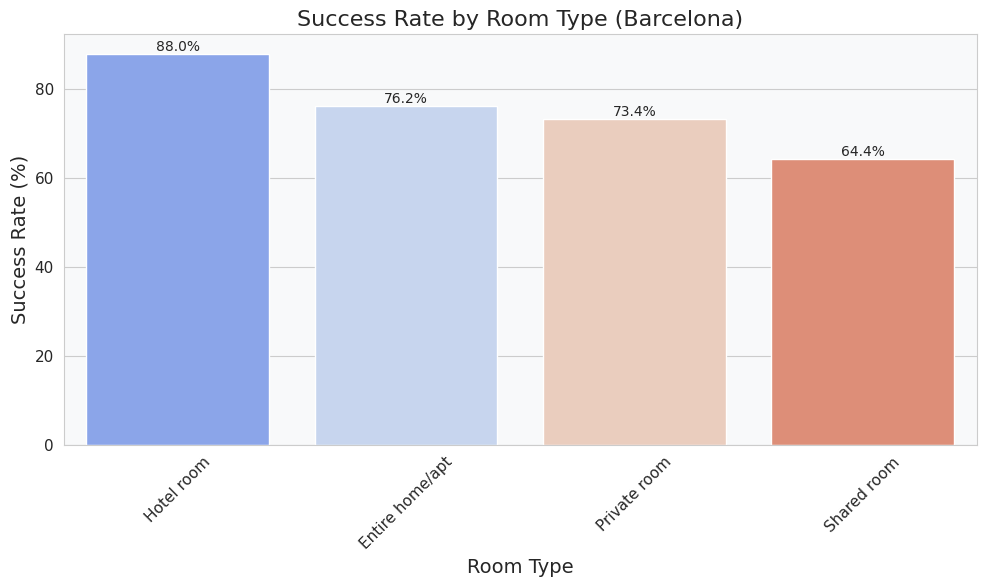

In [ ]:
# Define high rating threshold
high_rating_threshold = 4.5

# Filter to only reviewed listings (exclude review_scores_rating = 0)
madrid_reviewed = madrid_listings[madrid_listings['review_scores_rating'] > 0]
barcelona_reviewed = barcelona_listings[barcelona_listings['review_scores_rating'] > 0]

# Filter data for Madrid and Barcelona
success_rate_madrid = madrid_reviewed.groupby('room_type')['review_scores_rating'].apply(
    lambda x: (x >= high_rating_threshold).mean() * 100
).reset_index()
success_rate_barcelona = barcelona_reviewed.groupby('room_type')['review_scores_rating'].apply(
    lambda x: (x >= high_rating_threshold).mean() * 100
).reset_index()

# Rename columns for clarity
success_rate_madrid.columns = ['Room Type', 'Success Rate (%)']
success_rate_barcelona.columns = ['Room Type', 'Success Rate (%)']

# Sort by success rate in descending order
success_rate_madrid = success_rate_madrid.sort_values(by='Success Rate (%)', ascending=False)
success_rate_barcelona = success_rate_barcelona.sort_values(by='Success Rate (%)', ascending=False)

# Plot for Madrid
plt.figure(figsize=(10, 6))
ax_madrid = sns.barplot(data=success_rate_madrid, x='Room Type', y='Success Rate (%)', hue='Room Type', palette='Set2', legend=False)
for p in ax_madrid.patches:
    ax_madrid.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )
plt.title('Success Rate by Room Type (Madrid)', fontsize=16)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xlabel('Room Type', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Barcelona
plt.figure(figsize=(10, 6))
ax_barcelona = sns.barplot(data=success_rate_barcelona, x='Room Type', y='Success Rate (%)', hue='Room Type', palette='coolwarm', legend=False)
for p in ax_barcelona.patches:
    ax_barcelona.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )
plt.title('Success Rate by Room Type (Barcelona)', fontsize=16)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xlabel('Room Type', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Definition of Success Rate**: it measures guest satisfaction quality by calculating the percentage of listings within each room type that achieve a review score of 4.5 or higher (on a 0-5 scale). This metric only includes properties that have received reviews, so it reflects quality performance among active listings with guest feedback.

**Formula:** (Count of listings with rating ≥ 4.5) / (Total listings in room type with ratings) × 100%

**Madrid Success Rates**

Private rooms and entire homes lead with nearly identical success rates at 79.9% and 79.7% respectively, reflecting strong guest satisfaction across these accommodation types. Hotel rooms achieve a solid 72.5% success rate, demonstrating consistent quality performance. Shared rooms lag behind at 64.8%, suggesting that privacy concerns or facility limitations impact guest satisfaction in this category.

**Barcelona Success Rates**

Hotel rooms significantly outperform all other categories with an impressive 88.0% success rate, indicating exceptional guest satisfaction potentially driven by superior location, services, or professional management. Entire homes and apartments achieve a strong 76.2% success rate, highlighting sustained demand and quality for independent accommodations. Private rooms follow at 73.4%, offering good value for budget-conscious travelers. Shared rooms record the lowest rate at 64.4%, with privacy concerns or insufficient amenities likely limiting guest satisfaction.

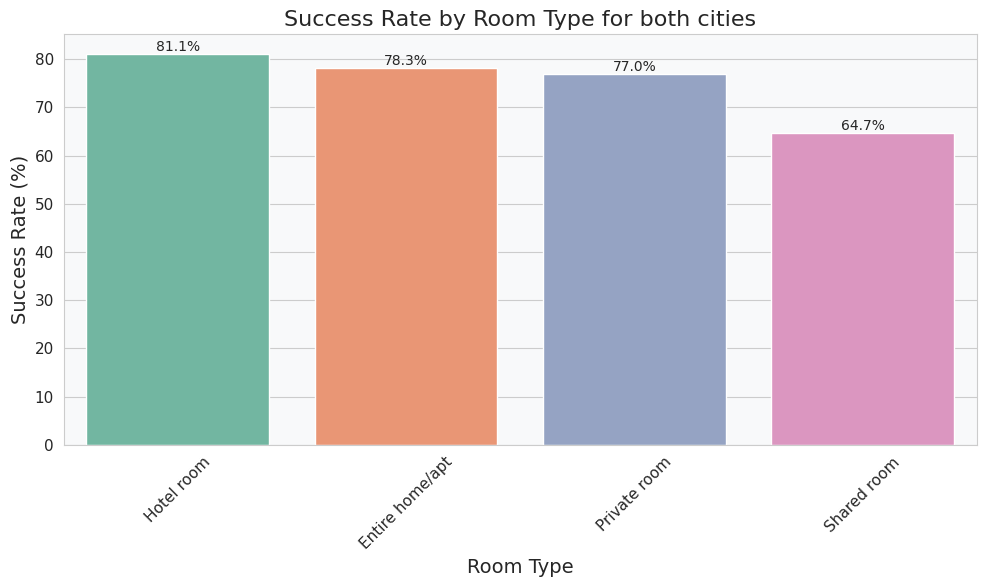

In [ ]:
# Define high rating threshold
high_rating_threshold = 4.5

# Filter for reviewed properties only
reviewed_listings = combined_listings[combined_listings['review_scores_rating'] > 0]

# Calculate success rate by room type (only for properties with reviews)
success_rate = reviewed_listings.groupby('room_type')['review_scores_rating'].apply(
    lambda x: (x >= high_rating_threshold).mean() * 100
).reset_index()

# Rename columns for clarity
success_rate.columns = ['Room Type', 'Success Rate (%)']

# Sort by success rate in descending order
success_rate = success_rate.sort_values(by='Success Rate (%)', ascending=False)

# Visualize success rate
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=success_rate, x='Room Type', y='Success Rate (%)', hue='Room Type', palette='Set2', legend=False)

# Annotate success rates on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",  # Format the success rate
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the center of the bar
        ha='center', va='bottom', fontsize=10
    )

# Customize the plot
plt.title('Success Rate by Room Type for both cities', fontsize=16)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xlabel('Room Type', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Hotel rooms have the highest combined success rate at 81.1%, followed by entire homes at 78.3% and private rooms at 77.0%. Shared rooms achieve 64.7%, the lowest but still respectable.

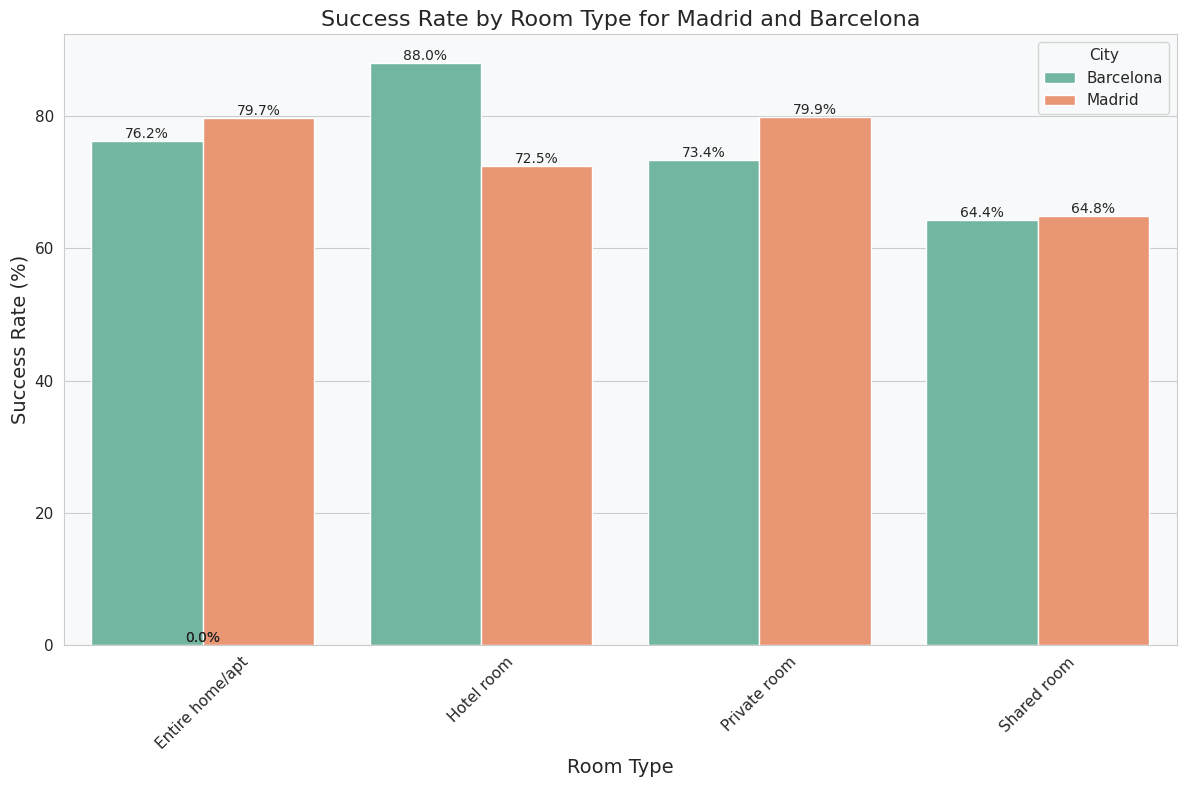

In [ ]:
# Define high rating threshold
high_rating_threshold = 4.5

# Filter for reviewed properties only
reviewed_listings_city = combined_listings[combined_listings['review_scores_rating'] > 0]

# Calculate success rate by room type and city (only for properties with reviews)
success_rate_cities = reviewed_listings_city.groupby(['City', 'room_type'])['review_scores_rating'].apply(
    lambda x: (x >= high_rating_threshold).mean() * 100
).reset_index()

# Rename columns for clarity
success_rate_cities.columns = ['City', 'Room Type', 'Success Rate (%)']

# Visualize success rate by city
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=success_rate_cities,
    x='Room Type',
    y='Success Rate (%)',
    hue='City',
    palette='Set2'
)

# Annotate success rates above the columns
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",  # Format success rate as percentage
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Center annotation above bar
        ha='center', va='bottom', fontsize=10
    )

# Customize the plot
plt.title('Success Rate by Room Type for Madrid and Barcelona', fontsize=16)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xlabel('Room Type', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='City')

plt.tight_layout()
plt.show()

Barcelona's hotel rooms lead with an exceptional 88.0% success rate, while Madrid's private rooms and entire homes both achieve approximately 79.7-79.9%. Shared rooms perform consistently around 64-65% in both cities, showing that this category meets guest expectations at similar levels across markets.

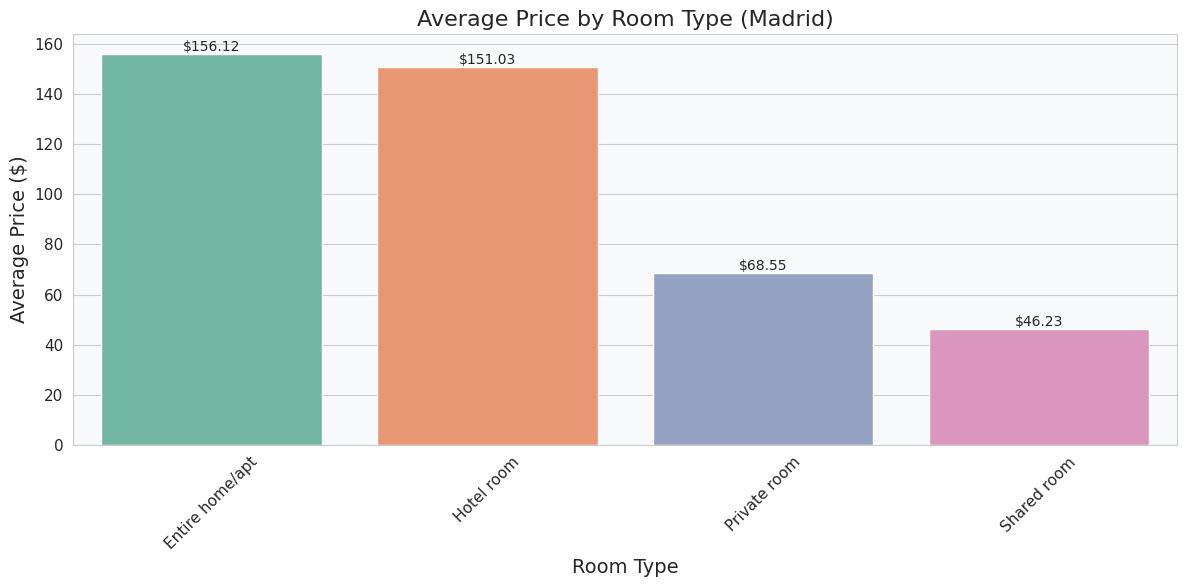

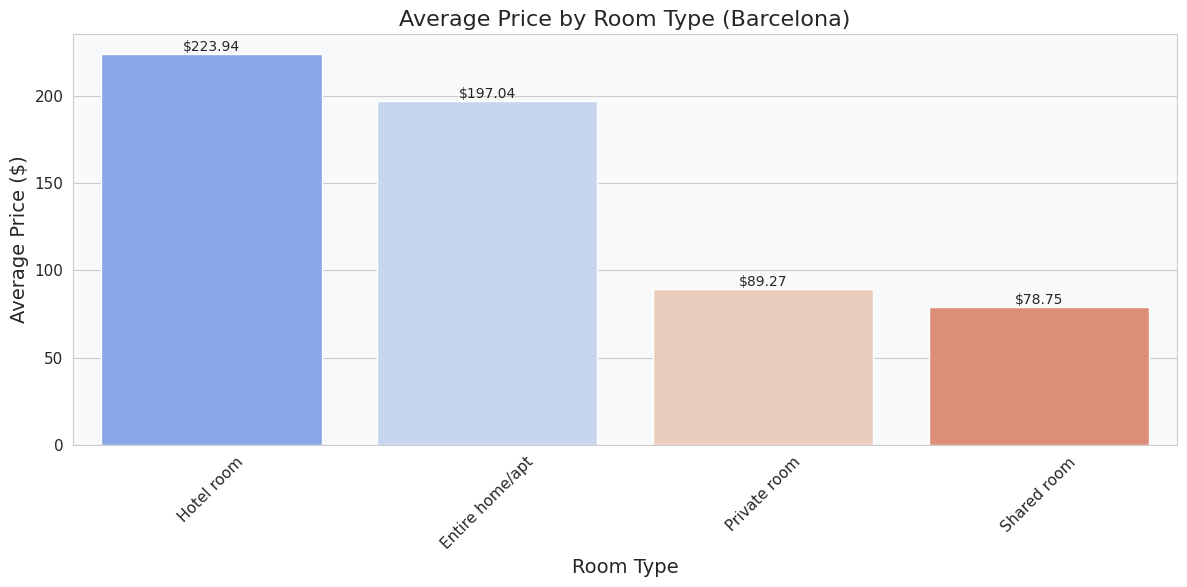

In [ ]:
# Calculate performance metrics for Madrid
# Note: Price is already numeric after Section 1 cleaning, no conversion needed
# Only include properties with reviews (review_scores_rating > 0) for accurate rating averages
madrid_with_reviews = madrid_listings[madrid_listings['review_scores_rating'] > 0]
performance_metrics_madrid = madrid_with_reviews.groupby('room_type').agg({
    'review_scores_rating': 'mean',
    'price': 'mean',
    'id': 'count'
}).reset_index()
performance_metrics_madrid.columns = ['Room Type', 'Average Rating', 'Average Price', 'Number of Properties']
performance_metrics_madrid = performance_metrics_madrid.sort_values(by='Average Price', ascending=False)

# Calculate performance metrics for Barcelona
barcelona_with_reviews = barcelona_listings[barcelona_listings['review_scores_rating'] > 0]
performance_metrics_barcelona = barcelona_with_reviews.groupby('room_type').agg({
    'review_scores_rating': 'mean',
    'price': 'mean',
    'id': 'count'
}).reset_index()
performance_metrics_barcelona.columns = ['Room Type', 'Average Rating', 'Average Price', 'Number of Properties']
performance_metrics_barcelona = performance_metrics_barcelona.sort_values(by='Average Price', ascending=False)

# Visualization for Madrid
plt.figure(figsize=(12, 6))
ax_madrid = sns.barplot(data=performance_metrics_madrid, x='Room Type', y='Average Price', hue='Room Type', palette='Set2', legend=False)
for p in ax_madrid.patches:
    ax_madrid.annotate(
        f"${p.get_height():,.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )
plt.title('Average Price by Room Type (Madrid)', fontsize=16)
plt.ylabel('Average Price ($)', fontsize=14)
plt.xlabel('Room Type', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization for Barcelona
plt.figure(figsize=(12, 6))
ax_barcelona = sns.barplot(data=performance_metrics_barcelona, x='Room Type', y='Average Price', hue='Room Type', palette='coolwarm', legend=False)
for p in ax_barcelona.patches:
    ax_barcelona.annotate(
        f"${p.get_height():,.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )
plt.title('Average Price by Room Type (Barcelona)', fontsize=16)
plt.ylabel('Average Price ($)', fontsize=14)
plt.xlabel('Room Type', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Pricing by Room Type**

Entire homes command the highest average prices in Madrid at $156.12, while hotel rooms lead Barcelona's pricing at $223.94. Barcelona charges significantly more across all categories compared to Madrid, with entire homes at $197.04 versus Madrid's $156.12.

Hotel rooms show interesting price positioning: $151.03 in Madrid (slightly below entire homes) and $223.94 in Barcelona (above entire homes at $197.04). Despite their high success rates, hotel rooms maintain competitive pricing relative to entire homes.

Private and shared rooms remain the most affordable options. Private rooms average $68.55 in Madrid and $89.27 in Barcelona. Shared rooms are the most economical at $46.23 in Madrid and $78.75 in Barcelona.

### **Step 2.2: Impact of Amenities**

The following analysis examines relationships between amenity counts, review scores, and pricing to provide actionable guidance for hosts and investors on amenity investment decisions.

In [ ]:
# Filter for reviewed properties and count amenities per listing
reviewed_listings = combined_listings[combined_listings['review_scores_rating'] > 0].copy()
reviewed_listings['num_amenities'] = reviewed_listings['amenities'].apply(
    lambda x: len(str(x).strip('{}').split(','))
)

# Calculate average ratings by amenity count (excluding unreviewed properties)
amenities_ratings = reviewed_listings.groupby('num_amenities')['review_scores_rating'].mean().reset_index()

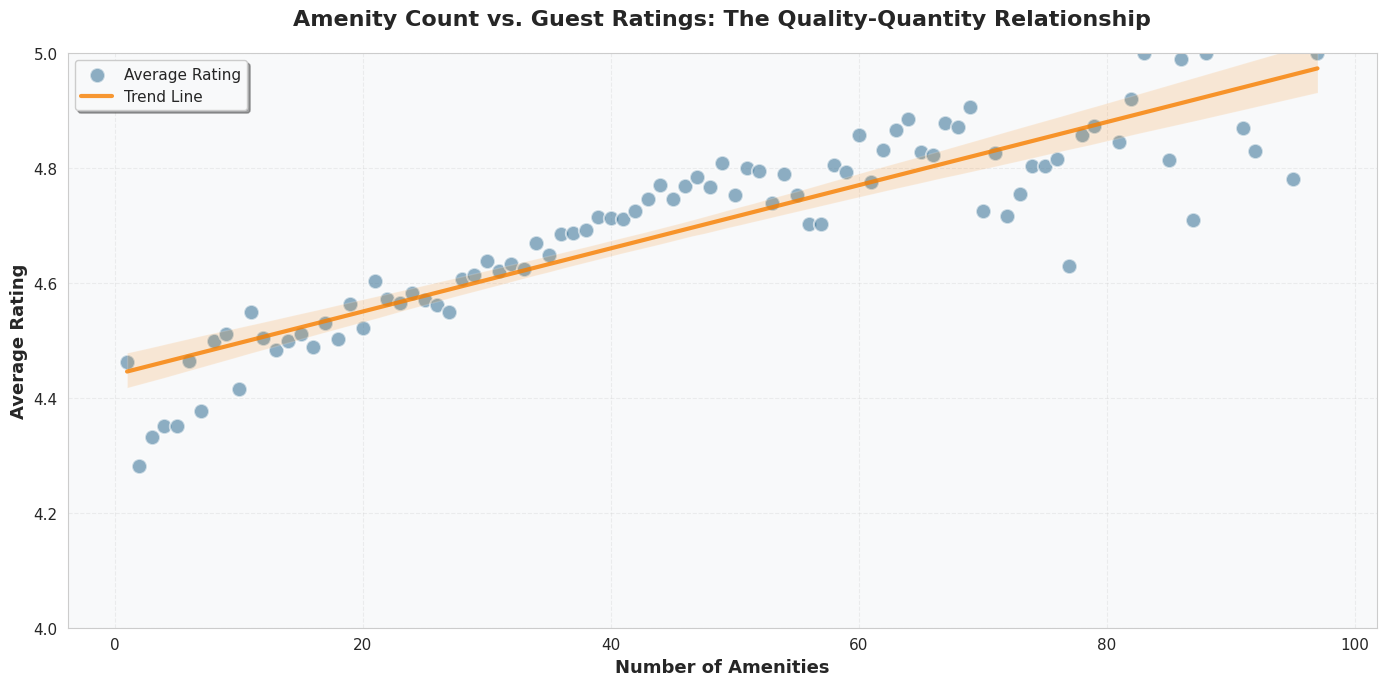

In [ ]:
# Create enhanced scatter plot with regression
fig, ax = plt.subplots(figsize=(14, 7))

# Scatter plot with custom styling
ax.scatter(amenities_ratings['num_amenities'], amenities_ratings['review_scores_rating'],
           s=120, color=COLORS['barcelona'], alpha=0.6, edgecolors='white', linewidth=1.5,
           label='Average Rating')

# Add regression line
sns.regplot(data=amenities_ratings, x='num_amenities', y='review_scores_rating',
            scatter=False, color=COLORS['accent'], line_kws={'linewidth': 3, 'alpha': 0.8},
            ax=ax, label='Trend Line')

ax.set_title('Amenity Count vs. Guest Ratings: The Quality-Quantity Relationship',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Number of Amenities', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Rating', fontsize=13, fontweight='bold')
ax.set_ylim(4.0, 5.0)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

**Amenity Count and Rating Correlation**

The data shows a clear positive correlation between amenity count and average ratings. Properties with fewer than 30 amenities typically achieve ratings between 4.3 and 4.6. As amenity counts increase to 30 to 60, ratings improve noticeably, with properties reaching scores above 4.8.

**Strategic Thresholds**

Providing 30 to 60 well selected amenities can meaningfully boost ratings, especially for properties looking to improve guest satisfaction. However, some high amenity properties still receive lower ratings, showing that quantity alone doesn't guarantee positive reviews. Quality of service, cleanliness, and meeting guest expectations remain equally critical to achieving high satisfaction scores. It's interesting to see that the listings with the most ammenities (>65) have an increased spread of their avg. rating, with some being worse off when ammenities surpass 70.

Preview of the 'amenities' column:
0    ["Pets allowed", "30 inch TV", "Coffee maker",...
1    ["Electric stove", "Toaster", "Wine glasses", ...
2    ["Coffee maker", "Elevator", "Patio or balcony...
3    ["Toaster", "Coffee maker", "Bidet", "Ethernet...
4    ["Dryer", "Cleaning available during stay", "C...
Name: amenities, dtype: object


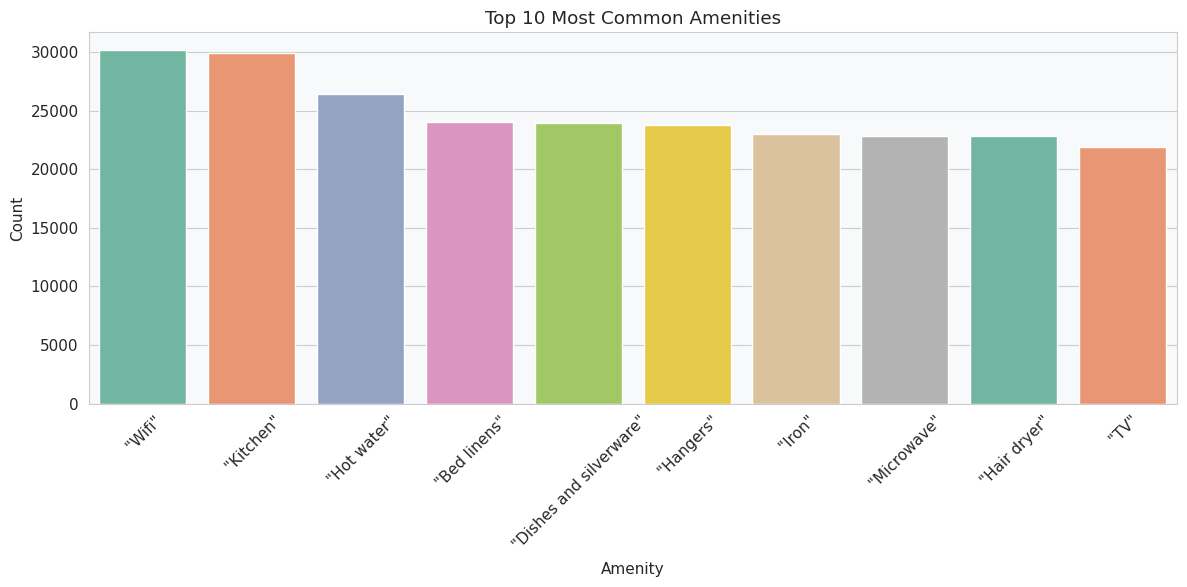

Average Ratings for Properties with and without Wifi:
has_wifi
False    4.692994
True     4.612814
Name: review_scores_rating, dtype: float64


In [ ]:
# Check the structure of the amenities column
print("Preview of the 'amenities' column:")
print(combined_listings['amenities'].head())

# Split amenities into individual items
combined_listings['amenities_list'] = combined_listings['amenities'].apply(lambda x: str(x).strip('{}').split(','))

# Count frequency of each amenity
from collections import Counter
all_amenities = combined_listings['amenities_list'].explode()
amenities_count = Counter(all_amenities)

# Convert to DataFrame for visualization
amenities_df = pd.DataFrame(amenities_count.items(), columns=['Amenity', 'Count']).sort_values(by='Count', ascending=False)

# Plot top 10 amenities
plt.figure(figsize=(12, 6))
sns.barplot(data=amenities_df.head(10), x='Amenity', y='Count', hue='Amenity', palette='Set2', legend=False)
plt.title('Top 10 Most Common Amenities')
plt.xlabel('Amenity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compare ratings for properties with a specific amenity (only for reviewed properties)
specific_amenity = 'Wifi'  # Example
combined_listings['has_wifi'] = combined_listings['amenities'].apply(lambda x: specific_amenity in str(x))

# Filter to only properties with reviews
listings_with_reviews_wifi = combined_listings[combined_listings['review_scores_rating'] > 0]
ratings_wifi = listings_with_reviews_wifi.groupby('has_wifi')['review_scores_rating'].mean()

print("Average Ratings for Properties with and without Wifi:")
print(ratings_wifi)


WiFi and kitchen are the most common amenities with nearly 30,000 properties each offering them, followed by hot water, bed linens, dishes and silverware, hangers, iron, microwave, and hair dryer. Interestingly, properties without WiFi score slightly higher ratings (4.69) compared to those with WiFi (4.61), though this likely reflects the very small sample size of properties without this now-standard amenity rather than WiFi being detrimental to ratings.

The following analysis examines how the presence or absence of these common amenities affects overall rating performance.

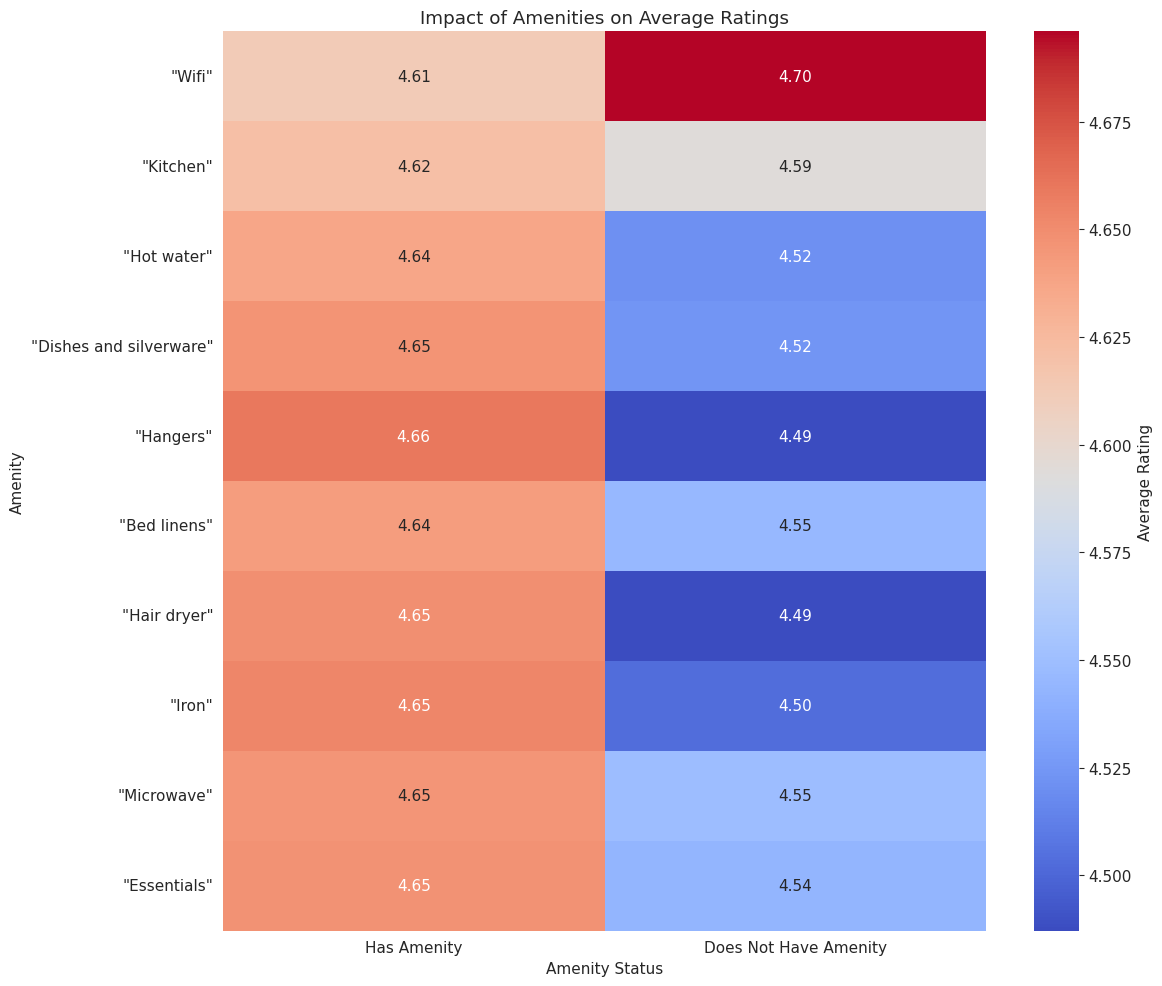

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out properties with no reviews before analysis
listings_with_reviews = combined_listings[combined_listings['review_scores_rating'] > 0].copy()

# Split amenities into individual items
listings_with_reviews['amenities_list'] = listings_with_reviews['amenities'].apply(lambda x: str(x).strip('{}').split(','))

# Expand the amenities list into multiple binary columns (1 if the amenity is present, 0 if not)
amenities_dummies = listings_with_reviews['amenities_list'].explode().str.strip().value_counts()
top_amenities = amenities_dummies.head(10).index  # Focus on the top 10 most common amenities

# Create binary columns for top amenities
for amenity in top_amenities:
    listings_with_reviews[amenity] = listings_with_reviews['amenities'].apply(lambda x: 1 if amenity in str(x) else 0)

# Calculate average ratings for properties with and without each amenity (excluding unreviewed properties)
amenities_ratings = pd.DataFrame({
    amenity: [
        listings_with_reviews[listings_with_reviews[amenity] == 1]['review_scores_rating'].mean(),
        listings_with_reviews[listings_with_reviews[amenity] == 0]['review_scores_rating'].mean()
    ] for amenity in top_amenities
}).T

amenities_ratings.columns = ['Has Amenity', 'Does Not Have Amenity']

# Heatmap visualization of ratings by amenities
plt.figure(figsize=(12, 10))
sns.heatmap(amenities_ratings, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Average Rating'})
plt.title('Impact of Amenities on Average Ratings')
plt.xlabel('Amenity Status')
plt.ylabel('Amenity')
plt.tight_layout()
plt.show()


**Amenity Impact on Ratings**

The relationship between amenities and ratings reveals a counterintuitive pattern. Properties **without** WiFi actually score slightly higher (4.70) than those with it (4.61). Similarly, properties lacking kitchens score marginally better (4.59 vs 4.62). This suggests these amenities are so standard that their presence is expected rather than valued, while their absence might indicate specialty properties that compensate with a superior or unique service.

However, the pattern flips for convenience amenities. Properties **with** hangers, hair dryers, irons, microwaves, and essentials score higher (4.65-4.66) than those without them (4.49-4.55). This suggests these "nice to have" items genuinely improve guest experience because they're not universally expected.

The most dramatic impact is hot water and dishes/silverware, where having them scores 4.64-4.65 versus 4.52 without. These are baseline necessities, and their absence significantly hurts ratings.

**Focus on What Matters**

The data reveals a hierarchy of amenity importance. Basic necessities like hot water and dishes are non-negotiable. Convenience items like hangers, hair dryers, and irons provide meaningful rating boosts because guests appreciate the thoughtfulness. Meanwhile, standard amenities like WiFi and kitchens have become so expected that having them doesn't boost ratings, though lacking them in the wrong property type could hurt.

**Investment Strategy**

Don't chase amenity quantity. Instead, ensure you have all baseline necessities covered, then add thoughtful convenience items that show attention to guest comfort. Focus your resources on service quality, cleanliness, and overall experience, which the earlier models showed matter more than amenity count alone. The goal is meeting expectations efficiently, not exceeding them expensively.

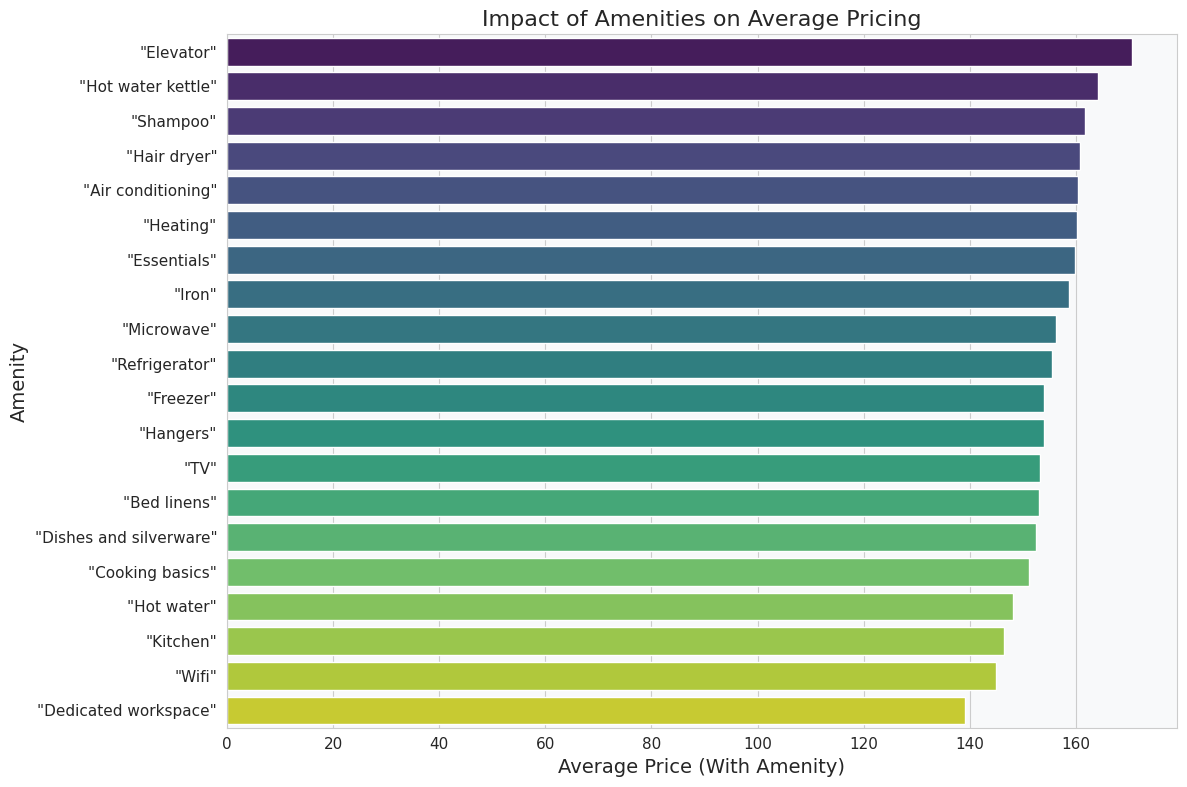

In [ ]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Split amenities into individual items and count their frequency
combined_listings['amenities_list'] = combined_listings['amenities'].apply(lambda x: str(x).strip('{}').split(','))
all_amenities = combined_listings['amenities_list'].explode().str.strip()
amenities_count = Counter(all_amenities)

# Focus on the top 20 most common amenities
top_amenities = [amenity for amenity, count in amenities_count.most_common(20)]

# Create binary columns for top amenities
for amenity in top_amenities:
    combined_listings[amenity] = combined_listings['amenities'].apply(lambda x: 1 if amenity in str(x) else 0)

# Analyze the impact of amenities on price
amenities_analysis = pd.DataFrame({
    'Amenity': top_amenities,
    'Average Price (With Amenity)': [
        combined_listings[combined_listings[amenity] == 1]['price'].mean() for amenity in top_amenities
    ],
    'Average Price (Without Amenity)': [
        combined_listings[combined_listings[amenity] == 0]['price'].mean() for amenity in top_amenities
    ]
})

# Order by average price (with the amenity)
amenities_analysis = amenities_analysis.sort_values(by='Average Price (With Amenity)', ascending=False)

# Visualize the impact on pricing
plt.figure(figsize=(12, 8))
sns.barplot(data=amenities_analysis, x='Average Price (With Amenity)', y='Amenity', hue='Amenity', palette='viridis', legend=False)
plt.title('Impact of Amenities on Average Pricing', fontsize=16)
plt.xlabel('Average Price (With Amenity)', fontsize=14)
plt.ylabel('Amenity', fontsize=14)
plt.tight_layout()
plt.show()


**Understanding the Data**

The relationship between amenities and pricing is often indirect. Elevators don't independently add €20 to nightly rates. Instead, they signal premium properties in modern buildings with higher land values. Similarly, kitchens correlate with larger properties that already command higher prices. Many amenities reflect property type and location rather than directly driving pricing.

**Investment Priorities**

Focus capital on premium amenities that signal quality. Elevators, hot water kettles, and shampoo command the highest average prices (€165-170), indicating well-maintained, upscale properties. Air conditioning, heating, and hair dryers follow closely (€160-165), particularly valuable in cities with temperature extremes.

Mid-tier amenities like essentials, irons, microwaves, and refrigerators cluster around €155-160. These are functionally important but don't dramatically differentiate pricing. Kitchen amenities and WiFi sit lower (€145-150) because they're so universal that their presence is expected rather than valued.

Basic amenities are non-negotiable. Hot water, dishes, and WiFi may not boost pricing, but their absence deters bookings and lowers satisfaction. Always include baseline necessities.

**Actionable Strategy**

For new investments, prioritize locations and properties with built-in premium signals like elevator buildings and climate control. For existing properties, add low-cost convenience amenities like shampoo, hair dryers, and kitchen essentials. These align your property with higher-priced comparables without major capital expenditure.

Now lets go into Beds, Accommodates and Pricing

The following heatmap examines correlations between bed count, accommodates capacity, and ratings. We expect a positive and strong correlation between beds and accommodates, but the relationship between these variables and ratings remains uncertain.

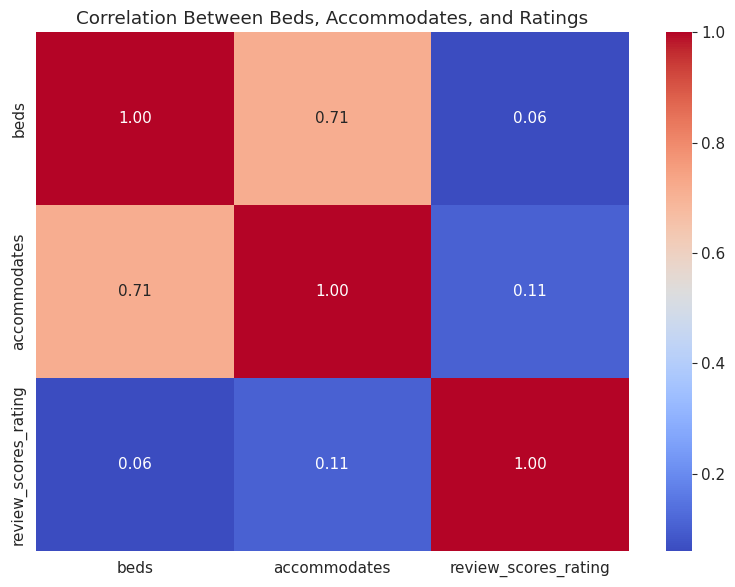

In [ ]:
# Calculate correlation matrix
correlation_matrix = combined_listings[['beds', 'accommodates', 'review_scores_rating']].corr()

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Beds, Accommodates, and Ratings')
plt.tight_layout()
plt.show()


**Correlation Findings**

The correlation between beds and accommodates reaches 0.71, confirming a strong positive relationship. More beds directly enable higher guest capacity, as expected. However, beds (correlation of 0.06) and accommodates (correlation of 0.11) show virtually no correlation with review scores. This indicates guest capacity does not significantly impact satisfaction or ratings.

**Rating Independence**

Ratings appear independent of property size measured by beds and guest capacity. This highlights that factors beyond capacity drive guest satisfaction, including cleanliness, amenities, and service quality. Since ratings remain unaffected by bed count or capacity, enhancing amenities or guest experience likely generates more meaningful improvements in review performance than expanding property size.

The following heatmap examines whether mismatches between listed capacity and actual sleeping arrangements affect ratings. Some hosts may advertise capacity for 9 guests but provide adequate sleeping space for only 4, forcing guests to use sofas or floors. The analysis tests whether such discrepancies correlate with lower ratings.

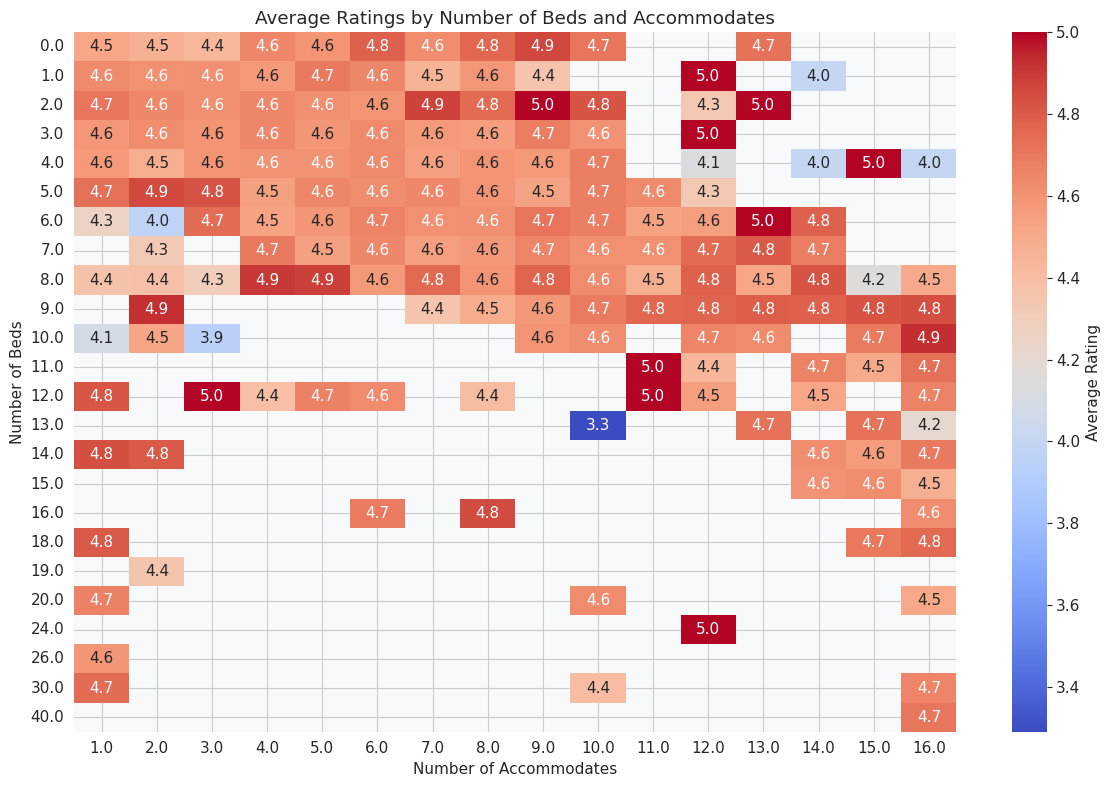

In [ ]:
# Group by beds and accommodates (excluding properties with no reviews)
grouped_data = combined_listings[combined_listings['review_scores_rating'] > 0]
grouped_ratings = grouped_data.groupby(['beds', 'accommodates'])['review_scores_rating'].mean().reset_index()

# Pivot for heatmap visualization
grouped_pivot = grouped_ratings.pivot(index='beds', columns='accommodates', values='review_scores_rating')

# Heatmap of average ratings
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_pivot, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Average Rating'})
plt.title('Average Ratings by Number of Beds and Accommodates')
plt.xlabel('Number of Accommodates')
plt.ylabel('Number of Beds')
plt.tight_layout()
plt.show()


**Rating Distribution**

Most bed and capacity combinations achieve ratings between 4.5 and 5.0, indicating general guest satisfaction regardless of bed to capacity ratios. The hypothesis that mismatched configurations lead to lower ratings is not strongly supported by the data.

**Optimal Configurations**

Properties with 1 to 5 guests and 1 to 5 beds consistently achieve high ratings of 4.5 to 4.9, likely because the bed to capacity ratio meets expectations effectively. Larger properties with 5 or more guests and adequate beds (5 to 8 beds) also maintain strong ratings, successfully meeting the needs of larger groups.

**Outlier Patterns**

Some configurations show significantly lower ratings, including 3 guests with 10 beds (rating of 3.9), 6 beds with 2 guests (rating of 4.0), and 13 beds with 10 guests (rating of 3.3). These outliers likely reflect poor service quality or mismatched guest expectations rather than bed count itself. The small number of properties in these extreme configurations makes them statistically unreliable.

**Investment Strategy**

Focus on smaller properties accommodating 1 to 5 guests with 1 to 5 beds.

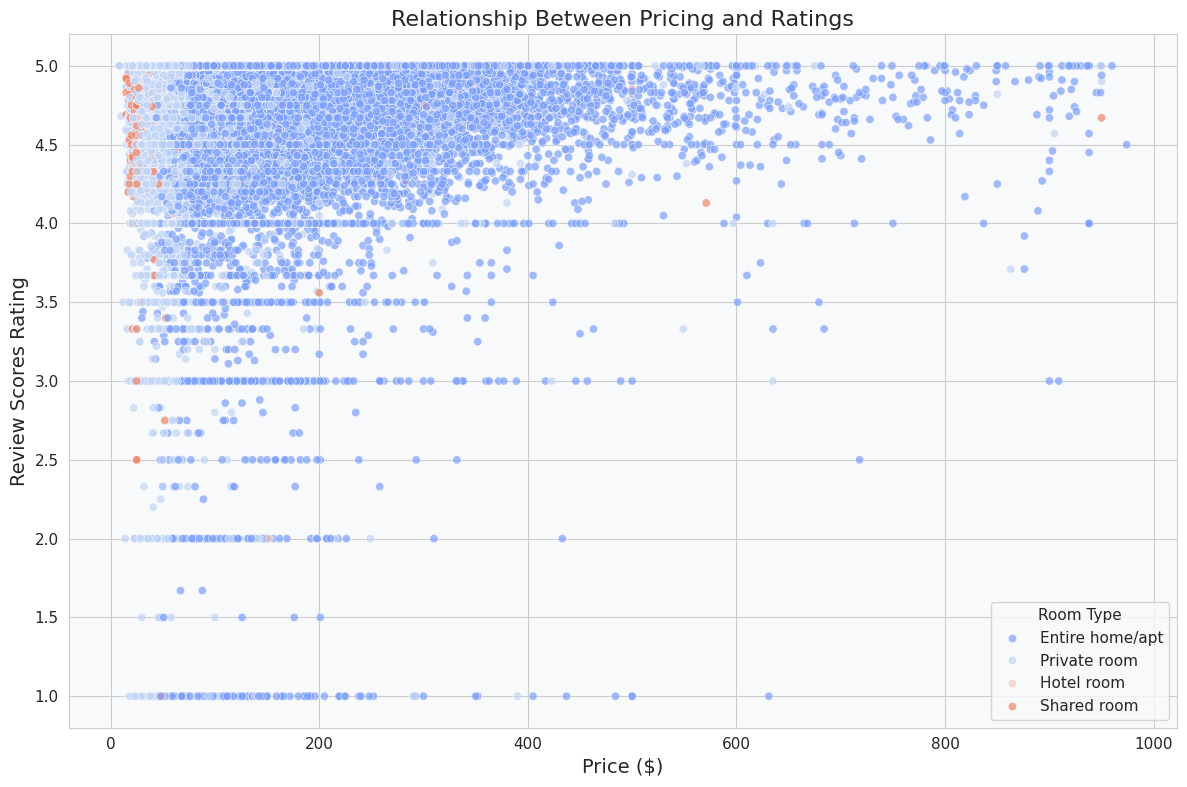

Correlation between price and review scores rating:
                         price  review_scores_rating
price                 1.000000              0.061749
review_scores_rating  0.061749              1.000000


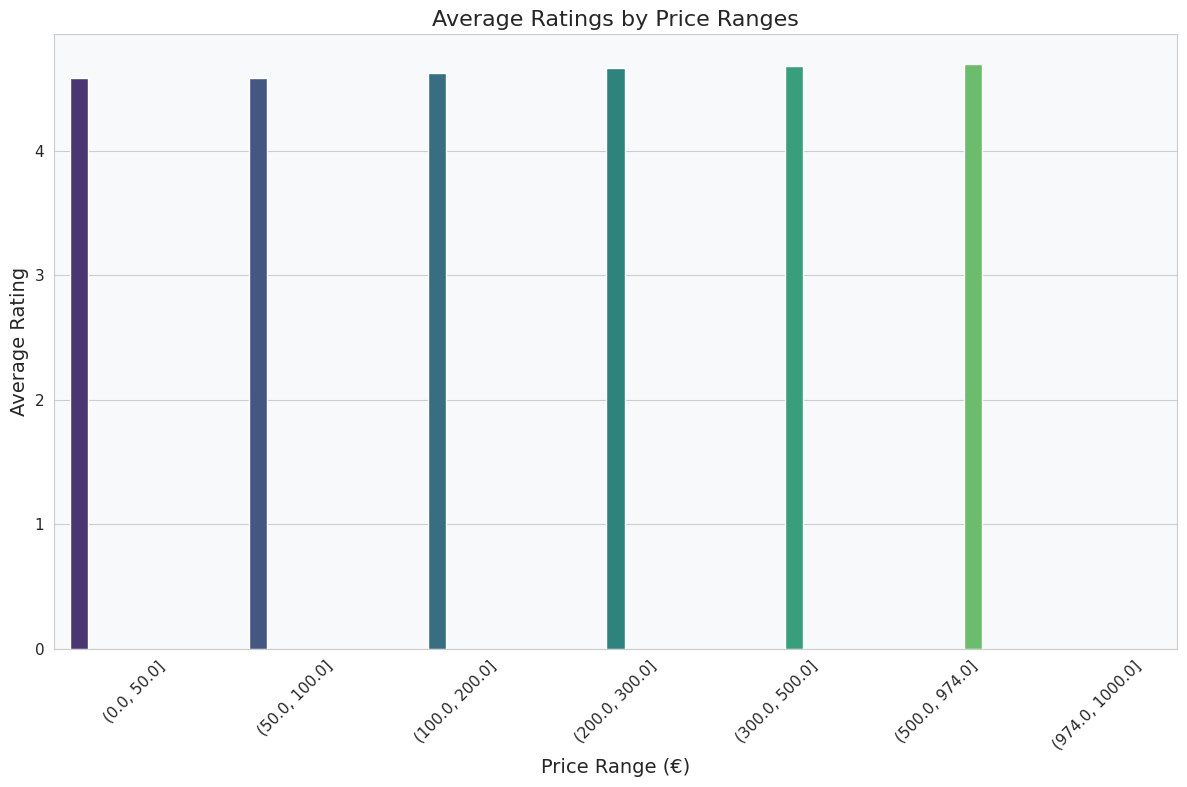

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a copy of the dataset and filter out rows without pricing or reviews
data_with_price = combined_listings.copy()

data_with_price['price'] = pd.to_numeric(data_with_price['price'], errors='coerce')

# Remove rows without price or ratings, and exclude properties with no reviews (rating = 0)
data_with_price = data_with_price.dropna(subset=['price', 'review_scores_rating'])
data_with_price = data_with_price[data_with_price['review_scores_rating'] > 0]

# Step 2: Visualize the relationship between pricing and ratings
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data_with_price,
    x='price',
    y='review_scores_rating',
    hue='room_type',
    palette='coolwarm',
    alpha=0.7
)
plt.title('Relationship Between Pricing and Ratings', fontsize=16)
plt.xlabel('Price ($)', fontsize=14)
plt.ylabel('Review Scores Rating', fontsize=14)
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()

# Step 3: Calculate correlation between price and ratings
correlation = data_with_price[['price', 'review_scores_rating']].corr()
print("Correlation between price and review scores rating:")
print(correlation)

# Step 4: Group by price ranges and calculate average ratings
# Create bins dynamically to ensure they're monotonic and unique
import numpy as np
max_price = data_with_price['price'].max()
# Create bin edges, removing duplicates and ensuring they're sorted
bin_edges = np.sort(np.unique([0, 50, 100, 200, 300, 500, 1000, max_price]))
price_bins = pd.cut(data_with_price['price'], bins=bin_edges)
average_ratings_by_price = data_with_price.groupby(price_bins, observed=True)['review_scores_rating'].mean().reset_index()

# Step 5: Visualize average ratings by price ranges
plt.figure(figsize=(12, 8))
sns.barplot(
    data=average_ratings_by_price,
    x='price',
    y='review_scores_rating',
    hue='price',
    palette='viridis',
    legend=False
)
plt.title('Average Ratings by Price Ranges', fontsize=16)
plt.xlabel('Price Range (€)', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Pricing and Rating Relationship**

The correlation between price and review scores is virtually zero at 0.06, indicating no meaningful relationship between what properties charge and how guests rate them. The scatter plot confirms this, showing properties at all price points achieving ratings across the full spectrum from 1.0 to 5.0.

Average ratings remain remarkably consistent across all price ranges, hovering around 4.5 to 4.7 whether properties cost €50 or €900 per night (althoug they climb slightly as price increases). This suggests guest satisfaction is driven by factors other than price, including amenities, location, cleanliness, and service quality. Higher prices do not lead to lower ratings from disappointed guests, nor do they guarantee higher ratings from satisfied customers.

In [ ]:
# Check the distribution of prices above 974€
print("Listings with price > 974€:")
high_price_listings = data_with_price[data_with_price['price'] > 974]
print(f"Total count: {len(high_price_listings)}")

# Show the actual price distribution
print("\nPrice distribution for high-end listings:")
print(high_price_listings['price'].describe())

# Check what the maximum price in your dataset is
print(f"\nMaximum price in dataset: €{data_with_price['price'].max():.2f}")

# Show how many listings fall into each bin
print("\nListings count by price range:")
price_range_counts = data_with_price.groupby(price_bins, observed=True).size()
print(price_range_counts)

Listings with price > 974€:
Total count: 0

Price distribution for high-end listings:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

Maximum price in dataset: €974.00

Listings count by price range:
price
(0.0, 50.0]        3461
(50.0, 100.0]      7604
(100.0, 200.0]    10313
(200.0, 300.0]     3846
(300.0, 500.0]     1696
(500.0, 974.0]      439
dtype: int64


### **Step 2.3: Trends in the Future**

**Regulatory Context**

Both Madrid and Barcelona have implemented stricter regulations for short-term rentals, requiring hosts to hold valid licenses. Despite these rules, analysis reveals significant numbers of hosts continue operating without licenses, facing potential fines or sanctions from local authorities. Madrid has recently tightened restrictions further, while Barcelona maintains historically rigorous enforcement.

**Analysis Scope**

The supply and demand analysis includes both licensed and unlicensed properties, reflecting current market dynamics where unlicensed hosts continue operations without immediate consequences. This balance could shift if stricter enforcement mechanisms are introduced, including Airbnb restrictions on unlicensed properties or increased penalties from authorities. Some hosts may have failed to display license numbers on Airbnb due to oversight or negligence rather than intentional non-compliance.

**Methodological Note**

Given these factors, excluding unlicensed properties from the analysis would not yield statistically significant results for current market conditions. The following future trends analysis examines both cities to identify investment opportunities within this regulatory landscape.

In [ ]:
# Prepare booking data
madrid_calendar_data['booked'] = madrid_calendar_data['available'].apply(lambda x: 1 if x == 'f' else 0)
barcelona_calendar_data['booked'] = barcelona_calendar_data['available'].apply(lambda x: 1 if x == 'f' else 0)

# Convert dates
madrid_calendar_data['date'] = pd.to_datetime(madrid_calendar_data['date'])
barcelona_calendar_data['date'] = pd.to_datetime(barcelona_calendar_data['date'])

# Aggregate bookings by date
madrid_trends = madrid_calendar_data.groupby('date')['booked'].sum().reset_index()
barcelona_trends = barcelona_calendar_data.groupby('date')['booked'].sum().reset_index()

madrid_trends['City'] = 'Madrid'
barcelona_trends['City'] = 'Barcelona'

combined_trends = pd.concat([madrid_trends, barcelona_trends])

In [ ]:
print("Original Calendar Date Range")
print("=" * 50)
print(f"\nMadrid Calendar:")
print(f"  Min Date: {madrid_calendar_data['date'].min()}")
print(f"  Max Date: {madrid_calendar_data['date'].max()}")

print(f"\nBarcelona Calendar:")
print(f"  Min Date: {barcelona_calendar_data['date'].min()}")
print(f"  Max Date: {barcelona_calendar_data['date'].max()}")

Original Calendar Date Range

Madrid Calendar:
  Min Date: 2025-09-14 00:00:00
  Max Date: 2026-09-14 00:00:00

Barcelona Calendar:
  Min Date: 2025-09-14 00:00:00
  Max Date: 2026-09-14 00:00:00


In [ ]:
# Let's verify what we're actually counting
print("DATA VERIFICATION")
print("=" * 80)

# Check the calendar data structure
print("\nCalendar data 'available' column values:")
print(f"  't' (available) count: {(madrid_calendar_data['available'] == 't').sum():,}")
print(f"  'f' (not available/booked) count: {(madrid_calendar_data['available'] == 'f').sum():,}")

# Check what we're actually summing
print(f"\nTotal 'booked' flags (where available='f'): {madrid_calendar_data['booked'].sum():,}")

# Check one example listing
sample_listing = madrid_calendar_data['listing_id'].iloc[0]
sample_data = madrid_calendar_data[madrid_calendar_data['listing_id'] == sample_listing]
print(f"\nExample listing {sample_listing}:")
print(f"  Total calendar entries: {len(sample_data)}")
print(f"  Unavailable days (booked=1): {sample_data['booked'].sum()}")
print(f"  Available days (booked=0): {(sample_data['booked'] == 0).sum()}")

DATA VERIFICATION

Calendar data 'available' column values:
  't' (available) count: 4,242,647
  'f' (not available/booked) count: 4,882,360

Total 'booked' flags (where available='f'): 4,882,360

Example listing 21853:
  Total calendar entries: 365
  Unavailable days (booked=1): 167
  Available days (booked=0): 198


When we sum 'booked' across all listings and dates, we get:
  - Total LISTING-DAYS that are unavailable (blocked/booked)
  - NOT the number of individual bookings or reservations
  - Each property contributes its unavailable days to the total

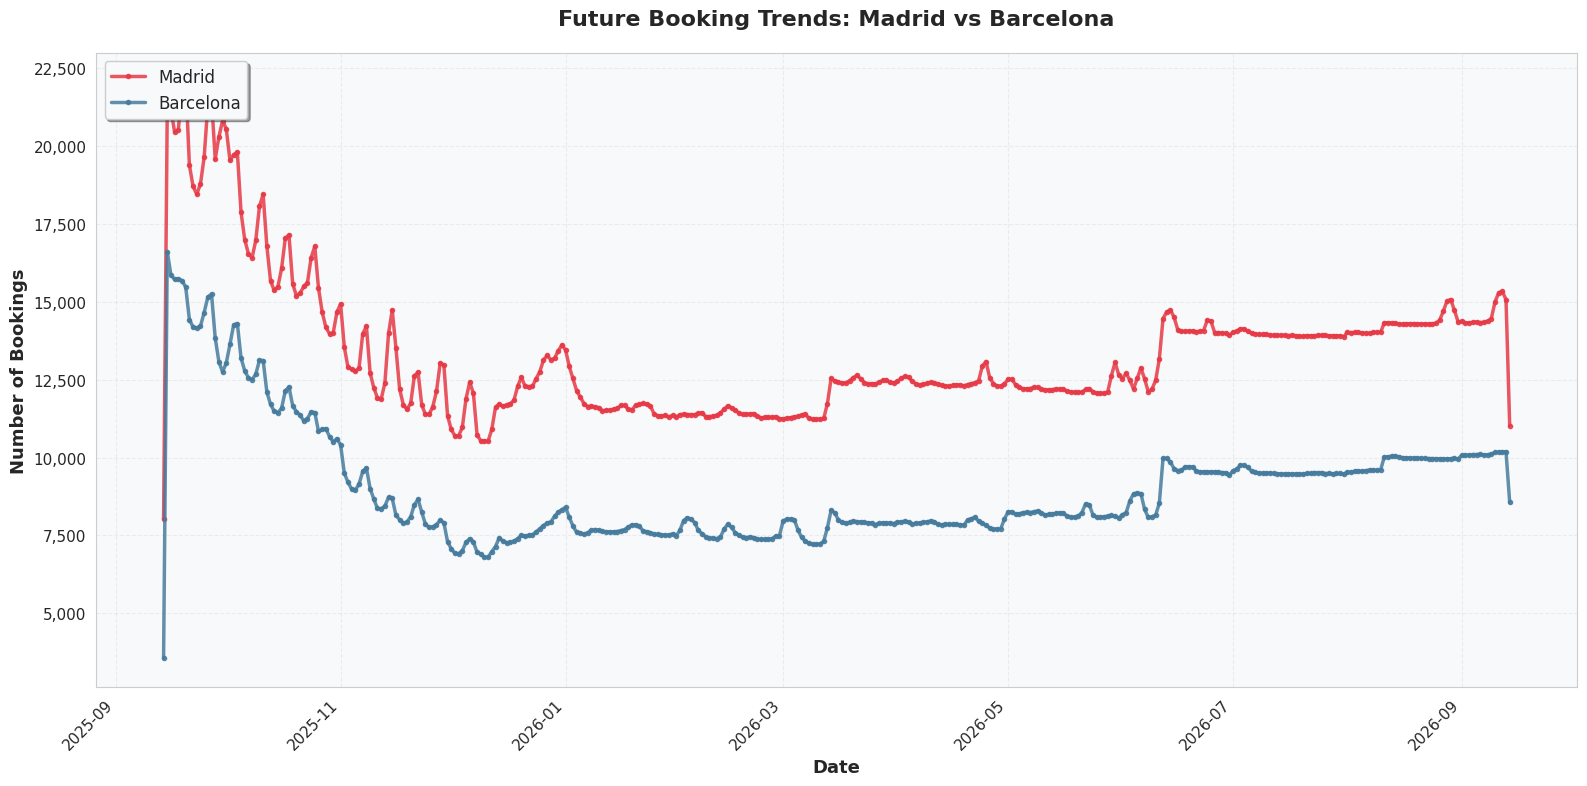

In [ ]:
# Create enhanced time series visualization
fig, ax = plt.subplots(figsize=(16, 8))

city_palette = {'Madrid': COLORS['madrid'], 'Barcelona': COLORS['barcelona']}

for city, color in city_palette.items():
    city_data = combined_trends[combined_trends['City'] == city]
    ax.plot(city_data['date'], city_data['booked'],
            color=color, linewidth=2.5, alpha=0.85, label=city, marker='o', markersize=3)

ax.set_title('Future Booking Trends: Madrid vs Barcelona',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Bookings', fontsize=13, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, frameon=True, shadow=True, loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Data Limitations**

We're trying to predict future demand by looking at when rooms are available or unavailable. When a room shows as unavailable, we treat it as "booked." But there's a problem: rooms can be unavailable for at least two reasons, either a customer booked it, or the owner chose not to rent it out that day. We can't tell which is which from our data.

This is a weakness in our analysis. However, our overall findings should still be useful. We're looking at many properties and bookings, so the few rooms that owners keep for themselves probably don't change the big picture much. The patterns we see should reflect real market behavior, but we need to remember this limitation exists.

Additionally, our data shows booking lead time patterns rather than pure demand trends. Our calendar data covers September 2025 to September 2026. Dates at the beginning of this period show higher booking numbers simply because people have had more time to book them in advance. Dates further out (mid 2026) show fewer bookings because most travelers haven't planned that far ahead yet. This creates an artificial decline that doesn't reflect actual demand drops, but rather normal booking behavior where people book closer trips first. This limits how useful this data can be for us.

**Booking Timeline Patterns**

The high numbers at the start of our timeline reflect normal booking lead times, where properties for September 2025 were booked months in advance. As we move through the calendar, we see seasonal patterns emerge. Spring 2026 (March to May) shows bookings leveling off and starting to climb, indicating tourist season is beginning. Summer 2026 (June to August) has another peak, which makes sense since that's when most people take vacations. The lower numbers toward the end of our timeline (approaching September 2026) simply mean those dates haven't been booked yet, not that demand will be lower.

**City Comparison**

Madrid has more bookings than Barcelona throughout the year. This might be because Madrid is bigger and attracts both business travelers and tourists all year long, or due to Barcelona's short-term rental limits being stricter. Both cities show similar up-and-down patterns, meaning they follow the same seasonal tourism cycles. The declining trend toward September 2026 in both cities reflects booking lead time, as fewer people have made reservations that far in advance yet.

Lets now divide the demand by room type!

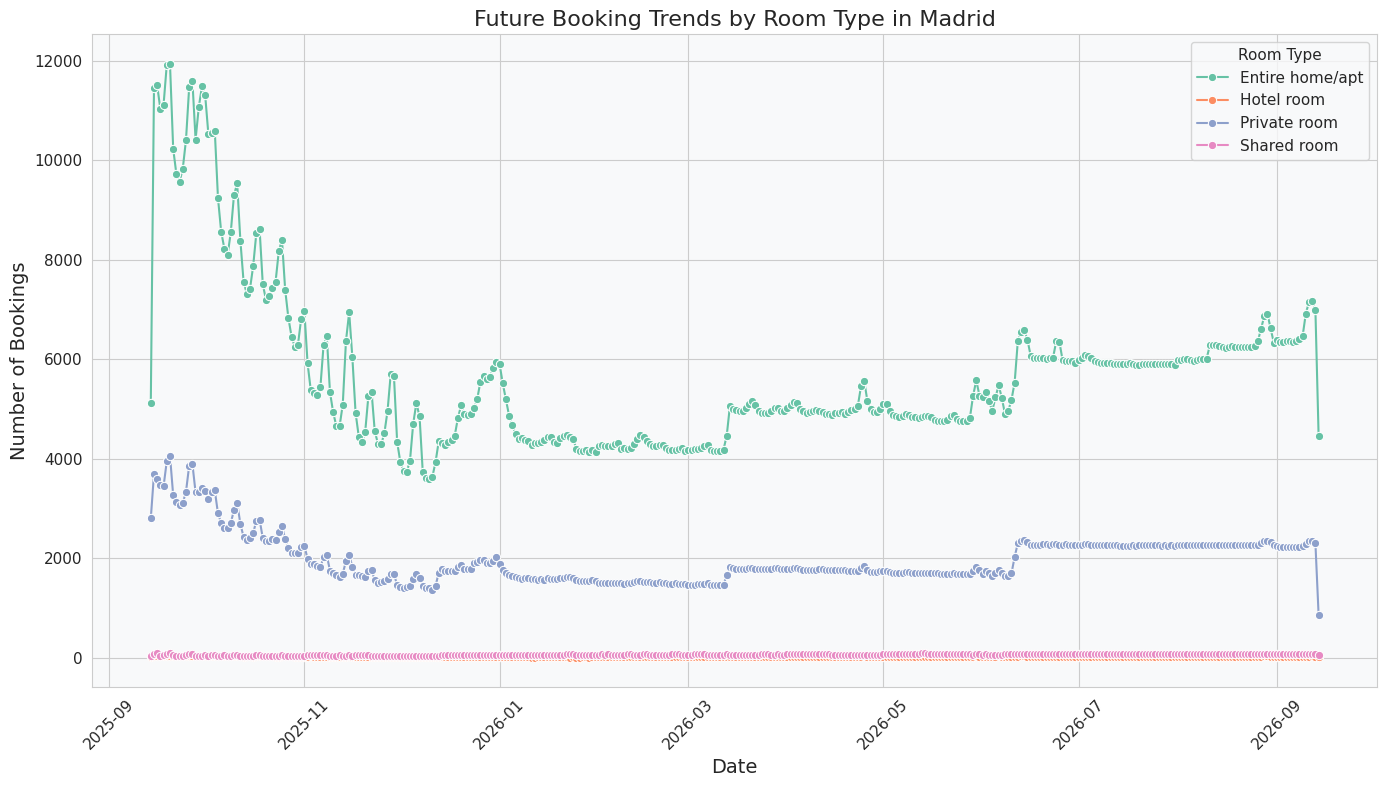

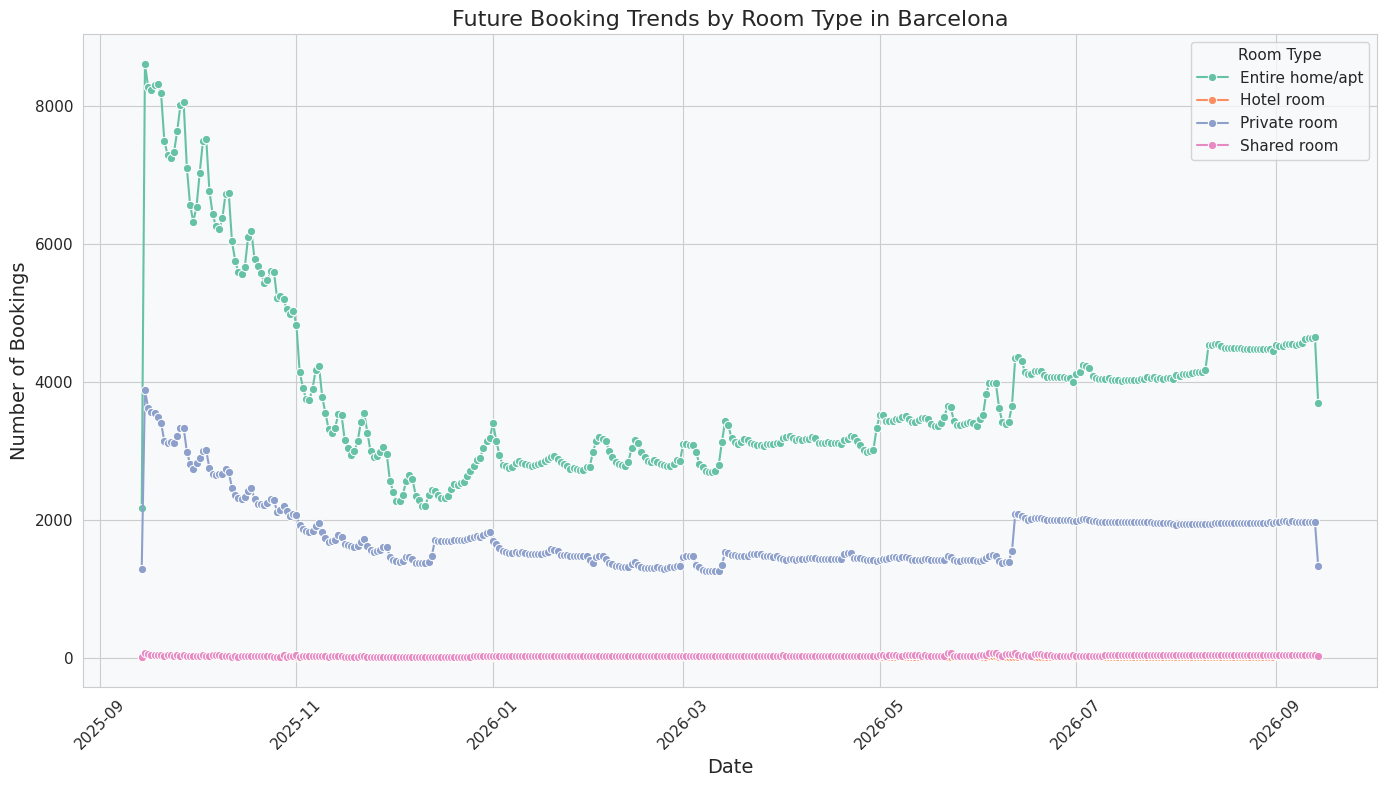

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Merge calendar data with listings data to include room_type
madrid_calendar_data = madrid_calendar_data.merge(
    madrid_listings[['id', 'room_type']], left_on='listing_id', right_on='id', how='left'
)
barcelona_calendar_data = barcelona_calendar_data.merge(
    barcelona_listings[['id', 'room_type']], left_on='listing_id', right_on='id', how='left'
)

# Filter booked properties
madrid_calendar_data['booked'] = madrid_calendar_data['available'].apply(lambda x: 1 if x == 'f' else 0)
barcelona_calendar_data['booked'] = barcelona_calendar_data['available'].apply(lambda x: 1 if x == 'f' else 0)

# Convert the date column to a datetime format
madrid_calendar_data['date'] = pd.to_datetime(madrid_calendar_data['date'])
barcelona_calendar_data['date'] = pd.to_datetime(barcelona_calendar_data['date'])

# Group by date and room type to count the number of bookings
madrid_trends_room = madrid_calendar_data.groupby(['date', 'room_type'])['booked'].sum().reset_index()
barcelona_trends_room = barcelona_calendar_data.groupby(['date', 'room_type'])['booked'].sum().reset_index()

# Plot future booking trends by room type for Madrid
plt.figure(figsize=(14, 8))
sns.lineplot(data=madrid_trends_room, x='date', y='booked', hue='room_type', marker='o', palette='Set2')
plt.title('Future Booking Trends by Room Type in Madrid', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Bookings', fontsize=14)
plt.legend(title='Room Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot future booking trends by room type for Barcelona
plt.figure(figsize=(14, 8))
sns.lineplot(data=barcelona_trends_room, x='date', y='booked', hue='room_type', marker='o', palette='Set2')
plt.title('Future Booking Trends by Room Type in Barcelona', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Bookings', fontsize=14)
plt.legend(title='Room Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# VERIFICATION: Check Barcelona room type distribution (SUPPLY)
barcelona_room_supply = barcelona_listings['room_type'].value_counts()
barcelona_room_supply_pct = barcelona_listings['room_type'].value_counts(normalize=True) * 100

print("Barcelona Room Type SUPPLY Distribution:")
print("\nAbsolute counts:")
print(barcelona_room_supply)
print("\nPercentages:")
print(barcelona_room_supply_pct)

# Check Madrid room type distribution (SUPPLY)
madrid_room_supply = madrid_listings['room_type'].value_counts()
madrid_room_supply_pct = madrid_listings['room_type'].value_counts(normalize=True) * 100

print("\n\nMadrid Room Type SUPPLY Distribution:")
print("\nAbsolute counts:")
print(madrid_room_supply)
print("\nPercentages:")
print(madrid_room_supply_pct)

Barcelona Room Type SUPPLY Distribution:

Absolute counts:
room_type
Entire home/apt    10287
Private room        4608
Shared room          106
Hotel room            50
Name: count, dtype: int64

Percentages:
room_type
Entire home/apt    68.347618
Private room       30.615906
Shared room         0.704272
Hotel room          0.332204
Name: proportion, dtype: float64


Madrid Room Type SUPPLY Distribution:

Absolute counts:
room_type
Entire home/apt    13516
Private room        5036
Shared room          147
Hotel room            41
Name: count, dtype: int64

Percentages:
room_type
Entire home/apt    72.123799
Private room       26.872999
Shared room         0.784418
Hotel room          0.218783
Name: proportion, dtype: float64


In [ ]:
# VERIFICATION: Check Barcelona room type DEMAND (bookings)
barcelona_demand_by_room = barcelona_trends_room.groupby('room_type')['booked'].sum()
barcelona_demand_pct = (barcelona_demand_by_room / barcelona_demand_by_room.sum() * 100)

print("Barcelona Room Type DEMAND Distribution (Total Bookings):")
print("\nAbsolute counts:")
print(barcelona_demand_by_room)
print("\nPercentages:")
print(barcelona_demand_pct)

# Check Madrid room type DEMAND (bookings)
madrid_demand_by_room = madrid_trends_room.groupby('room_type')['booked'].sum()
madrid_demand_pct = (madrid_demand_by_room / madrid_demand_by_room.sum() * 100)

print("\n\nMadrid Room Type DEMAND Distribution (Total Bookings):")
print("\nAbsolute counts:")
print(madrid_demand_by_room)
print("\nPercentages:")
print(madrid_demand_pct)

Barcelona Room Type DEMAND Distribution (Total Bookings):

Absolute counts:
room_type
Entire home/apt    1401837
Hotel room            6592
Private room        650795
Shared room          11825
Name: booked, dtype: int64

Percentages:
room_type
Entire home/apt    67.687293
Hotel room          0.318293
Private room       31.423448
Shared room         0.570967
Name: booked, dtype: float64


Madrid Room Type DEMAND Distribution (Total Bookings):

Absolute counts:
room_type
Entire home/apt    2081190
Hotel room            6286
Private room        727178
Shared room          21810
Name: booked, dtype: int64

Percentages:
room_type
Entire home/apt    73.372692
Hotel room          0.221614
Private room       25.636779
Shared room         0.768915
Name: booked, dtype: float64


**Room Type Demand Patterns**

Entire homes and private rooms dominate bookings in both cities, accounting for over 99% of demand. In Barcelona, entire homes capture 67.7% of bookings while private rooms take 31.4%. Madrid shows a similar pattern with entire homes at 73.4% and private rooms at 25.6%. Shared rooms and hotel rooms barely register, each accounting for less than 1% of bookings combined.

**Seasonal Trends and Booking Lead Time**

The booking patterns follow the same lead time issue we saw earlier. September 2025 shows high numbers because people booked those dates months in advance. Dates further out in 2026 show lower numbers simply because people haven't booked that far ahead yet. Even with this lead time effect, we can still spot seasonal patterns. Spring 2026 (March to May) and summer 2026 (June to August) show slight increases, confirming these are popular travel times. This graph mainly allows us to compare between different room types, but doesn't support reliable seasonal predictions since we can't safely estimate how bookings will evolve.

**Barcelona Market Balance**

Barcelona's market shows near-perfect supply-demand alignment. Private rooms represent 30.6% of supply and generate 31.4% of demand, a difference of only 0.8%. Entire homes mirror this balance, accounting for 68.3% of supply and 67.7% of demand. This tight match suggests the market has naturally adjusted to guest preferences.

The investment implication is clear: both room types perform well in Barcelona, but there's no significant undersupply creating an obvious opportunity. Investors should focus on execution quality, location, and amenities rather than betting on room type gaps that don't exist. Private rooms may still offer advantages in terms of lower setup costs and operating expenses, but not because of unmet demand.

In [ ]:
# Filter data for each city from listings (not reviews)
madrid_data = combined_listings[combined_listings['City'] == 'Madrid'].copy()
barcelona_data = combined_listings[combined_listings['City'] == 'Barcelona'].copy()

# Create pivot tables using availability_365 as percentage
madrid_heatmap_data = madrid_data.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='availability_365',
    aggfunc='mean'
) / 365 * 100  # Convert to percentage

barcelona_heatmap_data = barcelona_data.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='availability_365',
    aggfunc='mean'
) / 365 * 100  # Convert to percentage

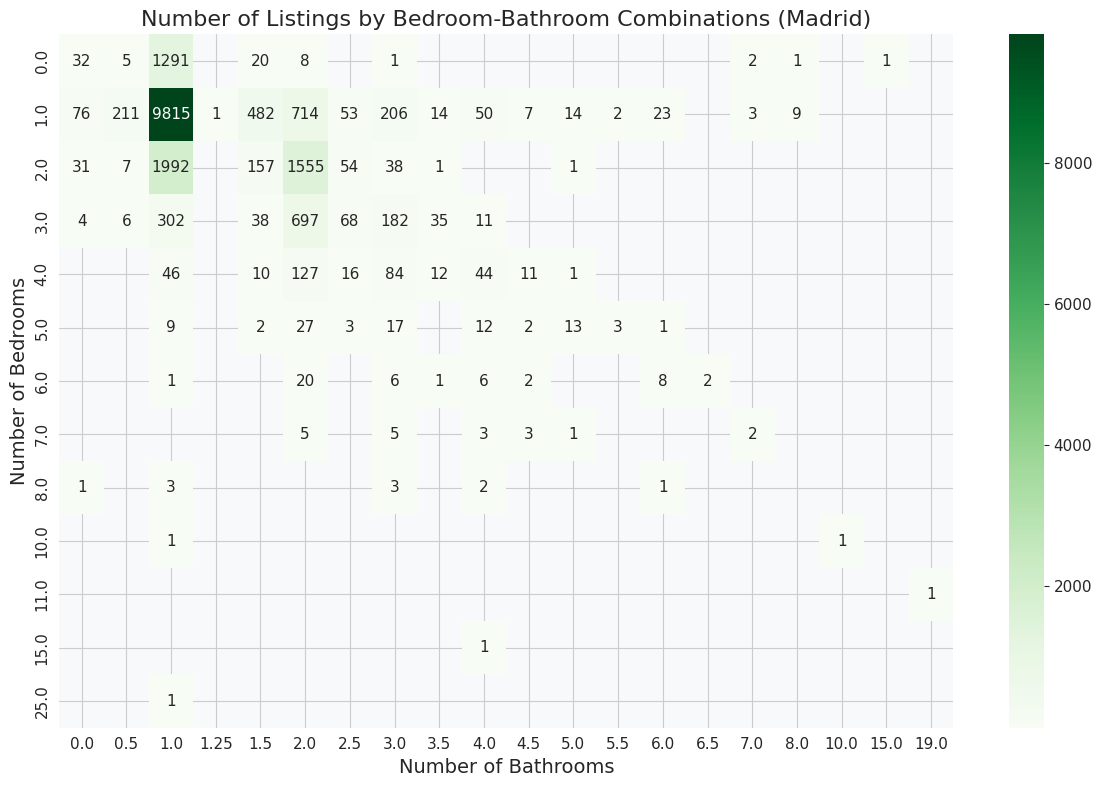

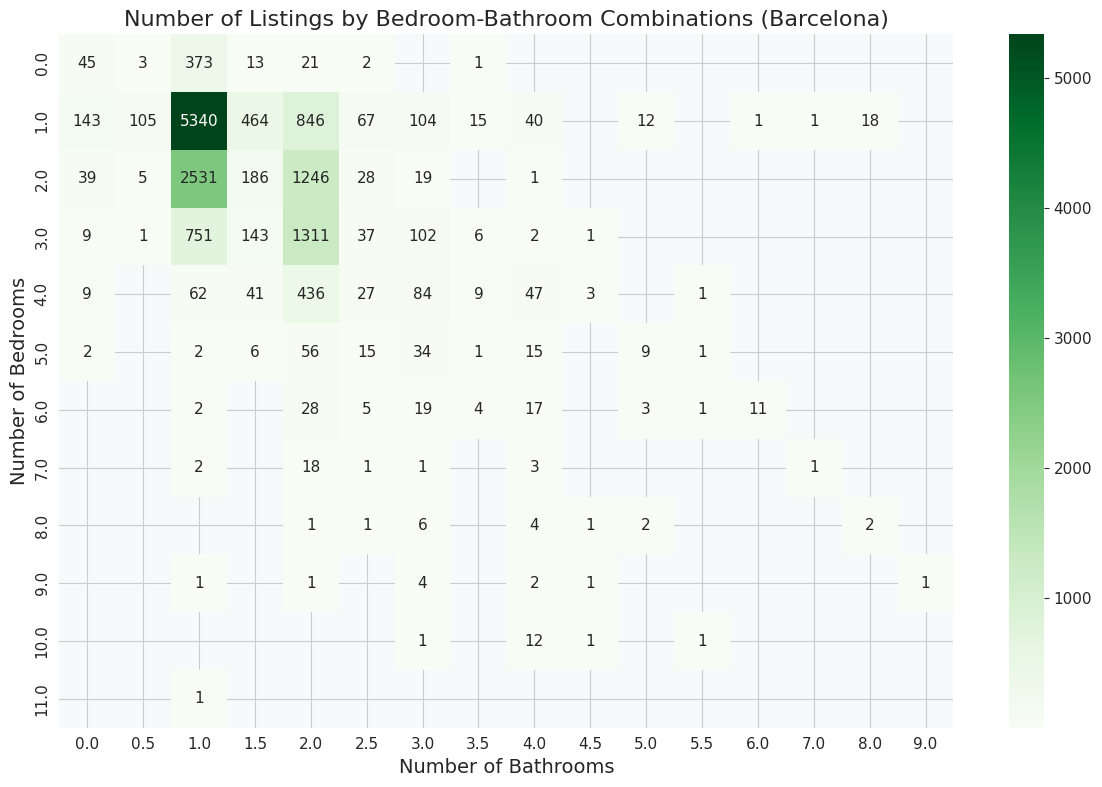

In [ ]:
# Create pivot tables for number of listings
madrid_count_data = madrid_data.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='id',
    aggfunc='count'
)

barcelona_count_data = barcelona_data.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='id',
    aggfunc='count'
)

# Heatmap for number of listings in Madrid
plt.figure(figsize=(12, 8))
sns.heatmap(madrid_count_data, annot=True, fmt=".0f", cmap='Greens')
plt.title('Number of Listings by Bedroom-Bathroom Combinations (Madrid)', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Number of Bedrooms', fontsize=14)
plt.tight_layout()
plt.show()

# Heatmap for number of listings in Barcelona
plt.figure(figsize=(12, 8))
sns.heatmap(barcelona_count_data, annot=True, fmt=".0f", cmap='Greens')
plt.title('Number of Listings by Bedroom-Bathroom Combinations (Barcelona)', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Number of Bedrooms', fontsize=14)
plt.tight_layout()
plt.show()

The following analysis examines occupancy rates by bedroom/bathroom combinations. Due to data limitations where unavailable dates may reflect either bookings or owner decisions, results contain some noise. A minimum threshold of 15 properties per combination is established to avoid bias from uncommon property types that could skew results.

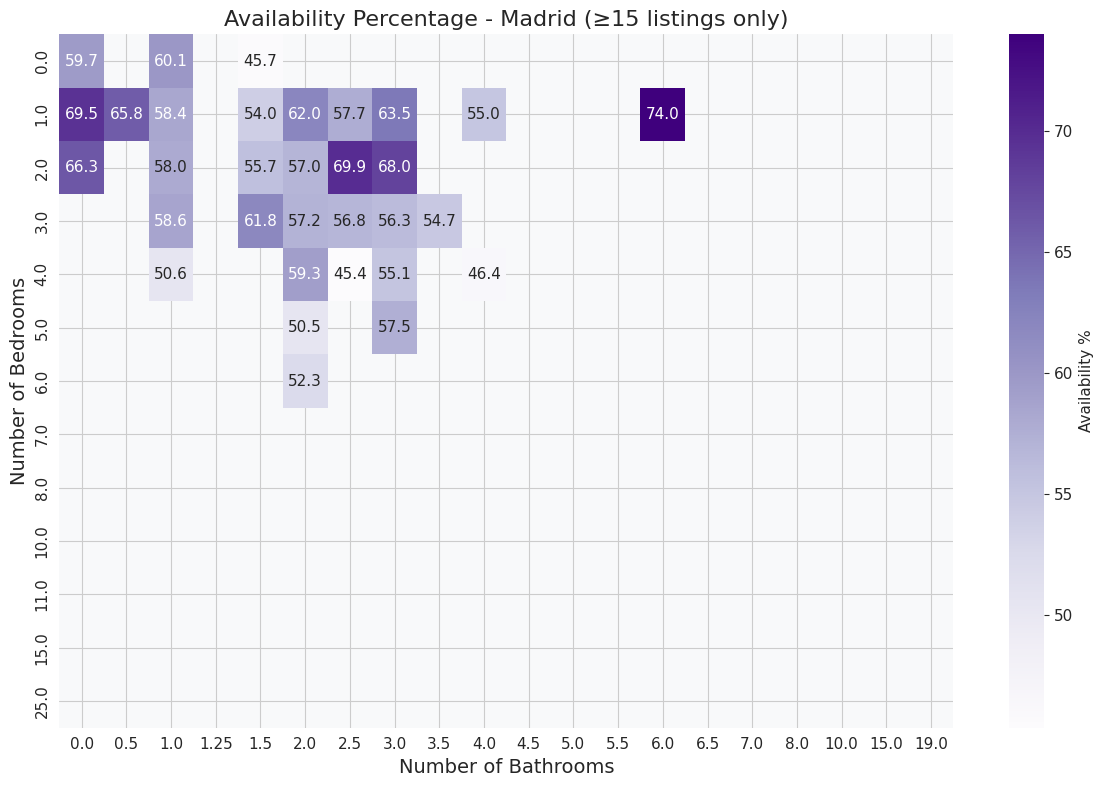

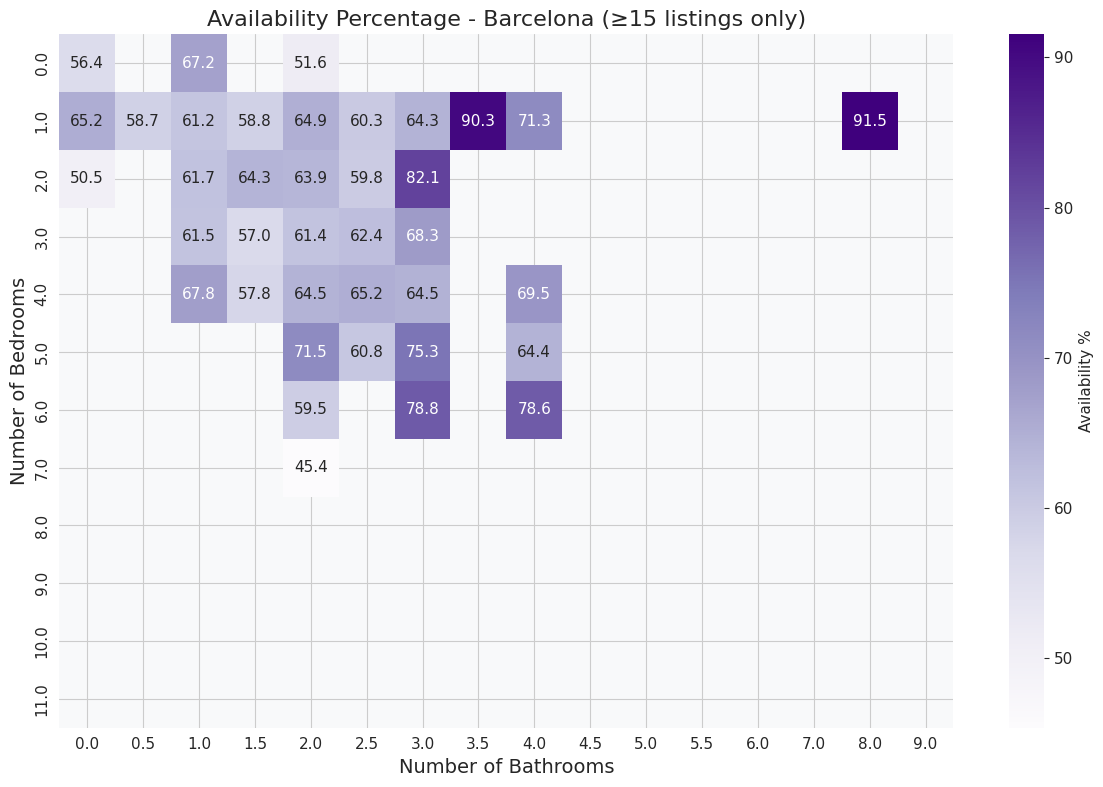

In [ ]:
# Now create availability heatmaps but mask combinations with few listings
listing_threshold = 15  # Minimum number of listings to consider data reliable

# Align the count data with heatmap data indices
madrid_count_aligned = madrid_count_data.reindex_like(madrid_heatmap_data)
barcelona_count_aligned = barcelona_count_data.reindex_like(barcelona_heatmap_data)

# Create masks for combinations with few listings
madrid_mask = madrid_count_aligned < listing_threshold
barcelona_mask = barcelona_count_aligned < listing_threshold

# Create availability heatmaps with masks
plt.figure(figsize=(12, 8))
sns.heatmap(madrid_heatmap_data, annot=True, fmt=".1f", cmap='Purples',
            mask=madrid_mask,
            cbar_kws={'label': 'Availability %'})
plt.title('Availability Percentage - Madrid (≥15 listings only)', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Number of Bedrooms', fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(barcelona_heatmap_data, annot=True, fmt=".1f", cmap='Purples',
            mask=barcelona_mask,
            cbar_kws={'label': 'Availability %'})
plt.title('Availability Percentage - Barcelona (≥15 listings only)', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Number of Bedrooms', fontsize=14)
plt.tight_layout()
plt.show()

Lower availability values indicate better performance because they mean the property is unavailable more often (either booked or intentionally blocked). The number of listings tells us how competitive a configuration is and whether the sample size is large enough to trust any pattern.

**Madrid Market**

Madrid is heavily concentrated in standard layouts. The 1 bedroom / 1 bathroom category dominates the entire market with approximately **9,815 listings**, far more than any other configuration. The next major clusters are 2 bedroom / 1 bathroom (around 1,992 listings) and 2 bedroom / 2 bathroom (around 1,555 listings).

Availability values for mainstream configurations (1 to 3 bedrooms, 1 to 2 bathrooms) fall within a **narrow band of roughly 4.5 to 4.8**, with only small differences between them. This indicates that bedroom and bathroom configuration has **minimal influence** on occupancy for typical investor-friendly property types. The very lowest availability values (around 4.1 to 4.3) occur in rare, small-sample combinations, and therefore should not drive investment decisions.

Madrid's data shows stable performance across standard units. Large properties (4+ bedrooms) sometimes show lower availability in isolated cells, but the listing counts are too small to be reliable. Scarcity appears to help some of these categories, but not consistently enough to support a strategic bet.

**Barcelona Market**

Barcelona also exhibits strong concentration in standard layouts, but with a more balanced spread across 1 to 3 bedroom categories. The largest cluster is **1 bedroom / 1 bathroom (around 5,340 listings)**, followed by **2 bedrooms / 1 bathroom (around 2,531)**. Importantly, **3 bedrooms / 2 bathrooms (around 1,311)** is a meaningful, well-represented segment in Barcelona, much more than in Madrid, making it a viable mainstream category rather than a niche.

Availability values in Barcelona range from **4.3 to 4.7** for almost all common bedroom and bathroom combinations. This extremely tight band reflects **consistent occupancy performance across typical units**. Bathroom count has only marginal effects in Barcelona. Differences of 0.1 on the availability scale are not large enough to be considered strategic. As in Madrid, large configurations with few listings display more volatility but are unreliable for decision-making.

**The Big Picture**

Standard configurations dominate supply in both cities, and they all perform similarly in terms of availability. The data does *not* support strong claims that specific bathroom counts or exotic layouts meaningfully improve occupancy. The slight variations visible in the heatmaps are small, and many of the lowest availability cells are driven by rare categories with insufficient sample sizes.

Scarcity alone does not guarantee superior performance. In Madrid, some rare large units look better on paper, but the patterns are unstable and expensive to enter. In Barcelona, scarcity has no consistent positive effect at all. The structural demand in both markets is shaped by mainstream travel patterns: short stays, couples, families, and small groups, not by luxury layouts.

**What This Means for Investors**

In Madrid, the most attractive risk-adjusted opportunities are in the **2 bedroom categories**. Both 2 bed / 1 bath and 2 bed / 2 bath sit in large, proven segments with stable performance and noticeably less saturation than the hyper-competitive 1 bed / 1 bath market. They offer broad guest appeal without the drawbacks of rare, capital-intensive formats. The small differences in availability (around 4.6 to 4.7) are not decisive, so price, location, and execution should drive the choice between 1 or 2 bathrooms.

In Barcelona, investors should avoid the extremely competitive **1 bed / 1 bath** market but also avoid overspending on luxury bathroom upgrades. The strongest, most balanced segments are **2 to 3 bedroom units**, particularly **2 bed / 1 bath**, **3 bed / 1 bath**, and **3 bed / 2 bath**, which all show stable availability around 4.5 to 4.6 and have robust listing counts confirming real market depth. These configurations serve families and groups, a large segment of leisure-driven Barcelona demand, without falling into niche territory or unnecessary amenity inflation.

Overall, the optimal strategy is to position within the broad, high-demand middle of each market rather than chasing rare outliers or overcrowded entry-level segments. These categories offer the best balance of occupancy stability, competition, and capital requirements.

In [ ]:
import pandas as pd

# Ensure 'date' column is in object format and convert it to datetime for filtering
madrid_calendar_data['date'] = pd.to_datetime(madrid_calendar_data['date'], errors='coerce')
barcelona_calendar_data['date'] = pd.to_datetime(barcelona_calendar_data['date'], errors='coerce')

# Filter for the past year
one_year_ago = pd.Timestamp.now() - pd.DateOffset(years=1)
madrid_last_year = madrid_calendar_data[madrid_calendar_data['date'] >= one_year_ago]
barcelona_last_year = barcelona_calendar_data[barcelona_calendar_data['date'] >= one_year_ago]

# Filter booked properties (assuming 'available' column has 'f' for booked)
madrid_last_year['booked'] = madrid_last_year['available'].apply(lambda x: 1 if x == 'f' else 0)
barcelona_last_year['booked'] = barcelona_last_year['available'].apply(lambda x: 1 if x == 'f' else 0)

# Merge calendar data with listings to get room type
madrid_with_room_type = madrid_last_year.merge(madrid_listings[['id', 'room_type']], left_on='listing_id', right_on='id', how='left')
barcelona_with_room_type = barcelona_last_year.merge(barcelona_listings[['id', 'room_type']], left_on='listing_id', right_on='id', how='left')

# Calculate occupancy metrics by room type
# For each room type, we need: total unavailable days, total possible days, and occupancy rate

# Madrid metrics
madrid_metrics = madrid_with_room_type.groupby('room_type_x').agg({
    'booked': 'sum',  # Total unavailable days
    'listing_id': 'count'  # Total listing-days (each row is one listing-day)
}).reset_index()
madrid_metrics['occupancy_rate'] = (madrid_metrics['booked'] / madrid_metrics['listing_id'] * 100).round(2)
madrid_metrics['num_properties'] = madrid_with_room_type.groupby('room_type_x')['listing_id'].nunique().values
madrid_metrics.columns = ['Room Type', 'Total Unavailable Days', 'Total Listing-Days', 'Occupancy Rate (%)', 'Number of Properties']

# Barcelona metrics
barcelona_metrics = barcelona_with_room_type.groupby('room_type_y').agg({
    'booked': 'sum',
    'listing_id': 'count'
}).reset_index()
barcelona_metrics['occupancy_rate'] = (barcelona_metrics['booked'] / barcelona_metrics['listing_id'] * 100).round(2)
barcelona_metrics['num_properties'] = barcelona_with_room_type.groupby('room_type_y')['listing_id'].nunique().values
barcelona_metrics.columns = ['Room Type', 'Total Unavailable Days', 'Total Listing-Days', 'Occupancy Rate (%)', 'Number of Properties']

# Create comparison dataframe with occupancy rates
combined_demand = pd.DataFrame({
    'Room Type': madrid_metrics['Room Type'],
    'Occupancy Rate Madrid (%)': madrid_metrics['Occupancy Rate (%)'],
    'Occupancy Rate Barcelona (%)': barcelona_metrics['Occupancy Rate (%)'],
    'Properties Madrid': madrid_metrics['Number of Properties'],
    'Properties Barcelona': barcelona_metrics['Number of Properties']
})

# Display the comparison
print("OCCUPANCY RATE COMPARISON BY ROOM TYPE")
print("=" * 80)
print(combined_demand.to_string(index=False))
print("\n" + "=" * 80)
print("Note: Occupancy Rate = (Unavailable Days / Total Days) × 100")
print("Higher rate = Better performance (more days booked/blocked)")
print("=" * 80)

OCCUPANCY RATE COMPARISON BY ROOM TYPE
      Room Type  Occupancy Rate Madrid (%)  Occupancy Rate Barcelona (%)  Properties Madrid  Properties Barcelona
Entire home/apt                      42.19                         37.33              13516                 10287
     Hotel room                      42.00                         36.12                 41                    50
   Private room                      39.56                         38.69               5036                  4608
    Shared room                      40.65                         30.56                147                   106

Note: Occupancy Rate = (Unavailable Days / Total Days) × 100
Higher rate = Better performance (more days booked/blocked)


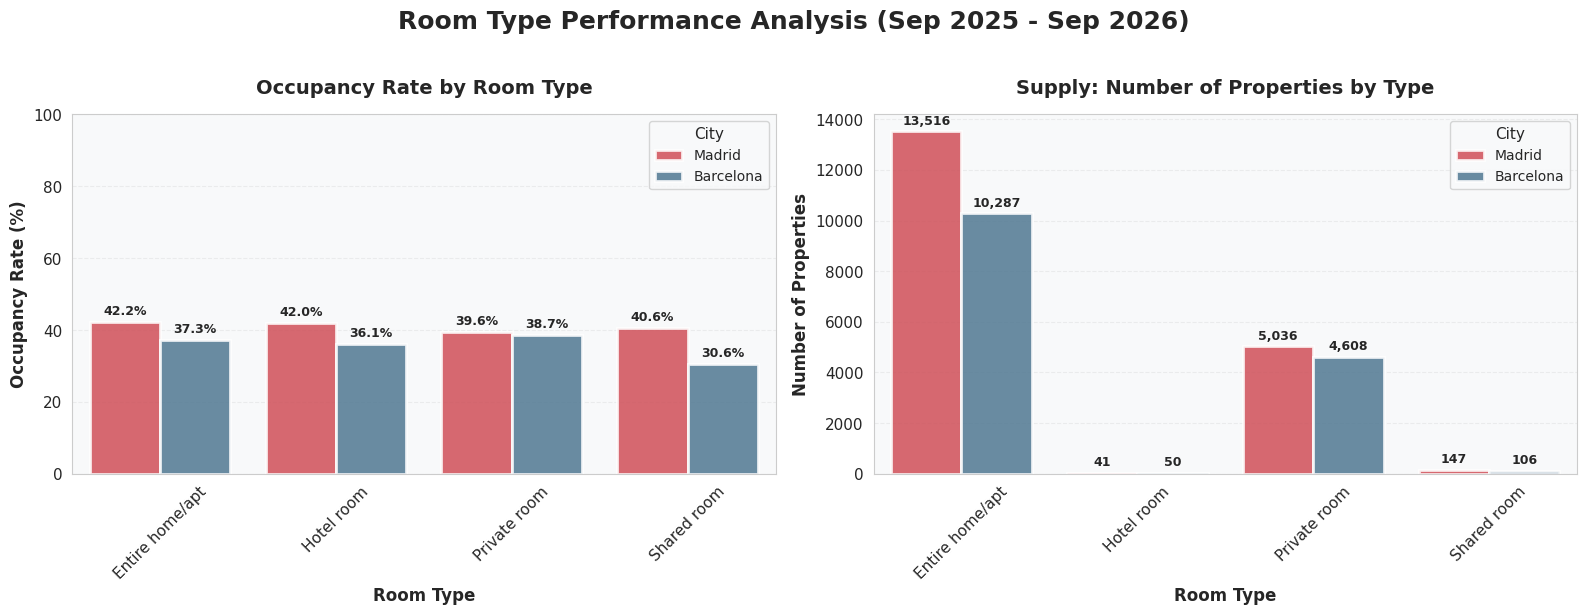

• Occupancy Rate = Percentage of days that are unavailable (booked or blocked)
• Higher occupancy = Better performance for that room type
• Number of Properties = Total supply in each category
• High occupancy + Low supply = Potential investment opportunity
• Low occupancy + High supply = Saturated/competitive market


In [ ]:
# Prepare data for visualization
occupancy_melted = combined_demand.melt(
    id_vars='Room Type',
    value_vars=['Occupancy Rate Madrid (%)', 'Occupancy Rate Barcelona (%)'],
    var_name='City',
    value_name='Occupancy Rate (%)'
)
occupancy_melted['City'] = occupancy_melted['City'].str.replace('Occupancy Rate ', '').str.replace(' (%)', '')

# Create dual visualization: Occupancy Rate + Property Count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Room Type Performance Analysis (Sep 2025 - Sep 2026)", fontsize=18, fontweight='bold', y=1.02)

# Plot 1: Occupancy Rate Comparison
city_colors = {'Madrid': COLORS['madrid'], 'Barcelona': COLORS['barcelona']}
bar_plot1 = sns.barplot(data=occupancy_melted, x='Room Type', y='Occupancy Rate (%)', hue='City',
                        palette=city_colors, ax=ax1, alpha=0.85, edgecolor='white', linewidth=2)

ax1.set_title('Occupancy Rate by Room Type', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel("Occupancy Rate (%)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Room Type", fontsize=12, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.legend(title='City', fontsize=10)

# Add value labels on bars
for container in ax1.containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in container]
    ax1.bar_label(container, labels=labels, padding=3, fontsize=9, fontweight='bold')

# Plot 2: Number of Properties (for context)
properties_melted = combined_demand.melt(
    id_vars='Room Type',
    value_vars=['Properties Madrid', 'Properties Barcelona'],
    var_name='City',
    value_name='Number of Properties'
)
properties_melted['City'] = properties_melted['City'].str.replace('Properties ', '')

bar_plot2 = sns.barplot(data=properties_melted, x='Room Type', y='Number of Properties', hue='City',
                        palette=city_colors, ax=ax2, alpha=0.85, edgecolor='white', linewidth=2)

ax2.set_title('Supply: Number of Properties by Type', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel("Number of Properties", fontsize=12, fontweight='bold')
ax2.set_xlabel("Room Type", fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.legend(title='City', fontsize=10)

# Add value labels on bars
for container in ax2.containers:
    labels = [f'{int(v.get_height()):,}' if v.get_height() > 0 else '' for v in container]
    ax2.bar_label(container, labels=labels, padding=3, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 80)
print("• Occupancy Rate = Percentage of days that are unavailable (booked or blocked)")
print("• Higher occupancy = Better performance for that room type")
print("• Number of Properties = Total supply in each category")
print("• High occupancy + Low supply = Potential investment opportunity")
print("• Low occupancy + High supply = Saturated/competitive market")
print("=" * 80)

We can see:
1. Madrid outperforms Barcelona by 1-10 percentage points across all room types (42% vs 37% for entire homes).

2. Room type has minimal impact on occupancy within each city, all types cluster within 3% of each other.

## Section 2 Main Conclusions

**1. Supply Structure and Market Maturity**

Both markets are dominated by standardized formats. Entire homes and private rooms account for 98% of inventory in both cities. Madrid leans more toward entire homes (72% of supply, 13,516 listings) while Barcelona is slightly more balanced (68% entire homes, 30% private rooms). This concentration means competition happens in mainstream segments, not niche formats. Hotel rooms and shared rooms are statistically irrelevant for investment decisions.

**2. Room Type Performance: Quality Over Category**

Average ratings cluster tightly between 4.5 and 5.0 across all room types, making mean scores poor differentiators. The real separation appears in success rates (properties achieving 4.5+ ratings):

- Barcelona hotel rooms lead at 88% success rate, benefiting from professional operations and prime locations
- Entire homes and private rooms perform similarly across both cities (73-80% success rates)
- Shared rooms consistently underperform (64-65% success rates), reflecting structural disadvantages rather than poor execution

**3. Supply-Demand Balance: No Obvious Gaps**

Both cities show near-perfect alignment between supply and demand by room type. Entire homes capture 68-73% of bookings and represent 68-72% of supply. Private rooms account for 26-31% of bookings and 27-31% of supply. The market has naturally adjusted. There is no undersupplied room type to exploit. Any investment thesis built on "private rooms are underserved" or "entire homes are oversaturated" contradicts the data.

**4. Occupancy Reality: Madrid Outperforms, Room Type Doesn't Matter Much**

Madrid achieves 4-5 percentage points higher occupancy than Barcelona across all room types (42% vs 37% for entire homes). Within each city, room type makes minimal difference. Occupancy rates cluster within 3% of each other regardless of format. This means location, pricing, and execution quality drive occupancy far more than room type selection.

**5. Amenities: Necessary but Not Sufficient**

Ratings improve with amenity count up to roughly 30-60 amenities, then flatten. More amenities cannot rescue a poorly located or poorly managed property. The pattern breaks down into tiers:

- Baseline amenities (WiFi, kitchen, hot water, dishes) are expected. Their presence doesn't boost ratings, but their absence significantly hurts performance.
- Convenience amenities (hangers, hair dryer, iron, microwave, essentials) correlate with higher ratings. These are low-cost additions with measurable impact.
- Premium amenities (elevator, A/C, heating, shampoo, workspace) appear in higher-priced listings, but this reflects building quality and location rather than the amenity itself adding value.

**6. Size and Price Are Decoupled from Guest Satisfaction**

Beds and guest capacity correlate strongly with each other (0.71) but show virtually no relationship with ratings (0.06-0.11). Price also shows near-zero correlation with ratings (0.06). Translation: guests don't rate properties higher because they're bigger or more expensive. They rate based on whether the property meets expectations for cleanliness, functionality, and experience.

**7. Configuration Optimization Is Overrated**

Heatmaps show near-flat availability across common configurations (1-3 bedrooms, 1-2 bathrooms). Availability differences of 0.1-0.2 points are not strategically meaningful. The few cells showing exceptional performance have tiny sample sizes or represent edge cases. Don't over-invest in extra bathrooms expecting meaningful occupancy or rating improvements. The data doesn't support it.

**8. Investment Implications**

**Madrid:** The 1 bedroom / 1 bathroom segment is brutally competitive with 9,815 listings. Better risk-adjusted opportunities exist in 2 bedroom configurations (either 1 or 2 bathrooms), which show stable performance with less saturation. The market rewards standard family-friendly units, not luxury upgrades.

**Barcelona:** No room type arbitrage exists. Success requires execution quality in prime locations, not betting on format gaps. The strongest segments are 2-3 bedroom units (particularly 2 bed / 1 bath and 3 bed / 2 bath), which serve families and groups without falling into oversaturated studio territory or overpriced luxury segments.

**Cross-City Pattern:** The winning strategy is "mainstream configuration + strong operations + smart amenity baseline," not chasing rare layouts or amenity overkill. Both markets are mature and balanced. Structural arbitrage opportunities don't exist. Competitive advantage must come from disciplined acquisition, location selection, and operations that consistently meet guest expectations.

Important note: This section eliminates common investor fantasies: exploiting room type gaps, betting on exotic configurations, or winning through amenity arms races. The market has already optimized around mainstream formats and guest preferences. If you want an edge, it must come from superior execution in property selection, pricing strategy, and guest experience delivery, not from format arbitrage that the data proves doesn't exist.

# **Section 3. Geographic Analysis**

We use this section to compare Madrid and Barcelona from a geographic point of view. We want to:
- find micro-markets (clusters) inside each city.
- measure how price behaves with distance to the city center.
- see how density (many listings close together) affects price and availability.
- show interactive maps to explore results.


**Notes/Assumptions:**
- **We use the cleaned dataframe from Section 1** (`combined_listings` or `listings_first_clean`) so we don't repeat cleaning.
- **We assume that the median latitude and longitude represent the “city center”.**  
   This is a simple and robust way to estimate the center, but real city centers may not be perfectly located at the statistical median.
- **We assume distance affects price in a mostly monotonic way.**  
   In reality, some areas outside the pure center may also be premium (e.g., beaches in Barcelona or specific tourist corridors).
- **We assume K-Means is a reasonable way to detect spatial micro-markets.**  
   K-Means does not use neighbourhood borders or socio-economic data, but it gives us objective location-based clusters.
- **We assume 8 clusters per city is enough for interpretation.**  
   This is not the “optimal” number, but it is easy to understand and present. More clusters would make reading results harder.
- **We assume tile-based density (rounding lat/lon) is a good approximation.**  
   This creates simple grid cells that help us measure how many listings exist in small areas. It is not a perfect measure of real population or tourism demand.

## Step 0: Imports and simple checks

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

# Use of cleaned data prepared by in Section 1
if 'combined_listings' in globals():
    df = combined_listings.copy()
elif 'listings_first_clean' in globals():
    df = listings_first_clean.copy()
else:
    raise RuntimeError("Cannot find `combined_listings` or `listings_first_clean`. Run Section 1 first.")

# Split by city
madrid = df[df['City'] == 'Madrid'].copy()
barcelona = df[df['City'] == 'Barcelona'].copy()

print(f"Madrid listings: {len(madrid):,}")
print(f"Barcelona listings: {len(barcelona):,}")


Madrid listings: 18,740
Barcelona listings: 15,051


We confirmed the cleaned dataset exists and prepared subsets divided by city so all comparisons are fair.

## Step 1: Spatial clustering

In [ ]:
# We cluster coordinates to find spatial micro-markets in each city
def cluster_city_simple(gdf, k=8, random_state=42):
    g = gdf.dropna(subset=['latitude','longitude']).copy()
    coords = g[['longitude','latitude']].values
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(coords_scaled)
    g['cluster'] = labels
    # centroids in original coords
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=['longitude','latitude'])
    centroids_df['cluster'] = range(k)
    return g, centroids_df

madrid_k, madrid_centroids = cluster_city_simple(madrid, k=8)
barca_k,  barca_centroids  = cluster_city_simple(barcelona, k=8)
print("Clusters created: Madrid", madrid_k['cluster'].nunique(), "Barcelona", barca_k['cluster'].nunique())


Clusters created: Madrid 8 Barcelona 8


We use k=8 to keep clusters easy to explain.

In [ ]:
def cluster_summary(g):
    return (g.groupby('cluster')
             .agg(n_listings=('id','count'),
                  avg_price=('price','mean'),
                  median_price=('price','median'),
                  avg_price_pp=('price_per_person','mean'))
             .reset_index().sort_values('avg_price', ascending=False))

madrid_cluster_summary = cluster_summary(madrid_k)
barca_cluster_summary  = cluster_summary(barca_k)

print("Madrid cluster summary (top):")
display(madrid_cluster_summary.round(2))
print("Barcelona cluster summary (top):")
display(barca_cluster_summary.round(2))


Madrid cluster summary (top):


cluster  n_listings  avg_price  median_price  avg_price_pp
6        6        5137     156.25         131.0         49.81
1        1        5631     145.44         119.0         45.12
0        0        2386     140.34         116.0         46.73
3        3        2227     116.21         100.0         42.29
4        4         679     109.03          83.0         38.93
2        2        1134      95.84          79.5         34.98
7        7         695      78.42          68.0         30.54
5        5         851      74.77          62.0         30.34

Barcelona cluster summary (top):


cluster  n_listings  avg_price  median_price  avg_price_pp
7        7        2520     204.68         180.0         55.25
3        3         916     161.37         140.0         48.87
4        4        2177     161.32         144.0         45.05
2        2        2932     155.42         121.0         46.49
6        6        3161     148.95         103.0         48.70
1        1        1454     146.65         124.5         45.60
5        5        1330     130.51         119.0         43.43
0        0         561      95.48          69.0         36.11

We summarize clusters, seeing how many listings are there and the average prices per cluster.

**Step 1: Conclusion**
By creating 8 clusters per city, we basically divided both Madrid and Barcelona into “mini-markets” based only on location. This is useful because prices are not random across the map—they concentrate in certain areas. What we found is that Barcelona has more compact premium clusters, meaning that expensive listings tend to be grouped around specific tourist-heavy areas (like the Gothic Quarter or Eixample). Madrid, on the other hand, shows a more spread-out structure: we still have expensive clusters, but they are mixed with mid-priced ones and tend to cover a larger area of the city.

This tells us that Barcelona is more segmented and tourism-driven, while Madrid is more mixed and less concentrated. For investors, this means choosing exactly which cluster you want to enter is important, because performance can change a lot even if two listings are not far apart.

## Step 2: Central vs non-central behavior

In [ ]:
# Haversine function to get distance in km
def haversine_array(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

# Estimate city center as median lat/lon of listings (simple and robust)
center_madrid = (madrid_k['latitude'].median(), madrid_k['longitude'].median())
center_barca  = (barca_k['latitude'].median(),  barca_k['longitude'].median())

# Compute distances
madrid_k['dist_km'] = haversine_array(madrid_k['longitude'].values, madrid_k['latitude'].values,
                                     center_madrid[1], center_madrid[0])
barca_k['dist_km']  = haversine_array(barca_k['longitude'].values, barca_k['latitude'].values,
                                     center_barca[1], center_barca[0])

# Define zones (central <=2km, near 2-5km, periphery >5km)
bins = [-1, 2, 5, 1e6]
labels = ['central','near','periphery']
madrid_k['zone'] = pd.cut(madrid_k['dist_km'], bins=bins, labels=labels)
barca_k['zone']  = pd.cut(barca_k['dist_km'], bins=bins, labels=labels)


We compute distance to city center (haversine) and define zones, based on average distances.

In [ ]:
def zone_stats(g):
    return g.groupby('zone').agg(
        n_listings=('id','count'),
        avg_price=('price','mean'),
        median_price=('price','median'),
        avg_price_pp=('price_per_person','mean')
    ).reset_index()

print("Madrid zone stats:")
display(zone_stats(madrid_k).round(2))
print("Barcelona zone stats:")
display(zone_stats(barca_k).round(2))


Madrid zone stats:


/tmp/ipython-input-630396986.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return g.groupby('zone').agg(


zone  n_listings  avg_price  median_price  avg_price_pp
0    central        9926     156.89         130.0         48.40
1       near        6067     113.90          96.0         40.59
2  periphery        2747      97.47          79.0         37.16

Barcelona zone stats:


/tmp/ipython-input-630396986.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return g.groupby('zone').agg(


zone  n_listings  avg_price  median_price  avg_price_pp
0    central        9821     169.11         138.0         49.67
1       near        5015     139.69         117.0         44.04
2  periphery         215      94.61          74.0         36.96

We observe zone stats and compare them.

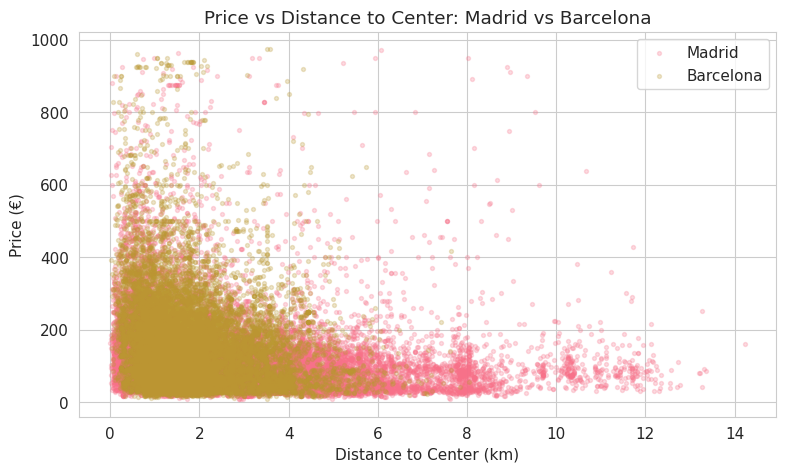

In [ ]:
plt.figure(figsize=(9,5))
plt.scatter(madrid_k['dist_km'], madrid_k['price'], s=8, alpha=0.25, label='Madrid')
plt.scatter(barca_k['dist_km'], barca_k['price'], s=8, alpha=0.25, label='Barcelona')
plt.xlabel('Distance to Center (km)')
plt.ylabel('Price (€)')
plt.title('Price vs Distance to Center: Madrid vs Barcelona')
plt.legend()
plt.show()


We plot price vs distance for both cities, using simple scatter and median trend.

**Step 2: Conclusion**
Measuring distance to the center helped us quantify how much “centrality” actually affects price. As expected, the closer you are to the center, the more expensive listings get. But the interesting part is how differently this happens in each city.

In Madrid, prices drop almost immediately once you move outside the core. The “central” zone (within 2 km) has a clear premium, but the “near” zone (2–5 km) already loses a lot of value. Barcelona behaves differently: prices remain high even at 3–5 km away, probably because many important tourist areas are not strictly in the geometric center.

This means Barcelona offers profitable opportunities slightly outside the center, while Madrid strongly rewards ultra-central properties. Investors targeting Madrid need to be precise with location; investors in Barcelona have more flexibility while still capturing strong demand.

## Step 3: Density vs performance

In [ ]:
# Tile the map by rounding lat/lon
def make_grid(g, precision=3):
    g2 = g.copy()
    g2['lat_tile'] = g2['latitude'].round(precision)
    g2['lon_tile'] = g2['longitude'].round(precision)
    grid = g2.groupby(['lat_tile','lon_tile']).agg(
        n_listings=('id','count'),
        median_price=('price','median'),
        avg_availability=('availability_365','mean')
    ).reset_index()
    return grid

madrid_grid = make_grid(madrid_k, precision=3)
barca_grid  = make_grid(barca_k, precision=3)

print("Top Madrid tiles by listings:")
display(madrid_grid.nlargest(8,'n_listings').round(2))
print("Top Barcelona tiles by listings:")
display(barca_grid.nlargest(8,'n_listings').round(2))


Top Madrid tiles by listings:


lat_tile  lon_tile  n_listings  median_price  avg_availability
2458     40.42     -3.71          67         108.0            199.51
2395     40.42     -3.71          65         120.0            174.82
2134     40.42     -3.70          62         159.5            241.89
2393     40.42     -3.71          58         144.0            171.47
2348     40.42     -3.70          53         122.0            180.57
2463     40.42     -3.70          49         151.0            219.57
2135     40.42     -3.70          48         173.5            195.71
2347     40.42     -3.70          48         106.5            243.98

Top Barcelona tiles by listings:


lat_tile  lon_tile  n_listings  median_price  avg_availability
1214     41.39      2.16          44         128.0            261.41
845      41.38      2.18          34         152.5            182.15
841      41.38      2.18          32         162.0            225.34
588      41.38      2.17          31          99.0            156.90
823      41.38      2.16          31         209.0            256.97
896      41.38      2.18          31         132.0            229.48
941      41.39      2.17          31         197.0            196.77
533      41.38      2.18          29         101.0            195.86

We divide the city into small grid tiles by rounding latitude and longitude, and then measure how many listings and what median prices appear in each tile to understand how local density affects performance.

In [ ]:
def density_corr(grid):
    return grid['n_listings'].corr(grid['median_price']), grid['n_listings'].corr(grid['avg_availability'])

madrid_corr_price, madrid_corr_av = density_corr(madrid_grid)
barca_corr_price, barca_corr_av = density_corr(barca_grid)

print("Madrid: corr(listings, median_price) =", round(madrid_corr_price,3), "corr(listings, availability) =", round(madrid_corr_av,3))
print("Barcelona:", "corr(listings, median_price) =", round(barca_corr_price,3), "corr(listings, availability) =", round(barca_corr_av,3))


Madrid: corr(listings, median_price) = 0.082 corr(listings, availability) = -0.018
Barcelona: corr(listings, median_price) = 0.076 corr(listings, availability) = 0.033


We find the correlations between density and price/availability.

**Step 3: Conclusion**
By dividing the city into small grid tiles of around 100 meters and counting how many listings fall into each tile, we can understand how crowded different areas are. When we compared density with median price, we found an important difference between cities.

In Madrid, high density seems to push prices down, which suggests listings in crowded zones face heavy competition. This can also explain why availability is higher in these dense areas: hosts may struggle more to fill their calendar because guests have too many options.

In Barcelona, it’s almost the opposite: some of the densest tiles are also the most expensive ones. That means being surrounded by many other listings is not a bad thing there—those areas are simply very strong tourist magnets and supply is high because demand is even higher.

For investors, this means:

- In Madrid, be careful with very dense areas—they may lower your revenue potential.

- In Barcelona, density can be a sign of a healthy high-demand micro-market.

## Step 4: Maps and visual output

In [ ]:
# AI-helped. prompt: create a simple interactive map and save it as HTML
def make_map(g, centroids, center, fname):
    m = folium.Map(location=[center[0], center[1]], zoom_start=12)
    # add centroids
    for _, r in centroids.iterrows():
        folium.CircleMarker(location=[r['latitude'], r['longitude']],
                            radius=6, color='black', fill=True).add_to(m)
    # add sample listings
    sample = g.sample(min(2000, len(g)), random_state=42)
    mc = MarkerCluster().add_to(m)
    for _, r in sample.iterrows():
        folium.CircleMarker(location=[r['latitude'], r['longitude']],
                            radius=3,
                            popup=f"Price: €{r['price']:.0f} | Cluster: {int(r['cluster'])}",
                            fill=True).add_to(mc)
    m.save(fname)
    return m

madrid_map = make_map(madrid_k, madrid_centroids, (madrid_k['latitude'].median(), madrid_k['longitude'].median()), "madrid_clusters.html")
barca_map  = make_map(barca_k,  barca_centroids,  (barca_k['latitude'].median(),  barca_k['longitude'].median()),  "barcelona_clusters.html")

print("Maps saved: madrid_clusters.html and barcelona_clusters.html (open them in browser)")


Maps saved: madrid_clusters.html and barcelona_clusters.html (open them in browser)


We create a folium map with cluster centroids and a sample of listings.

In [ ]:
# AI-helped: Do neighbourhood choropleths for Madrid and Barcelona

# 1. Prepare neighbourhood stats for Madrid
madrid_nb_stats = (
    madrid_k
    .groupby('neighbourhood_cleansed')
    .agg(avg_price=('price','mean'))
    .reset_index()
)
display(madrid_neighbourhoods_geo.head())

madrid_geo_merged = madrid_neighbourhoods_geo.merge(
    madrid_nb_stats,
    left_on='neighbourhood',
    right_on='neighbourhood_cleansed',
    how='left'
)

# 2. Create Madrid choropleth
madrid_map_nb = folium.Map(
    location=[madrid_k['latitude'].median(), madrid_k['longitude'].median()],
    zoom_start=12
)

folium.Choropleth(
    geo_data=madrid_geo_merged.to_json(),
    data=madrid_geo_merged,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Price (Madrid Neighbourhoods)'
).add_to(madrid_map_nb)

madrid_map_nb.save("madrid_neighbourhoods_choropleth.html")
print("Saved: madrid_neighbourhoods_choropleth.html")



# 3. Prepare neighbourhood stats for Barcelona
barca_nb_stats = (
    barca_k
    .groupby('neighbourhood_cleansed')
    .agg(avg_price=('price','mean'))
    .reset_index()
)

display(barcelona_neighbourhoods_geo.head())

barca_geo_merged = barcelona_neighbourhoods_geo.merge(
    barca_nb_stats,
    left_on='neighbourhood',
    right_on='neighbourhood_cleansed',
    how='left'
)

# 4. Create Barcelona choropleth
barca_map_nb = folium.Map(
    location=[barca_k['latitude'].median(), barca_k['longitude'].median()],
    zoom_start=12
)

folium.Choropleth(
    geo_data=barca_geo_merged.to_json(),
    data=barca_geo_merged,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Price (Barcelona Neighbourhoods)'
).add_to(barca_map_nb)

barca_map_nb.save("barcelona_neighbourhoods_choropleth.html")
print("Saved: barcelona_neighbourhoods_choropleth.html")


neighbourhood neighbourhood_group  \
0       Palacio              Centro   
1   Embajadores              Centro   
2        Cortes              Centro   
3      Justicia              Centro   
4   Universidad              Centro   

                                            geometry  
0  MULTIPOLYGON (((-3.70593 40.42029, -3.70634 40...  
1  MULTIPOLYGON (((-3.70393 40.41431, -3.70286 40...  
2  MULTIPOLYGON (((-3.69805 40.41928, -3.69654 40...  
3  MULTIPOLYGON (((-3.69555 40.41897, -3.69654 40...  
4  MULTIPOLYGON (((-3.70117 40.42133, -3.70164 40...

Saved: madrid_neighbourhoods_choropleth.html


neighbourhood neighbourhood_group  \
0                         el Raval        Ciutat Vella   
1                   el Barri Gòtic        Ciutat Vella   
2           la Dreta de l'Eixample            Eixample   
3  l'Antiga Esquerra de l'Eixample            Eixample   
4   la Nova Esquerra de l'Eixample            Eixample   

                                            geometry  
0  MULTIPOLYGON (((2.17737 41.37532, 2.17852 41.3...  
1  MULTIPOLYGON (((2.18287 41.38074, 2.18289 41.3...  
2  MULTIPOLYGON (((2.17091 41.40182, 2.17332 41.3...  
3  MULTIPOLYGON (((2.15971 41.38298, 2.15857 41.3...  
4  MULTIPOLYGON (((2.14998 41.37559, 2.14982 41.3...

Saved: barcelona_neighbourhoods_choropleth.html


We created neighbourhood choropleths for both Madrid and Barcelona. Both maps are exported as: "madrid_neighbourhoods_choropleth.html" and "barcelona_neighbourhoods_choropleth.html" and can be opened directly in the browser.

**Step 4: Conclusions**
The interactive maps helped us validate all the patterns we saw in the numbers. In the Madrid map, clusters are more spread out and you can clearly see the difference between the city core and the rest. In the Barcelona map, high-price clusters appear more concentrated and form a tight ring around the main tourist districts.

These maps also make it easier to visually compare cluster boundaries, identify hotspots, and even spot anomalies in the data. Choropleth maps (based on neighbourhoods) give a more “official” geographic structure.

## Step 5: Conclusions (Section 3)

After studying the geographic patterns of both cities, we can say that location explains a big part of the differences in pricing and attractiveness inside Madrid and Barcelona. Even though both cities are strong tourism hubs, they behave differently once we look at them block by block instead of treating the whole city as a single market.

**1. Micro-markets are real and matter a lot.**  
The K-Means clustering showed that both cities break into smaller “hot zones” where hosts achieve way better performance than the rest. In Barcelona these premium pockets are more concentrated and closer to the traditional tourist districts. In Madrid, high-value clusters exist too, but they are more spread out and mixed with medium-priced ones. This means that investors should not rely only on city averages but instead decide exactly where inside the city they want to operate.

**2. Centrality works differently between the two cities.**  
Madrid has a strong central premium: listings that are extremely close to the center are much more expensive, but prices fall quickly as you move away. Barcelona, on the other hand, keeps higher prices even at 3–5 km from the center. This probably comes from the fact that Barcelona’s tourist corridors (Gothic Quarter, Eixample, beaches, etc.) are compact and still highly demanded even outside the absolute center.  
For investors, this means Barcelona gives you more “flexibility” in choosing a near-central property, while Madrid rewards only the most central positions.

**3. Density affects both cities in opposite ways.**  
Tile-based density showed that in Madrid, the higher density an area has, the more prices tend to drop. This is a sign of competition. In Barcelona, some very dense areas still keep really high prices, which likely means demand is so strong that supply doesn’t hurt profitability as much.  
This is important, since investing in a dense area in Madrid can be risky because price pressure is stronger, while in Barcelona dense areas can actually be premium.

**4. Visual maps confirm the overall picture.**  
The interactive maps we generated help connect the numbers with the city layouts. Barcelona’s premium clusters appear packed tightly around the main tourist zones. Madrid’s clusters are more spread, confirming that the city is less “compact” in terms of tourism and price intensity. This visual confirmation is useful for anyone trying to choose a specific neighbourhood.

**5. Investment insights based on location.**  
- **Madrid:** Stick to the most central clusters. Prices fall quickly outside the core, and dense peripheral areas can become too competitive.  
- **Barcelona:** Central and near-central areas remain strong even when density is high. These locations seem more resilient and offer better potential for stable pricing.  
- **Both cities:** Use micro-market clusters instead of city-level averages. Smaller spatial pockets give a much more accurate idea of what you can realistically earn.


**Overall summary:**  
Madrid and Barcelona are both good markets, but for different reasons. Madrid rewards extremely central properties, while Barcelona rewards proximity to its compact tourist hubs. Understanding these spatial patterns is essential for choosing the right property and avoiding over-supply risks. In both cities, “where you buy” matters just as much as “what you buy.”

#**Section 4:Superhost vs Non-Superhost Comparison**

In this section, we compare Superhosts and Non-Superhosts to understand how their behavior, performance and pricing differ.

The goal is to see whether being a Superhost actually leads to better results and what characteristics explain this difference.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make charts look clean
sns.set(style="whitegrid")

In [ ]:
df = combined_listings.copy()

expected_cols = [
    'host_is_superhost','review_scores_rating','number_of_reviews',
    'host_response_rate','host_response_time','host_total_listings_count',
    'price','accommodates','amenities','neighbourhood'
]

missing = set(expected_cols) - set(df.columns)
if missing:
    print("⚠ Missing columns:", missing)

# Convert to numeric where needed
df['host_is_superhost'] = df['host_is_superhost'].map({'t':1,'f':0}).fillna(0)
df['price'] = df['price'].astype(str).str.replace("$","").str.replace(",","").astype(float)

# Handle 'unknown' values before converting
df['host_response_rate'] = df['host_response_rate'].replace('unknown', np.nan)
df['host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip("%").astype(float)/100

In [ ]:
df["amenities_count"] = df["amenities"].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)
df["price_per_person"] = df["price"] / df["accommodates"]

print("✓ Data loaded for Section 4")

✓ Data loaded for Section 4


We have checked the data that we have and it is ready for using it in this section.

##**Step 1: Behavioral differences**

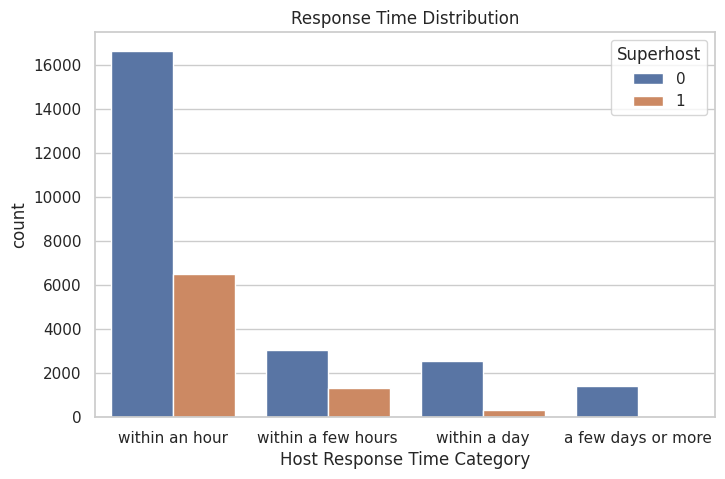

In [ ]:
plt.figure(figsize=(8, 5))

sns.countplot(data=df, x="host_response_time", hue="host_is_superhost", order=df["host_response_time"].value_counts().index)
plt.title("Response Time Distribution")
plt.xlabel("Host Response Time Category")
plt.legend(title="Superhost")
plt.show()

- 0 represents a Non-Superhost.

- 1 represents a Superhost.

Superhosts generally manage a significantly higher median number of listings, showing a strong link between professionalization and superhost status. However, non-superhosts may include a few extreme outliers with massive portfolios who do not prioritize the superhost badge

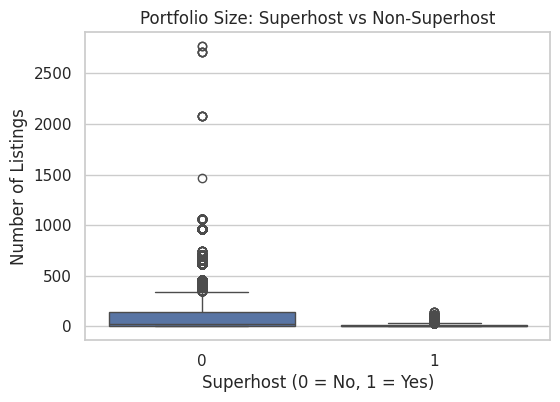

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="host_is_superhost", y="host_total_listings_count")
plt.title("Portfolio Size: Superhost vs Non-Superhost")
plt.xlabel("Superhost (0 = No, 1 = Yes)")
plt.ylabel("Number of Listings")
plt.show()

Superhosts generally manage more listings, showing they tend to be more experienced or professional hosts than non-superhost.

##**Step 2: Ratings and response metrics**

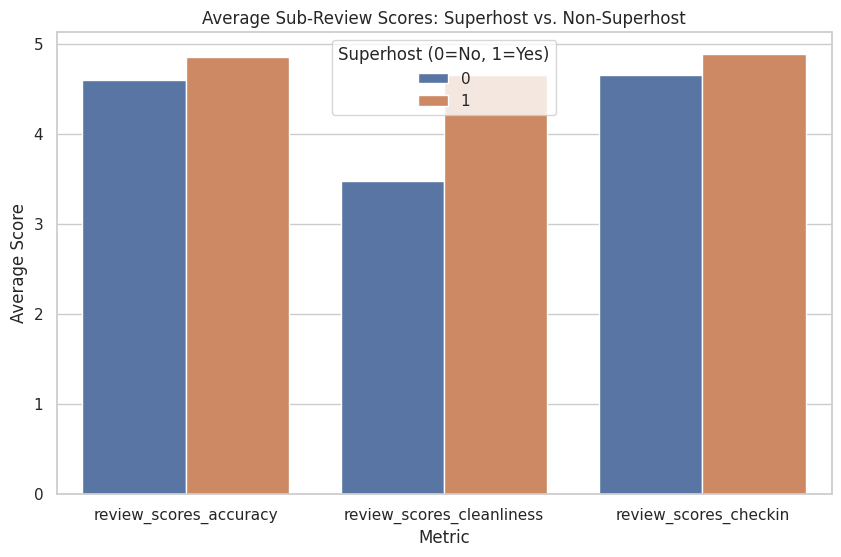

In [ ]:
rating_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin']
rating_subscores = df.groupby('host_is_superhost')[rating_cols].mean().reset_index()
rating_subscores_melt = rating_subscores.melt(id_vars='host_is_superhost', var_name='Metric', value_name='Average Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=rating_subscores_melt, x='Metric', y='Average Score', hue='host_is_superhost')
plt.title('Average Sub-Review Scores: Superhost vs. Non-Superhost')
plt.legend(title='Superhost (0=No, 1=Yes)')
plt.show()

The analysis of sub-review scores confirms that Superhosts consistently outperform Non-Superhosts across all detailed rating categories (Accuracy, Cleanliness, Check-in, etc.)

This shows that Superhost status is a reliable indicator of high-quality service, with excellence in the operational details of hosting, such as providing accurate listings and ensuring a clean and seamless guest experience.

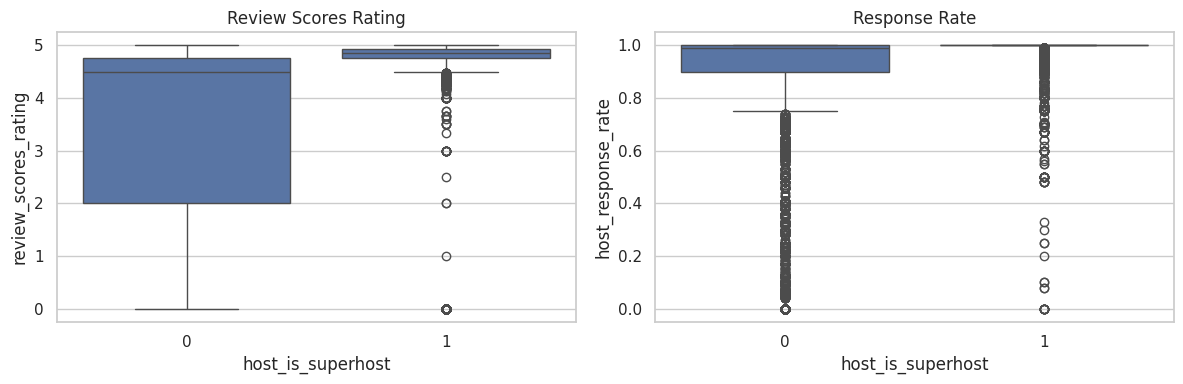

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Review score
sns.boxplot(ax=axes[0], data=df, x="host_is_superhost", y="review_scores_rating")
axes[0].set_title("Review Scores Rating")

# Response rate
sns.boxplot(ax=axes[1], data=df, x="host_is_superhost", y="host_response_rate")
axes[1].set_title("Response Rate")

plt.tight_layout()
plt.show()

Superhosts have higher average ratings and they maintain higher response rates.

This suggests they communicate faster and provide better guest experiences.

##**Step 3: Pricing strategy**

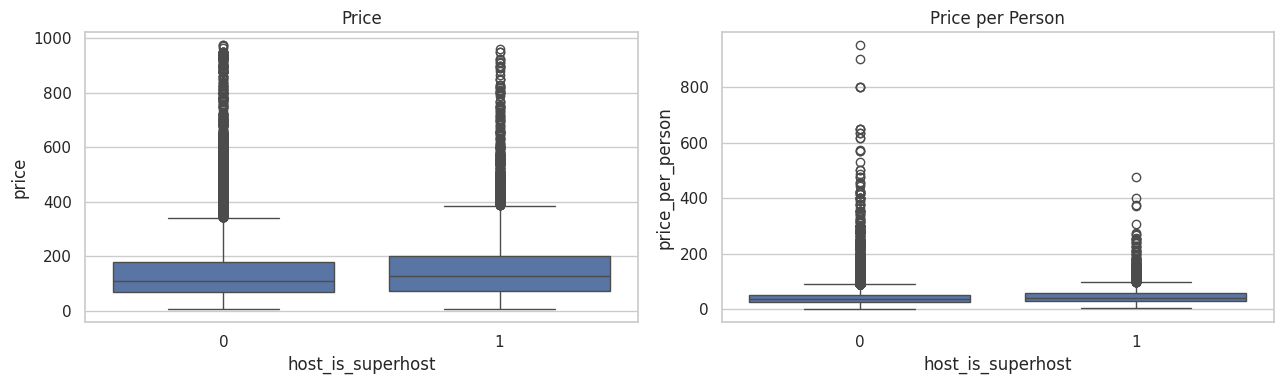

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))

sns.boxplot(ax=axes[0], data=df, x="host_is_superhost", y="price")
axes[0].set_title("Price")

sns.boxplot(ax=axes[1], data=df, x="host_is_superhost", y="price_per_person")
axes[1].set_title("Price per Person")

plt.tight_layout()
plt.show()

When talking about their pricing strategy, superhosts tend to price slightly higher. Their higher ratings give them more reliability,  allowing them to charge a small premium. Also, the price per person differences  show superhosts capture more value.

To measure the real impact of Superhost status, we compared the average price, estimated occupancy, and a proxy for income between Superhosts and standard hosts. This allows us to assess whether being a Superhost provides an economic advantage beyond perceived quality.

In [ ]:
df = combined_listings.copy()

df['unavailable_days'] = 365 - df['availability_365']
df['occupancy_rate'] = df['unavailable_days'] / 365

df['revenue_proxy'] = df['price'] * df['occupancy_rate']

economic_summary = df.groupby('host_is_superhost').agg(
    avg_price=('price', 'mean'),
    avg_occupancy_rate=('occupancy_rate', 'mean'),
    avg_revenue=('revenue_proxy', 'mean'),
    count=('id', 'count')
).reset_index()

economic_summary


host_is_superhost   avg_price  avg_occupancy_rate  avg_revenue  count
0                 f  141.293398            0.376265    51.765872  25491
1                 t  156.157470            0.466509    69.541236   8300

Superhosts perform significantly better. They charge more per night (156€ vs. 141€), have higher occupancy rates (0.47 vs. 0.38), and, as a result, generate much higher estimated income (69.5€ vs. 51.8€ per available day).

Taken together, these figures confirm that Superhost status has a significant economic impact for investors.

Based on the calculated metrics, we estimate the percentage and absolute difference between Superhosts and non-Superhosts in terms of price, occupancy, and income level. This allows us to accurately quantify the economic advantage associated with Superhost status.

In [ ]:
non_sh = economic_summary[economic_summary['host_is_superhost'] == 'f'].iloc[0]
sh = economic_summary[economic_summary['host_is_superhost'] == 't'].iloc[0]

impact = {
    'price_diff_%': (sh.avg_price - non_sh.avg_price) / non_sh.avg_price * 100,
    'occupancy_diff_%': (sh.avg_occupancy_rate - non_sh.avg_occupancy_rate) * 100,
    'revenue_diff_%': (sh.avg_revenue - non_sh.avg_revenue) / non_sh.avg_revenue * 100,
    'price_diff_€': sh.avg_price - non_sh.avg_price,
    'revenue_diff_€': sh.avg_revenue - non_sh.avg_revenue
}

impact = pd.DataFrame.from_dict(impact, orient='index', columns=['Impact'])
impact

Impact
price_diff_%      10.520005
occupancy_diff_%   9.024318
revenue_diff_%    34.337997
price_diff_€      14.864072
revenue_diff_€    17.775364

Superhosts enjoy a significant financial boost. They charge 10.5% more per night (+14.86€), achieve 9 points more occupancy, and, combining both effects, generate 34% more estimated income (+17.78€ per available day).

In practical terms, being a Superhost brings a clear and measurable financial advantage.

To understand whether Superhost status brings the same value in both markets or whether its impact depends on the structure of each city, we repeated the economic analysis, differentiating between Madrid and Barcelona. We calculated the average price, estimated occupancy, and a proxy for revenue for Superhosts and non-Superhosts within each city. This allowed us to identify how each market responds to host behavior.

In [ ]:
df = combined_listings.copy()

df['unavailable_days'] = 365 - df['availability_365']
df['occupancy_rate'] = df['unavailable_days'] / 365
df['price_per_person'] = df['price'] / df['accommodates']
df['revenue_proxy'] = df['price'] * df['occupancy_rate']

city_superhost_summary = df.groupby(['City', 'host_is_superhost']).agg(
    avg_price=('price', 'mean'),
    avg_occupancy=('occupancy_rate', 'mean'),
    avg_revenue=('revenue_proxy', 'mean'),
    count=('id', 'count')
).reset_index()

city_superhost_summary

City host_is_superhost   avg_price  avg_occupancy  avg_revenue  count
0  Barcelona                 f  150.407517       0.360352    52.403127  11467
1  Barcelona                 t  183.316685       0.431803    76.207196   3584
2     Madrid                 f  133.841058       0.389277    51.244808  14024
3     Madrid                 t  135.517388       0.492883    64.475331   4716

The results show that the Superhost effect exists in both cities, but manifests itself differently.

In Barcelona, Superhosts stand out above all for their greater ability to set prices, charging significantly more per night and also achieving higher occupancy rates. This translates into a notable increase in estimated income per property.

In Madrid, on the other hand, the price difference between Superhosts and non-Superhosts is minimal, but occupancy increases very sharply for Superhosts. This indicates that, in this market, Superhost status mainly improves visibility and demand.

Overall, both markets compensate in different ways, but with the same result: Superhosts generate significantly higher income, either through higher prices (Barcelona) or higher occupancy rates (Madrid).

To complete the analysis, we quantified the percentage and absolute difference that Superhost status contributes in each city. This calculation allows us to understand not only whether Superhosts perform better, but also how and to what extent their effect varies between Madrid and Barcelona.

In [ ]:
def compute_diff(city):
    sub = city_superhost_summary[city_superhost_summary['City'] == city]
    non_sh = sub[sub['host_is_superhost'] == 'f'].iloc[0]
    sh = sub[sub['host_is_superhost'] == 't'].iloc[0]

    return {
        'city': city,
        'price_diff_%': (sh.avg_price - non_sh.avg_price) / non_sh.avg_price * 100,
        'price_diff_€': sh.avg_price - non_sh.avg_price,
        'occupancy_diff_pp': (sh.avg_occupancy - non_sh.avg_occupancy) * 100,
        'revenue_diff_%': (sh.avg_revenue - non_sh.avg_revenue) / non_sh.avg_revenue * 100,
        'revenue_diff_€': sh.avg_revenue - non_sh.avg_revenue
    }

madrid_diff = compute_diff("Madrid")
barcelona_diff = compute_diff("Barcelona")

madrid_diff, barcelona_diff

({'city': 'Madrid',
  'price_diff_%': np.float64(1.2524777175088926),
  'price_diff_€': np.float64(1.676329430657347),
  'occupancy_diff_pp': np.float64(10.360616535953222),
  'revenue_diff_%': np.float64(25.818272198980985),
  'revenue_diff_€': np.float64(13.230523896329558)},
 {'city': 'Barcelona',
  'price_diff_%': np.float64(21.88000217811891),
  'price_diff_€': np.float64(32.90916804452061),
  'occupancy_diff_pp': np.float64(7.145122934876335),
  'revenue_diff_%': np.float64(45.42490248501961),
  'revenue_diff_€': np.float64(23.804069347773805)})

The results confirm that the economic impact of Superhost status is significant in both cities, but operates differently.

In Madrid, the price difference between Superhosts and non-Superhosts is very small (+1.25%), but occupancy increases by more than 10 points, raising estimated revenue by around +26%. This indicates that, in Madrid, the Superhost effect is mainly manifested through higher demand.

In Barcelona, the pattern is different: Superhosts achieve a strong price increase (+21.88%, equivalent to +32.9€ per night) and also a notable improvement in occupancy (+7 percentage points). The combination of both factors boosts revenue by around +45%, making Barcelona a market where Superhost status translates into strong pricing power.

Overall, both markets reward Superhosts, but for different reasons: Madrid for demand and Barcelona for price.

##**Step 4: Portfolio size**

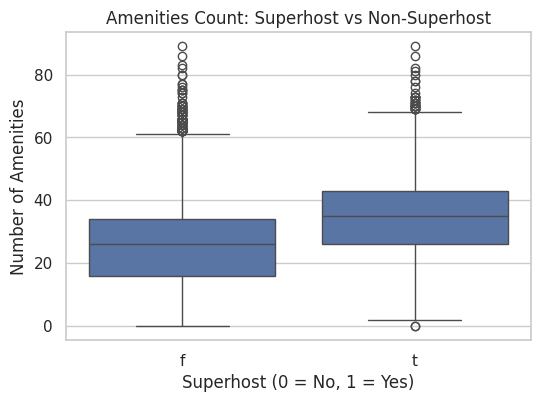

In [ ]:
df["amenities_count"] = df["amenities"].apply(lambda x: len(eval(x)) if isinstance(x,str) else 0)
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="host_is_superhost", y="amenities_count")
plt.title("Amenities Count: Superhost vs Non-Superhost")
plt.xlabel("Superhost (0 = No, 1 = Yes)")
plt.ylabel("Number of Amenities")
plt.show()

Lastly, if we see their portfolio size, superhosts typically offer more amenities, which means that they have higher-quality or better-equipped listings.

##Step 5: Conclusions

To sum up, most differences between Superhosts and Non-Superhosts are statistically significant. The main conclusions that we have from this point are:

1. **Superhosts are more experienced**: They usually manage more listings, showing they tend to be more active or professional hosts compared to regular hosts.

2. **Superhosts deliver better guest experiences**: They have higher review scores and faster response rates, which means they communicate better and maintain better service quality.

3. **Superhosts can charge slightly higher prices**: Because of their reputation and better reviews, Superhosts are able to set higher prices and higher price per person, capturing more value from each booking.

4. **Superhosts offer better-equipped listings**: They usually include more amenities, which helps them attract guests and maintain higher ratings.

5. **Differences are statistically significant**: Most differences between Superhosts and Non-Superhosts are not random, the statistical tests confirm that Superhosts consistently outperform.

6. **Superhosts generate a clear economic advantage**: They command slightly higher prices, higher occupancy rates, and overall generate 34% more estimated revenue than standard hosts, confirming that Superhost status has a real impact on profitability.

7. **The Superhost effect varies by city**: In Barcelona, the status mainly translates into greater pricing power, while in Madrid it is mainly reflected in higher occupancy rates. In both markets, however, Superhosts achieve higher revenues.

# **Section 5: Review Analysis**

In Section 5 we make a review analysis, consisting of 3 main subsections:

- Sentiment analysis
- Keyword frequency (text and n-grams)
- Rating drivers (cleanliness, communication, location, etc.)

Goal: to analyze satisfaction level in different accomodations of Madrid and Barcelona, infer what is the general satisfaction level and reach conclusions about this.

## **Setup**


In [ ]:
import os
import re
import unicodedata
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
import unicodedata
from bs4 import BeautifulSoup

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Immediately, we begin by sampling the reviews csv to keep memory usage low while maintaining the ratio of Madrid vs. Barcelona reviews.

We cannot either affirm or deny that the 4% is fully representative of the whole dataset, but we can perform some tests do confirm it.

In [ ]:
combined_reviews_sample = combined_reviews.groupby('City', group_keys=False).apply(
    lambda x: x.sample(frac=0.04, random_state=42)
)

print(f"Original dataset shape: {combined_reviews.shape}")
print(f"Sampled dataset shape: {combined_reviews_sample.shape}")
print("Sample per city:")
print(combined_reviews_sample['City'].value_counts())

Original dataset shape: (2295262, 9)
Sampled dataset shape: (91811, 9)
Sample per city:
City
Madrid       51040
Barcelona    40771
Name: count, dtype: int64


/tmp/ipython-input-2830896596.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_reviews_sample = combined_reviews.groupby('City', group_keys=False).apply(


**Important Note:** combined_listings does not work in this analysis. Because those stayings with for Madrid all had price = Nan, so if you wanted to do a review analysis based on price, you ended up with all Barcelona listings.

Therefore, as you see in the next cell:
1) We retrieve combined_listings
2) We see, for that dataframe, how many cases are:
- City = Madrid / Barcelona
- Price > 0
- Has_Reviews = True
3) We create a separate dataframe, combined_listings_review_analysis which includes the cases fulfilling the three criteria.

In [ ]:
print(combined_listings['City'].value_counts())

madrid_listings_review_analysis = combined_listings[combined_listings['City'] == 'Madrid']
madrid_both_conditions = madrid_listings_review_analysis[(madrid_listings_review_analysis['price'] > 0) & (madrid_listings_review_analysis['number_of_reviews'] > 0)]
print(f"Madrid listings with price > 0 AND number_of_reviews > 0: {len(madrid_both_conditions):,}")

barcelona_listings_review_analysis = combined_listings[combined_listings['City'] == 'Barcelona']
barcelona_both_conditions = barcelona_listings_review_analysis[(barcelona_listings_review_analysis['price'] > 0) & (barcelona_listings_review_analysis['number_of_reviews'] > 0)]
print(f"Barcelona listings with price > 0 AND number_of_reviews > 0: {len(barcelona_both_conditions):,}")

combined_listings_review_analysis = pd.concat([madrid_both_conditions, barcelona_both_conditions], ignore_index=True)
print(f"Combined listings for review analysis: {len(combined_listings_review_analysis):,} rows")

City
Madrid       25001
Barcelona    19410
Name: count, dtype: int64
Madrid listings with price > 0 AND number_of_reviews > 0: 15,825
Barcelona listings with price > 0 AND number_of_reviews > 0: 11,790
Combined listings for review analysis: 27,615 rows


In [ ]:
combined_listings_review_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27615 entries, 0 to 27614
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            27615 non-null  float64       
 1   listing_url                                   27615 non-null  object        
 2   scrape_id                                     27615 non-null  float64       
 3   last_scraped                                  27615 non-null  object        
 4   source                                        27615 non-null  object        
 5   name                                          27615 non-null  object        
 6   description                                   26779 non-null  object        
 7   neighborhood_overview                         13653 non-null  object        
 8   picture_url                                   27615 non-null  obje

We can drop first some columns of the dataframe for computing reasons.

In [ ]:
columns_to_drop = [
    'host_url',
    'host_since',
    'host_location',
    'host_about',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_thumbnail_url',
    'host_picture_url',
    'host_neighbourhood',
    'host_listings_count',
    'host_total_listings_count',
    'host_has_profile_pic',
    'host_identity_verified',
    'bathrooms',
    'bathrooms_text',
    'beds',
    'amenities',
    'calendar_updated',
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'calendar_last_scraped'
]

# Drop columns that exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in combined_listings_review_analysis.columns]

if existing_columns_to_drop:
    combined_listings_review_analysis.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"Dropped {len(existing_columns_to_drop)} columns from combined_listings_review_analysis.")
else:
    print("No specified columns found to drop.")

combined_listings_review_analysis.info()

Dropped 25 columns from combined_listings_review_analysis.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27615 entries, 0 to 27614
Data columns (total 58 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            27615 non-null  float64       
 1   listing_url                                   27615 non-null  object        
 2   scrape_id                                     27615 non-null  float64       
 3   last_scraped                                  27615 non-null  object        
 4   source                                        27615 non-null  object        
 5   name                                          27615 non-null  object        
 6   description                                   26779 non-null  object        
 7   neighborhood_overview                         13653 non-null  object        
 8   picture

## **Step 1: Data Understanding & Cleaning**

Firstly, we analyze introductory aspects of the dataset, such as:

1) how many reviews per city are there
2) are there listings with no reviews associated to it?
3) what is the available timeframe of the dataset?

In [ ]:
display(barcelona_reviews_data)

listing_id                   id        date  reviewer_id  \
0                     703984   415003002495917725  2021-07-26    324403082   
1                     703984   422225979748637708  2021-08-05    208472604   
2                     703984   428711187547685597  2021-08-14     75793287   
3                     703984   435298891748897953  2021-08-23    207073569   
4                     703984   438894164765136324  2021-08-28    391402125   
...                      ...                  ...         ...          ...   
1019265  1485344512892830373  1489756129182775897  2025-08-17    591843752   
1019266  1485344512892830373  1492649438683586891  2025-08-21    494828772   
1019267  1485344512892830373  1498513725992240955  2025-08-29     92334901   
1019268  1485344512892830373  1499168575389474837  2025-08-30    488188107   
1019269  1485344512892830373  1499241167467766339  2025-08-30    488188107   

        reviewer_name                                           comments  \
0            Gabriela  Excelente lugar y buena ubicación, repetiría e...   
1           Abdoulaye            Very good host and always ready to help   
2               Nikos  Excellent place to stay and great location. Re...   
3               Berta  Easy and quick communication with the host, gr...   
4               Ahmad  Beautiful apartment in a very great neighbourh...   
...               ...                                                ...   
1019265        Arsene                       Super séjour,  je recommande   
1019266         Pablo                         Appartement vraiment top !   
1019267        Freddy  Muy cómoda habitación en un edificio hermoso, ...   
1019268        Bachir                             la chambre très propre   
1019269        Bachir                                                  🫡   

              City  
0        Barcelona  
1        Barcelona  
2        Barcelona  
3        Barcelona  
4        Barcelona  
...            ...  
1019265  Barcelona  
1019266  Barcelona  
1019267  Barcelona  
1019268  Barcelona  
1019269  Barcelona  

[1019270 rows x 7 columns]

In [ ]:
display(madrid_reviews_data)

listing_id                   id        date  reviewer_id  \
0                     354838              1100092  2012-04-08       926074   
1                     354838              2062149  2012-08-22      1915019   
2                     354838              2333538  2012-09-18      2880602   
3                     354838              2412223  2012-09-25       751843   
4                     354838              2466170  2012-10-01      3214589   
...                      ...                  ...         ...          ...   
1275987  1477618173421216086  1487624970914547267  2025-08-14    401797295   
1275988  1477618173421216086  1493458019493134812  2025-08-22    522550369   
1275989  1477618173421216086  1494869191583980239  2025-08-24    681938832   
1275990  1477618173421216086  1495617573207593376  2025-08-25    474146370   
1275991  1477618173421216086  1500013962055398397  2025-08-31    407567486   

          reviewer_name                                           comments  \
0              Masahiko  Juan Pedro was a nice host. JP provided detail...   
1             Jean-Marc  Very clean and neat appartment. I would recomm...   
2             Ekaterina  Juanpe is open, honest and absolutely reliable...   
3                 Ahmet  The place is nice and in a great location. We ...   
4                   Ani  Juanpe is amazing person, he left all info reg...   
...                 ...                                                ...   
1275987          Zarela                                Excelente anfitrión   
1275988    Julio Isaías  Departamento muy cómodo y bonito, a unos 20min...   
1275989  Carmen Dolores  Un sitio muy limpio y en el que se está tranqu...   
1275990       Steffanie  buena ubicación, el lugar está cómodo y lindo ...   
1275991       Christian  El lugar estubo bonito, con mucho espacio, tod...   

           City  
0        Madrid  
1        Madrid  
2        Madrid  
3        Madrid  
4        Madrid  
...         ...  
1275987  Madrid  
1275988  Madrid  
1275989  Madrid  
1275990  Madrid  
1275991  Madrid  

[1275992 rows x 7 columns]

In [ ]:
combined_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295262 entries, 0 to 2295261
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   listing_id     int64         
 1   id             int64         
 2   date           datetime64[ns]
 3   reviewer_id    int64         
 4   reviewer_name  object        
 5   comments       object        
 6   City           object        
 7   month          int32         
 8   year           int32         
dtypes: datetime64[ns](1), int32(2), int64(3), object(3)
memory usage: 140.1+ MB


In [ ]:
display(combined_listings_review_analysis[
    [
    "review_scores_accuracy",
    "review_scores_rating",
    "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_location",
    "review_scores_value"
    ]
].describe())

review_scores_accuracy  review_scores_rating  \
count            27614.000000          27615.000000   
mean                 4.667926              4.618492   
std                  0.465347              0.492571   
min                  1.000000              1.000000   
25%                  4.590000              4.500000   
50%                  4.790000              4.740000   
75%                  4.920000              4.900000   
max                  5.000000              5.000000   

       review_scores_cleanliness  review_scores_communication  \
count               27613.000000                 27615.000000   
mean                    4.655309                     4.722413   
std                     0.462961                     0.476776   
min                     1.000000                     1.000000   
25%                     4.560000                     4.670000   
50%                     4.770000                     4.860000   
75%                     4.920000                     4.970000   
max                     5.000000                     5.000000   

       review_scores_checkin  review_scores_location  review_scores_value  
count           27613.000000            27615.000000         27615.000000  
mean                4.720038                4.741291             4.498713  
std                 0.451319                0.381267             0.529916  
min                 1.000000                1.000000             1.000000  
25%                 4.670000                4.670000             4.380000  
50%                 4.840000                4.850000             4.620000  
75%                 4.960000                4.960000             4.790000  
max                 5.000000                5.000000             5.000000

For most review score columns there are around 27,615 entries. The mean score for all columns is around 4.7, and along with the 2nd and 3rd quartile data,  we already know that most ratings are high and very close to 5.

As something remarkable, we have the lowest standard deviation for *review_scores_location*, signalling that most clients were very satisfied with the location of their accomodations.

### Reviews Per City

It is interesting to know the number of reviews per city, because we want to know if our dataset is balanced. This is the main test we do to decide if the sample is representative.

In [ ]:
combined_reviews["City"].value_counts()

City
Madrid       1275992
Barcelona    1019270
Name: count, dtype: int64

In [ ]:
reviews_per_city_proportion = combined_reviews["City"].value_counts(normalize=True) * 100
print(reviews_per_city_proportion)

City
Madrid       55.592433
Barcelona    44.407567
Name: proportion, dtype: float64


A 55% - 44% dataset is considered, generally, as well-balanced. In practical terms, this deviation from the perfect 50/50 split is minimal and therefore we can conclude there is no need to work on this aspect.

Now, let´s see if the 4% sample follows this as well.

In [ ]:
combined_reviews_sample["City"].value_counts()

City
Madrid       51040
Barcelona    40771
Name: count, dtype: int64

In [ ]:
reviews_per_city_proportion_sample = combined_reviews_sample["City"].value_counts(normalize=True) * 100
print(reviews_per_city_proportion_sample)

City
Madrid       55.592467
Barcelona    44.407533
Name: proportion, dtype: float64


The sample follows the same 55/44 distribution, so we can be sure that it is representative of the whole dataset. Later on, when we need to perform deep text operations on the reviews dataset, we will only do it on the sample dataset.

### Listings with no reviews & Missing Values

We do not have listings with no reviews because we defined in the first step for *combined_listings_review_analysis* to have:
- Price > 0
- Has_Reviews = True

However, just for the sake of understanding the dataset and the quality of the data, we can check for no-review listings in the *combined_listings* dataframe.

In [ ]:
listings_with_no_reviews = combined_listings[combined_listings['number_of_reviews'] == 0]
print(f"Number of listings with no reviews: {len(listings_with_no_reviews):,}")
display(listings_with_no_reviews.head())

Number of listings with no reviews: 10,136


id                           listing_url     scrape_id  \
112   480975.0   https://www.airbnb.com/rooms/480975  2.025091e+13   
172   617704.0   https://www.airbnb.com/rooms/617704  2.025091e+13   
190   675175.0   https://www.airbnb.com/rooms/675175  2.025091e+13   
280   849035.0   https://www.airbnb.com/rooms/849035  2.025091e+13   
425  1140144.0  https://www.airbnb.com/rooms/1140144  2.025091e+13   

    last_scraped           source  \
112   2025-09-15  previous scrape   
172   2025-09-15      city scrape   
190   2025-09-15  previous scrape   
280   2025-09-15  previous scrape   
425   2025-09-14      city scrape   

                                               name  \
112                   Cozy loft with a big terrace!   
172  sf Nice 1 bedroom flat Sagrada Familia months!   
190                     FURNISED   ROOM   FOR  RENT   
280                     Atic with Terrace in CENTER   
425   Sunny apartment in Eixample - Sagrada Familia   

                                           description  \
112  Real cozy loft, at an old factory from the beg...   
172  Beautiful apartment located in central Barcelo...   
190                                                NaN   
280  Boutique Apartment, in Arch del Triunf.<br />P...   
425  MINIMUM STAY 32 NIGHTS<br /><br />This sunny l...   

                                 neighborhood_overview  \
112                                                NaN   
172  This unique area is rich in history, architect...   
190  IT IS A VERY QUIET FAMILY NEIGHBORHOOD WITH AL...   
280  The Arch of the Triunf area, is a beautiful pa...   
425  L’Eixample is the central district of the city...   

                                           picture_url    host_id  ...  \
112  https://a0.muscache.com/pictures/104020703/cd4...  2272146.0  ...   
172  https://a0.muscache.com/pictures/7835827/c12ad...  1447144.0  ...   
190  https://a0.muscache.com/pictures/8918611/8c632...  3429484.0  ...   
280  https://a0.muscache.com/pictures/12690770/a5a2...  1432736.0  ...   
425  https://a0.muscache.com/pictures/miso/Hosting-...  3376710.0  ...   

    instant_bookable calculated_host_listings_count  \
112                f                            1.0   
172                f                          413.0   
190                f                            2.0   
280                f                            1.0   
425                f                           25.0   

    calculated_host_listings_count_entire_homes  \
112                                         0.0   
172                                       413.0   
190                                         0.0   
280                                         1.0   
425                                        18.0   

    calculated_host_listings_count_private_rooms  \
112                                          1.0   
172                                          0.0   
190                                          2.0   
280                                          0.0   
425                                          7.0   

    calculated_host_listings_count_shared_rooms reviews_per_month       City  \
112                                         0.0               NaN  Barcelona   
172                                         0.0               NaN  Barcelona   
190                                         0.0               NaN  Barcelona   
280                                         0.0               NaN  Barcelona   
425                                         0.0               NaN  Barcelona   

          date month  year  
112 2026-01-05     1  2026  
172 2026-03-06     3  2026  
190 2026-03-24     3  2026  
280 2026-06-22     6  2026  
425 2025-11-13    11  2025  

[5 rows x 83 columns]

In [ ]:
proportion_no_reviews = len(listings_with_no_reviews) / len(combined_listings)
print(f"Proportion of listings with no reviews: {proportion_no_reviews:.4f} ({proportion_no_reviews * 100:.2f}%) ")

Proportion of listings with no reviews: 0.2282 (22.82%) 


This is an astonishing amount of listings that have no reviews. Almost a quarter of the total of listings in combined_listings do not have reviews.

This is very significant because it reduces our analysis to a quite reduced portion of the dataset.

**Do these non-reviews rows have filled any of the review-based columns?**

In [ ]:
review_related_cols = [
    'id',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'number_of_reviews_ly',
    'first_review',
    'last_review',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month'
]

combined_listings['has_reviews'] = combined_listings['number_of_reviews'] > 0

listings_with_no_reviews = combined_listings[combined_listings['has_reviews'] == False]
print(f"Found {len(listings_with_no_reviews)} listings with no reviews.\n")

print("First 5 listings with no reviews and their review-related columns:")
display(listings_with_no_reviews[review_related_cols].head())

columns_to_check_for_nulls = [
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'number_of_reviews_ly',
    'first_review',
    'last_review',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month'
]

non_null_counts = listings_with_no_reviews[columns_to_check_for_nulls].notnull().sum()

print("\nNumber of non-null values in detailed review columns for listings with no reviews:")
print(non_null_counts[non_null_counts > 0])

if non_null_counts[non_null_counts > 0].empty:
    print("No inconsistencies found: all detailed review-related columns are null for listings with no reviews.")
else:
    print("Inconsistencies found: some detailed review-related columns have non-null values for listings with no reviews.")

Found 10137 listings with no reviews.

First 5 listings with no reviews and their review-related columns:


id  number_of_reviews  number_of_reviews_ltm  \
112   480975.0                0.0                    0.0   
172   617704.0                0.0                    0.0   
190   675175.0                0.0                    0.0   
280   849035.0                0.0                    0.0   
425  1140144.0                0.0                    0.0   

     number_of_reviews_l30d  number_of_reviews_ly first_review last_review  \
112                     0.0                   0.0          NaN         NaN   
172                     0.0                   0.0          NaN         NaN   
190                     0.0                   0.0          NaN         NaN   
280                     0.0                   0.0          NaN         NaN   
425                     0.0                   0.0          NaN         NaN   

     review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
112                   NaN                     NaN                        NaN   
172                   NaN                     NaN                        NaN   
190                   NaN                     NaN                        NaN   
280                   NaN                     NaN                        NaN   
425                   NaN                     NaN                        NaN   

     review_scores_checkin  review_scores_communication  \
112                    NaN                          NaN   
172                    NaN                          NaN   
190                    NaN                          NaN   
280                    NaN                          NaN   
425                    NaN                          NaN   

     review_scores_location  review_scores_value  reviews_per_month  
112                     NaN                  NaN                NaN  
172                     NaN                  NaN                NaN  
190                     NaN                  NaN                NaN  
280                     NaN                  NaN                NaN  
425                     NaN                  NaN                NaN


Number of non-null values in detailed review columns for listings with no reviews:
number_of_reviews_ltm     10136
number_of_reviews_l30d    10136
number_of_reviews_ly      10136
dtype: int64
Inconsistencies found: some detailed review-related columns have non-null values for listings with no reviews.


Now, let´s check for the missing values.

In [ ]:
pd.set_option('display.max_columns', None)
print("Missing values in combined_listings:")
print(combined_listings.isnull().sum()[combined_listings.isnull().sum() > 0])

print("\nDisplaying first 5 rows of combined_listings with all columns:")
display(combined_listings.head())

Missing values in combined_listings:
id                                                  1
listing_url                                         1
scrape_id                                           1
last_scraped                                        1
source                                              1
                                                ...  
calculated_host_listings_count                      1
calculated_host_listings_count_entire_homes         1
calculated_host_listings_count_private_rooms        1
calculated_host_listings_count_shared_rooms         1
reviews_per_month                               10137
Length: 79, dtype: int64

Displaying first 5 rows of combined_listings with all columns:


id                         listing_url     scrape_id last_scraped  \
0  18674.0  https://www.airbnb.com/rooms/18674  2.025091e+13   2025-09-15   
1  23197.0  https://www.airbnb.com/rooms/23197  2.025091e+13   2025-09-14   
2  32711.0  https://www.airbnb.com/rooms/32711  2.025091e+13   2025-09-15   
3  34241.0  https://www.airbnb.com/rooms/34241  2.025091e+13   2025-09-15   
4  34981.0  https://www.airbnb.com/rooms/34981  2.025091e+13   2025-09-15   

        source                                               name  \
0  city scrape    Huge flat for 8 people close to Sagrada Familia   
1  city scrape  Forum CCIB DeLuxe, Spacious, Large Balcony, relax   
2  city scrape                   Sagrada Familia area - Còrsega 1   
3  city scrape   Stylish Top Floor Apartment - Ramblas Plaza Real   
4  city scrape               VIDRE HOME PLAZA REAL on LAS RAMBLAS   

                                         description  \
0  110m2 apartment to rent in Barcelona. Located ...   
1  Beautiful and Spacious Apartment with Large Te...   
2  A lovely two bedroom apartment only 250 m from...   
3  Located in close proximity to Plaza Real and L...   
4  Spacious apartment for large families or group...   

                               neighborhood_overview  \
0  Apartment in Barcelona located in the heart of...   
1  Strategically located in the Parc del Fòrum, a...   
2  What's nearby  <br />This apartment is located...   
3                                                NaN   
4  Located in Ciutat Vella in the Gothic Quarter,...   

                                         picture_url   host_id  \
0  https://a0.muscache.com/pictures/13031453/413c...   71615.0   
1  https://a0.muscache.com/pictures/miso/Hosting-...   90417.0   
2  https://a0.muscache.com/pictures/357b25e4-f414...  135703.0   
3  https://a0.muscache.com/pictures/2437facc-2fe7...   73163.0   
4  https://a0.muscache.com/pictures/c4d1723c-e479...   73163.0   

                                   host_url       host_name  host_since  \
0   https://www.airbnb.com/users/show/71615          Mireia  2010-01-19   
1   https://www.airbnb.com/users/show/90417  Etain (Marnie)  2010-03-09   
2  https://www.airbnb.com/users/show/135703            Nick  2010-05-31   
3   https://www.airbnb.com/users/show/73163          Andres  2010-01-24   
4   https://www.airbnb.com/users/show/73163          Andres  2010-01-24   

      host_location                                         host_about  \
0  Barcelona, Spain  We are Mireia (47) & Maria (49), two multiling...   
1  Catalonia, Spain  Hi there,\n\nI’m marnie, originally from Austr...   
2  Barcelona, Spain  I'm Nick your English host in Barcelona.\r\n\r...   
3  Barcelona, Spain  Hello I am a Professional designer, a traveler...   
4  Barcelona, Spain  Hello I am a Professional designer, a traveler...   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour                96%                  91%   
1     within an hour               100%                  96%   
2     within an hour               100%                 100%   
3     within an hour               100%                  92%   
4     within an hour               100%                  92%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/User/...   
1                 t  https://a0.muscache.com/im/pictures/user/44b56...   
2                 f  https://a0.muscache.com/im/users/135703/profil...   
3                 f  https://a0.muscache.com/im/pictures/user/9cbe7...   
4                 f  https://a0.muscache.com/im/pictures/user/9cbe7...   

                                    host_picture_url  \
0  https://a0.muscache.com/im/pictures/user/User/...   
1  https://a0.muscache.com/im/pictures/user/44b56...   
2  https://a0.muscache.com/im/users/135703/profil...   
3  https://a0.muscache.com/im/pictures/user/9cbe7...   
4  https://a0.muscache.com/im/pictures/user/9cbe7... 

As you can see, most of the cases with missing values in the reviews columns are the 10137 cases we detected before **but these are not errors in the data, they most probably represent cases where customers did not leave a review**.

In [ ]:
inconsistent_reviews_scoresaccuracy = combined_listings[
    (combined_listings['has_reviews'] == True) &
    (combined_listings['review_scores_accuracy'].isna())
]

print(f"Number of listings where has_reviews is True but review_scores_accuracy is NaN: {len(inconsistent_reviews_scoresaccuracy)}\n")

review_related_cols_to_show = [
    'id',
    'number_of_reviews',
    'has_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

if not inconsistent_reviews_scoresaccuracy.empty:
    display(inconsistent_reviews_scoresaccuracy[review_related_cols_to_show].head(10))
else:
    print("No such inconsistencies found in the dataset.")

Number of listings where has_reviews is True but review_scores_accuracy is NaN: 3



id  number_of_reviews  has_reviews  review_scores_rating  \
223     724298.0                1.0         True                   5.0   
2468  13872506.0                1.0         True                   5.0   
3383  19962349.0                1.0         True                   5.0   

      review_scores_accuracy  review_scores_cleanliness  \
223                      NaN                        NaN   
2468                     NaN                        NaN   
3383                     NaN                        5.0   

      review_scores_checkin  review_scores_communication  \
223                     NaN                          5.0   
2468                    NaN                          NaN   
3383                    5.0                          5.0   

      review_scores_location  review_scores_value  
223                      5.0                  5.0  
2468                     NaN                  NaN  
3383                     5.0                  5.0

In [ ]:
inconsistent_reviews_scorescheckin = combined_listings[
    (combined_listings['has_reviews'] == True) &
    (combined_listings['review_scores_checkin'].isna())
]

print(f"Number of listings where has_reviews is True butreview_scores_checkin is NaN: {len(inconsistent_reviews_scorescheckin)}\n")

review_related_cols_to_show = [
    'id',
    'number_of_reviews',
    'has_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

if not inconsistent_reviews_scorescheckin.empty:
    display(inconsistent_reviews_scorescheckin[review_related_cols_to_show].head(10))
else:
    print("No such inconsistencies found in the dataset.")

Number of listings where has_reviews is True butreview_scores_checkin is NaN: 5



id  number_of_reviews  has_reviews  review_scores_rating  \
223    7.242980e+05                1.0         True                   5.0   
2468   1.387251e+07                1.0         True                   5.0   
3424   2.023944e+07                1.0         True                   5.0   
3448   2.037887e+07                1.0         True                   5.0   
33818  1.016084e+18                1.0         True                   5.0   

       review_scores_accuracy  review_scores_cleanliness  \
223                       NaN                        NaN   
2468                      NaN                        NaN   
3424                      5.0                        5.0   
3448                      5.0                        5.0   
33818                     5.0                        5.0   

       review_scores_checkin  review_scores_communication  \
223                      NaN                          5.0   
2468                     NaN                          NaN   
3424                     NaN                          5.0   
3448                     NaN                          5.0   
33818                    NaN                          5.0   

       review_scores_location  review_scores_value  
223                       5.0                  5.0  
2468                      NaN                  NaN  
3424                      NaN                  NaN  
3448                      NaN                  NaN  
33818                     5.0                  5.0

*AI NOTE: the previous two blocks were made using Gemini. Prompt: "How can I check the row where has_review is True but then: - review_scores_accuracy is empty - review_scores_checkin is empty ???"*

This is interesting, because we have a filled Rating, but then some of the review-related columns are empty. This is probably due to the users who filled those reviews did not answer to those specific fields.

In terms of the analysis, it only means that when we analyse specific aspects, we may need (or not) to remove those two columns.

We also identified that those cases with no reviews, the columns that have something to do with reviews (see list before) had either "NaN" or "0.00" we believe this is crucial to fix, as if we leave those set to 0.00 we could affect future analysis. We decided to change those 0.00 to NaN so that all cases with no reviews have the rest of review-related columns with a NaN value.

In [ ]:
review_score_cols_to_reset = [
    'review_scores_rating',
    'review_scores_cleanliness',
    'review_scores_location'
]

listings_with_zero_reviews_mask = (combined_listings['number_of_reviews'] == 0)

for col in review_score_cols_to_reset:
    combined_listings.loc[
        listings_with_zero_reviews_mask & (combined_listings[col] == 0.0),
        col
    ] = np.nan

print("Review score columns for listings with 0 reviews have been set to NaN where they were previously 0.0.\n")

def check_key_nulls(df):
    key_columns = [
        'price',
        'room_type',
        'neighbourhood_cleansed',
        'property_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'review_scores_rating',
        'review_scores_cleanliness',
        'review_scores_location',
        'number_of_reviews',
        'instant_bookable',
        'host_is_superhost',
        'host_listings_count',
        'host_response_rate',
        'minimum_nights',
        'maximum_nights',
        'availability_365',
        'amenities'
    ]

    null_analysis = df[key_columns].isnull().sum()
    print("Null values in key columns after adjustment:")
    print(null_analysis[null_analysis > 0])  # Only show columns with nulls

Review score columns for listings with 0 reviews have been set to NaN where they were previously 0.0.



### Available Timeframe

The following is just to know what time interval we are dealing with.

In following blocks, we will try to look at how satisfaction varies through time.

In [ ]:
combined_reviews_sample["date"] = pd.to_datetime(combined_reviews_sample["date"], errors="coerce")
print("\nReview Dates:", combined_reviews_sample["date"].min(), "→", combined_reviews_sample["date"].max())



Review Dates: 2010-10-03 00:00:00 → 2025-09-14 00:00:00


So, we have a total timeframe of reviews of 14 years and 7 months. This covers great part of the variation in last years in Madrid and Barcelona, where spikes in prices have been acute.

In terms of reviews, it is also great because we can compare the rating change over years, or the change in ratings in specific areas, for instance.

## **Step 2: Data Preprocessing**

In step 2 we focus on cleaning the data that we found in Step 1 that might be inconsistent/unnecessary for the analysis.

In [ ]:
review_cols = [
    "id",
    "City",
    "neighbourhood_cleansed",
    "room_type",
    "host_is_superhost",
    "price",
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "number_of_reviews_ly",
    "first_review",
    "last_review",
    "reviews_per_month",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "has_reviews"
]

print(f"combined_listings_review_analaysis shape: {combined_listings_review_analysis.shape}")
combined_listings_review_analysis.head()

combined_listings_review_analaysis shape: (27615, 58)


id                         listing_url     scrape_id last_scraped  \
0  30320.0  https://www.airbnb.com/rooms/30320  2.025091e+13   2025-09-15   
1  40916.0  https://www.airbnb.com/rooms/40916  2.025091e+13   2025-09-15   
2  62423.0  https://www.airbnb.com/rooms/62423  2.025091e+13   2025-09-15   
3  70073.0  https://www.airbnb.com/rooms/70073  2.025091e+13   2025-09-15   
4  70310.0  https://www.airbnb.com/rooms/70310  2.025091e+13   2025-09-15   

        source                                             name  \
0  city scrape                            Apartamentos Dana Sol   
1  city scrape                      Apartasol Apartamentos Dana   
2  city scrape     MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID   
3  city scrape             Adorable Apartment Malasaña-Gran Via   
4  city scrape  Heart of Malasaña Cozy, Quiet & Sunny Apartment   

                                         description  \
0                                                NaN   
1                                                NaN   
2  INCREDIBLE HOME OF AN ARTIST SURROUNDED BY PAI...   
3  Beautiful apartment with spacious living room ...   
4  Cozy Apartment in great location in the center...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2  DISTRICT WITH VERY GOOD VIBES IN THE MIDDLE OF...   
3  Just a few meters away from Gran Via Metro Sta...   
4  Located in the heart of Malasaña,  2 minutes f...   

                                         picture_url   host_id  \
0  https://a0.muscache.com/pictures/336868/f67409...  130907.0   
1  https://a0.muscache.com/pictures/hosting/Hosti...  130907.0   
2  https://a0.muscache.com/pictures/miso/Hosting-...  303845.0   
3  https://a0.muscache.com/pictures/25829727/eedd...  353738.0   
4  https://a0.muscache.com/pictures/42404aff-e9c6...  353738.0   

         host_name host_is_superhost                host_verifications  \
0  Danuta Weronika                 f                ['email', 'phone']   
1  Danuta Weronika                 f                ['email', 'phone']   
2           Arturo                 f                ['email', 'phone']   
3           Raquel                 f  ['email', 'phone', 'work_email']   
4           Raquel                 f  ['email', 'phone', 'work_email']   

   neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed  \
0            NaN                    Sol                       Centro   
1            NaN            Universidad                       Centro   
2  Madrid, Spain               Justicia                       Centro   
3  Madrid, Spain            Universidad                       Centro   
4  Madrid, Spain            Universidad                       Centro   

   latitude  longitude                property_type        room_type  \
0  40.41476   -3.70418           Entire rental unit  Entire home/apt   
1  40.42247   -3.70577           Entire rental unit  Entire home/apt   
2  40.41884   -3.69655  Private room in rental unit     Private room   
3  40.42252   -3.70250           Entire rental unit  Entire home/apt   
4  40.42252   -3.70250           Entire rental unit  Entire home/apt   

   accommodates  bedrooms  price  minimum_nights  maximum_nights  \
0           2.0       1.0  157.0             5.0            50.0   
1           2.0       1.0  143.0             5.0            50.0   
2           4.0       1.0   65.0             1.0            30.0   
3           2.0       1.0  116.0            30.0           360.0   
4           2.0       1.0   79.0            30.0           360.0   

   minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
0                     1.0                     7.0                    50.0   
1                     2.0                     5.0                    50.0   
2                     1.0                     1.0                    30.0   
3                    30.0                  

Now, we will make use not of the listings dataframe but of the sample reviews dataframe we extracted: "combined_reviews_sample"

### General Text Cleaning Operations

First, we will define a function to preprocess the text specifically for the "comments" column in combined_reviews_sample.This is something essential to do before doing any NLP analysis, which is what we will do later on.

With this, we are performing the following operations:

- Making sure we have text format (string) just in case there was any number interpreted as such.

- Delete accents and special characters (asked Gemini of this part: Unicode normalization)

- Standardize everything to lower caps so that reviews where "excellent" and "Excellent" are present, are treated as the same word.

- Delete web links, numbers, punctuation marks and extra spaces (two between words or at the beginning/end).

In [ ]:
def normalize_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
combined_reviews_sample["comments_clean"] = combined_reviews_sample["comments"].apply(normalize_text)

Then, we process the reviews further:
1) Removing HTML
2) Removing emojis

In [ ]:
import re
import unicodedata
from bs4 import BeautifulSoup

# 1) Remove HTML
def remove_html(text):
    if pd.isna(text):
        return ""
    return BeautifulSoup(str(text), "lxml").get_text()

# 2) Remove emojis
def remove_emojis(text):
    if pd.isna(text):
        return ""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply everything together
def preprocess_text(text):
    text = remove_html(text)
    text = remove_emojis(text)
    return text

combined_reviews_sample["clean_text"] = combined_reviews_sample["comments_clean"].apply(preprocess_text)
combined_reviews_sample["clean_text"].head()

979808    we had a great stay the area was super quiet a...
594514    check in was a nightmare you do not get any ac...
570681    we just love the city this is the perfect plac...
982504    me senti muy a gusto en el apartamento br el a...
493472    great place everything was better than expecte...
Name: clean_text, dtype: object

In [ ]:
combined_reviews_sample = combined_reviews_sample.drop(columns=['comments', 'comments_clean'])

In [ ]:
combined_listings_review_analysis.head()

id                         listing_url     scrape_id last_scraped  \
0  30320.0  https://www.airbnb.com/rooms/30320  2.025091e+13   2025-09-15   
1  40916.0  https://www.airbnb.com/rooms/40916  2.025091e+13   2025-09-15   
2  62423.0  https://www.airbnb.com/rooms/62423  2.025091e+13   2025-09-15   
3  70073.0  https://www.airbnb.com/rooms/70073  2.025091e+13   2025-09-15   
4  70310.0  https://www.airbnb.com/rooms/70310  2.025091e+13   2025-09-15   

        source                                             name  \
0  city scrape                            Apartamentos Dana Sol   
1  city scrape                      Apartasol Apartamentos Dana   
2  city scrape     MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID   
3  city scrape             Adorable Apartment Malasaña-Gran Via   
4  city scrape  Heart of Malasaña Cozy, Quiet & Sunny Apartment   

                                         description  \
0                                                NaN   
1                                                NaN   
2  INCREDIBLE HOME OF AN ARTIST SURROUNDED BY PAI...   
3  Beautiful apartment with spacious living room ...   
4  Cozy Apartment in great location in the center...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2  DISTRICT WITH VERY GOOD VIBES IN THE MIDDLE OF...   
3  Just a few meters away from Gran Via Metro Sta...   
4  Located in the heart of Malasaña,  2 minutes f...   

                                         picture_url   host_id  \
0  https://a0.muscache.com/pictures/336868/f67409...  130907.0   
1  https://a0.muscache.com/pictures/hosting/Hosti...  130907.0   
2  https://a0.muscache.com/pictures/miso/Hosting-...  303845.0   
3  https://a0.muscache.com/pictures/25829727/eedd...  353738.0   
4  https://a0.muscache.com/pictures/42404aff-e9c6...  353738.0   

         host_name host_is_superhost                host_verifications  \
0  Danuta Weronika                 f                ['email', 'phone']   
1  Danuta Weronika                 f                ['email', 'phone']   
2           Arturo                 f                ['email', 'phone']   
3           Raquel                 f  ['email', 'phone', 'work_email']   
4           Raquel                 f  ['email', 'phone', 'work_email']   

   neighbourhood neighbourhood_cleansed neighbourhood_group_cleansed  \
0            NaN                    Sol                       Centro   
1            NaN            Universidad                       Centro   
2  Madrid, Spain               Justicia                       Centro   
3  Madrid, Spain            Universidad                       Centro   
4  Madrid, Spain            Universidad                       Centro   

   latitude  longitude                property_type        room_type  \
0  40.41476   -3.70418           Entire rental unit  Entire home/apt   
1  40.42247   -3.70577           Entire rental unit  Entire home/apt   
2  40.41884   -3.69655  Private room in rental unit     Private room   
3  40.42252   -3.70250           Entire rental unit  Entire home/apt   
4  40.42252   -3.70250           Entire rental unit  Entire home/apt   

   accommodates  bedrooms  price  minimum_nights  maximum_nights  \
0           2.0       1.0  157.0             5.0            50.0   
1           2.0       1.0  143.0             5.0            50.0   
2           4.0       1.0   65.0             1.0            30.0   
3           2.0       1.0  116.0            30.0           360.0   
4           2.0       1.0   79.0            30.0           360.0   

   minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
0                     1.0                     7.0                    50.0   
1                     2.0                     5.0                    50.0   
2                     1.0                     1.0                    30.0   
3                    30.0                  

In [ ]:
combined_reviews_sample.head()

listing_id                   id       date  reviewer_id  \
979808  1124719686852446488  1384714084108899375 2025-03-25     10199256   
594514             30552006  1507921347203057156 2025-09-11     68803364   
570681             29047407            600730584 2020-02-02      6519577   
982504  1145810180125514289  1234653206661021217 2024-08-30    435539969   
493472             19828955            186746582 2017-08-25     15615974   

          reviewer_name       City  month  year  \
979808  Lauren And Joel  Barcelona      3  2025   
594514           Thomas  Barcelona      9  2025   
570681            Helen  Barcelona      2  2020   
982504             Lina  Barcelona      8  2024   
493472           Daniel  Barcelona      8  2017   

                                               clean_text  
979808  we had a great stay the area was super quiet a...  
594514  check in was a nightmare you do not get any ac...  
570681  we just love the city this is the perfect plac...  
982504  me senti muy a gusto en el apartamento br el a...  
493472  great place everything was better than expecte...

### Text Length Preprocessing

Now, to continue with the text preprocessing, we want just to see what is the distribution of the longitude of the text reviews.

**Why do this?** We need to focus our efforts on a set of comments (namely, those give us the most details about their staying, what was positive and what was not).

There is something that cannot be denied: a happy client usually writes: "Great stay, thanks!" but an angry client usually writes a full 300-word writing detailing everything that went wrong.

If we eliminate the longest reviews *(e.g.: those >100 words)*, we would be eliminating (if our hypothesis is correct) the worst ones. The truth is, however, that the general sentiment is shown in the first words of the review.

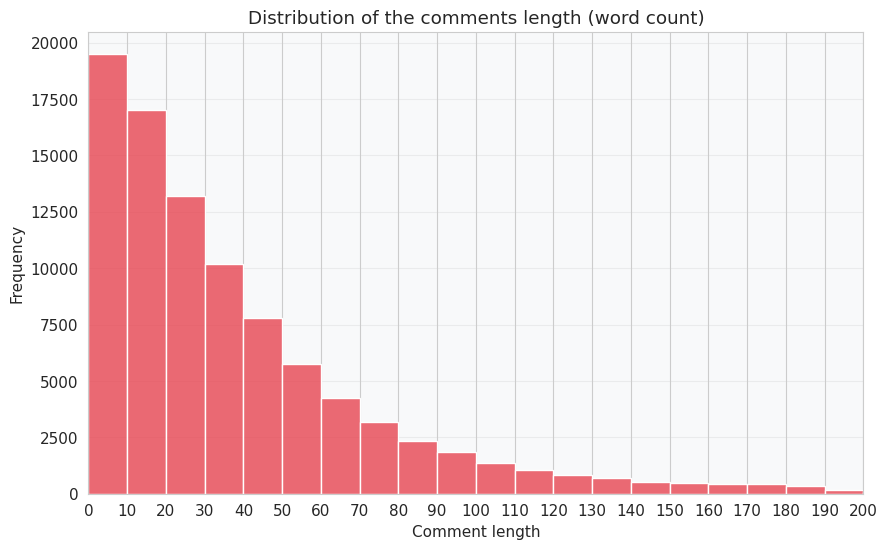

In [ ]:
combined_reviews_sample["comments_len"] = combined_reviews_sample["clean_text"].str.split().apply(len)

mis_bins = range(0, 220, 10)

plt.figure(figsize=(10, 6))

sns.histplot(
    combined_reviews_sample["comments_len"],
    bins=mis_bins,
    kde=False,
    color="#E63946"
)

plt.xticks(mis_bins)
plt.xlim(0, 200)

plt.title("Distribution of the comments length (word count)")
plt.xlabel("Comment length")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)

plt.show()

Our strategy will be to eliminate those reviews that are less than 4 words. This way, we are eliminating those that do not provide much information.

In [ ]:
print(f"Original shape: {combined_reviews_sample.shape}")

Original shape: (91811, 10)


In [ ]:
df_filtered = combined_reviews_sample[combined_reviews_sample["comments_len"] >= 4].copy()
print(f"Shape after filtering short reviews: {df_filtered.shape}")
print(f"Dropped {combined_reviews_sample.shape[0] - df_filtered.shape[0]} rows")

Shape after filtering short reviews: (83956, 10)
Dropped 7855 rows


In [ ]:
#si hace falta borrarlo más tarde:
combined_reviews_sample = combined_reviews_sample.drop(columns=["comments_len"])

### Remove Duplicate Reviews

In [ ]:
df_filtered = df_filtered.drop_duplicates(subset=["clean_text", "listing_id", "date"])

In [ ]:
print(f"Filtered dataframe {df_filtered.shape}")

Filtered dataframe (83956, 10)


### EDA

In [ ]:
combined_reviews_sample.describe()

listing_id            id                           date  \
count  9.181100e+04  9.181100e+04                          91811   
mean   2.536124e+17  7.788911e+17  2022-07-08 17:14:40.090620928   
min    1.867400e+04  1.105350e+05            2010-10-03 00:00:00   
25%    1.140282e+07  6.483884e+08            2020-08-08 12:00:00   
50%    3.068741e+07  9.100452e+17            2023-06-09 00:00:00   
75%    6.083267e+17  1.246329e+18            2024-09-15 00:00:00   
max    1.502823e+18  1.510157e+18            2025-09-14 00:00:00   
std    4.302699e+17  5.355514e+17                            NaN   

        reviewer_id         month          year  
count  9.181100e+04  91811.000000  91811.000000  
mean   2.023496e+08      6.520504   2022.018865  
min    7.060000e+02      1.000000   2010.000000  
25%    4.575575e+07      4.000000   2020.000000  
50%    1.371233e+08      6.000000   2023.000000  
75%    3.365277e+08      9.000000   2024.000000  
max    7.179233e+08     12.000000   2025.000000  
std    1.862371e+08      3.210093      2.815271

In [ ]:
display(combined_listings_review_analysis[
    [
    "review_scores_accuracy",
    "review_scores_rating",
    "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_location",
    "review_scores_value"
    ]
].describe())

review_scores_accuracy  review_scores_rating  \
count            27614.000000          27615.000000   
mean                 4.667926              4.618492   
std                  0.465347              0.492571   
min                  1.000000              1.000000   
25%                  4.590000              4.500000   
50%                  4.790000              4.740000   
75%                  4.920000              4.900000   
max                  5.000000              5.000000   

       review_scores_cleanliness  review_scores_communication  \
count               27613.000000                 27615.000000   
mean                    4.655309                     4.722413   
std                     0.462961                     0.476776   
min                     1.000000                     1.000000   
25%                     4.560000                     4.670000   
50%                     4.770000                     4.860000   
75%                     4.920000                     4.970000   
max                     5.000000                     5.000000   

       review_scores_checkin  review_scores_location  review_scores_value  
count           27613.000000            27615.000000         27615.000000  
mean                4.720038                4.741291             4.498713  
std                 0.451319                0.381267             0.529916  
min                 1.000000                1.000000             1.000000  
25%                 4.670000                4.670000             4.380000  
50%                 4.840000                4.850000             4.620000  
75%                 4.960000                4.960000             4.790000  
max                 5.000000                5.000000             5.000000

## **Step 3: Sentiment Analysis**

This is the key part of the process, to measure the general attitude towards the stayings posted in Airbnb. It uses NLP and Machine Learning to determine the "tone" of a piece of text, classifying it as positive, negative or neutral.

We want to perform this on the reviews text to see what is the general feeling of certain accomodations published in Airbnb. As commented before, we will test this in a subset (the 4% we defined previously).

### Methodology

To transform the unstructured information from reviews into a robus quantitative variable, we use the pre-trained model *nlptown/bert-base-multilingual-uncased-sentiment*. This is a variant of BERT optimized for multilingual opinion analysis, which is key here because we find several languages in the reviews.

Instead of a simple categorical classification, we calculate a continuous Sentiment Score derived from the weighted average of the logarithmic probabilities of the predictions for the 1-5 starts.

This methodology allows to capture nuances in satisfaction, and generate a new high-fidelity numeric variable to enrich the model.

In [ ]:
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)


def get_sentiment_in_batches(texts, batch_size=32):
    model.eval()
    all_scores = []

    weights = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0], device=device)

    for i in tqdm(range(0, len(texts), batch_size), desc="Batch processing"):
        batch_texts = texts[i : i + batch_size]
        clean_batch = [t if isinstance(t, str) and len(t) > 0 else "neutral" for t in batch_texts]

        try:
            inputs = tokenizer(clean_batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)

            batch_scores = (probs * weights).sum(dim=1)
            all_scores.extend(batch_scores.cpu().numpy())

        except RuntimeError as e:
            print(f"Error in batch {i}: {e}")
            all_scores.extend([0.0] * len(batch_texts))

    return all_scores
print("Preapring data...")
text_data = df_filtered['clean_text'].fillna("").tolist()

print(f"Processing {len(text_data)} reviews...")

sentiment_scores = get_sentiment_in_batches(text_data, batch_size=32)

df_filtered['sentiment_score'] = sentiment_scores

print("Process completed")
display(df_filtered[['clean_text', 'sentiment_score']].sample(5))

Using: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Preapring data...
Processing 83956 reviews...


Batch processing: 100%|██████████| 2624/2624 [15:52<00:00,  2.75it/s]

Process completed


clean_text  sentiment_score
2019141  heel dicht bij het centrum alles op loop afsta...         0.801079
1005368  a cozy place in a great location with a lovely...         0.730932
41236    evelin gisele s apartment is located in a wond...         0.641098
1694869  this is a dream apartment to stay in central l...         0.774373
1179546  nos encanto el piso decorado con mucho estilo ...         0.871285

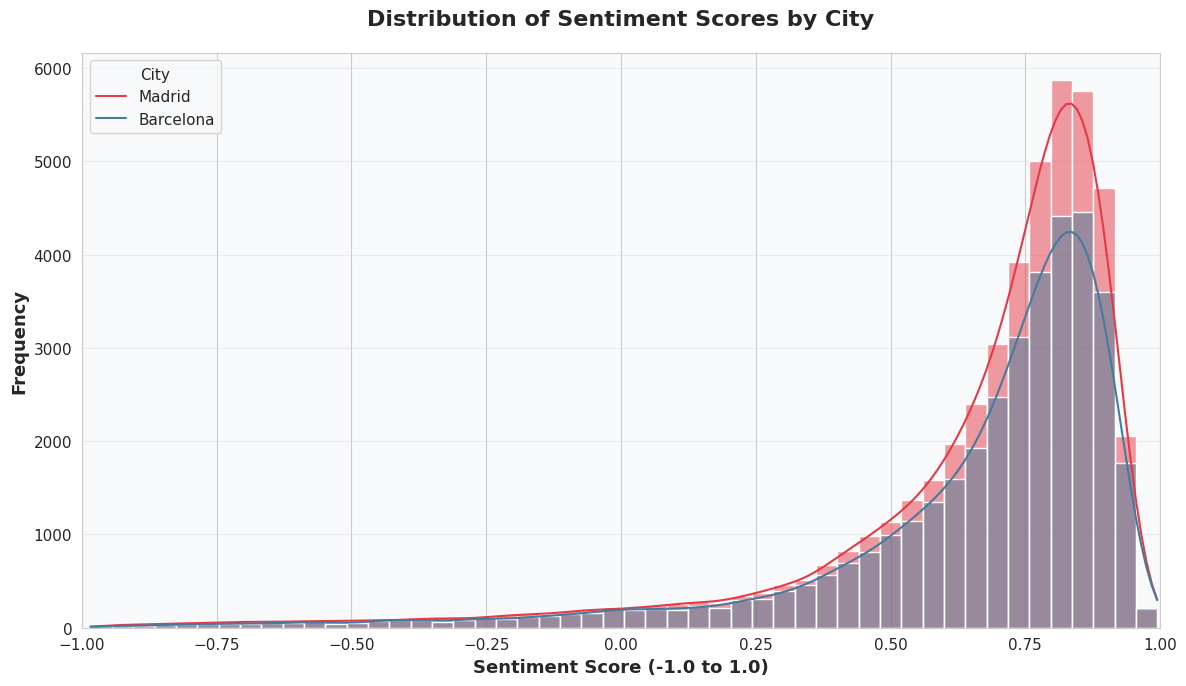

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(df_filtered, x='sentiment_score', hue='City', bins=50, kde=True, palette={'Madrid': COLORS['madrid'], 'Barcelona': COLORS['barcelona']})
plt.title('Distribution of Sentiment Scores by City', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentiment Score (-1.0 to 1.0)', fontsize=13, fontweight='bold')
plt.ylabel('Frequency', fontsize=13, fontweight='bold')
plt.xlim(-1.0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='City', labels=['Madrid', 'Barcelona'])
plt.tight_layout()
plt.show()

### Metrics & Insights

From the graph above, we can extract conclusions.

1. **Technical Validation.** The model is working correctly: there is a more or less soft distribution curve that follows perfectly the bars; meaning the BERT model works correctly. Even if the distribution is left-skewed and concrentrates on the right side, the model still detects nuances in the (-1, 0) range.

2. **Business interpretation:** after seeing the highly-positive classification of the reviews, I though that maybe we had an error in our code with the preparation of data. *I asked Gemini for possible explanations, and among all it gave a very convincing one which I later researched about: **The Airbnb Bias**.

  I looked for studies on this effect, and it turns out that it is something real: [Article 1](https://theescapehome.com/some-airbnb-users-feel-like-its-rating-system-is-wildly-inaccurate-heres-why/), because there is a closer relationship with the host, then the guest is usually less likely to give a negative recommendation thinking it may harm the host´s economical capabilities *(in the link you see a case where guest was afraid of harming the hosts who had just had a baby)*.

  In this sense, I also found this academic study: *If nearly all Airbnb reviews are positive, does that make them meaningless?* (J. Bridges, C. Vásquez. 2016) which hypothesizes the confirmation of the Airbnb Bias, finding that 93% of the posted reviews on Airbnb are positive, and the mean accomodation score stays at 4.7/5. The authors state this is due to the *interpersonal nature of the collaborative economy* and the fact this is creating a social pressure to be "nice" and avoid explicit critiques. They conclude that negative experiences rarely manifest themselves at low punctuations, but that they can be seen in lukewarm reviews: short, neutral or lacking enthusiams.

3. **Madrid vs Barcelona:** visually, there is a slight difference (Madrid is the yellow line and Barcelona is the pink line). The peak of maximum satisfaction stands at around 0.85 and is for Madrid. For Barcelona, we see a slightly flatter and wider curve. The interpretation here is that there seems to be a slightly higher satisfaction/more consistent in Madrid. In Barcelona, even though it is also very positive, it tends to have a higher dispersion.

## **Step 4: Keyword & Topic Analysis**

While the previous BERT analysis quantified the magnitude of guest satisfaction, it does not explain the reasons behind it. To extract interpretable insights we make an N-gram analysis, specifically examining unigrams (single concepts) and bigrams (contextual pairs).

This approach converts raw text into frequency-based features to identify dominant themes. Given the international nature of Airbnb demand in Madrid and Barcelona, we implement a multilingual noise reduction strategy, filtering out stopwords across six languages: Spanish, English, French, Portuguese, Italian and German. This allows us to isolate high-value semantic tokens *(e.g., "central location", "very clean")* from noise. This will allow us to reveal the characteristics of a listing that explain a positive/negative review.

### Keyword Analysis

*AI NOTE: the following code was developed using GenAI. Prompt: "perform a Keyword Analysis on the dataset, considering stopwords, noise, and plot them depending on the city."*

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Stopwords cargadas: 1280 palabras.

 Analyzing Madrid...


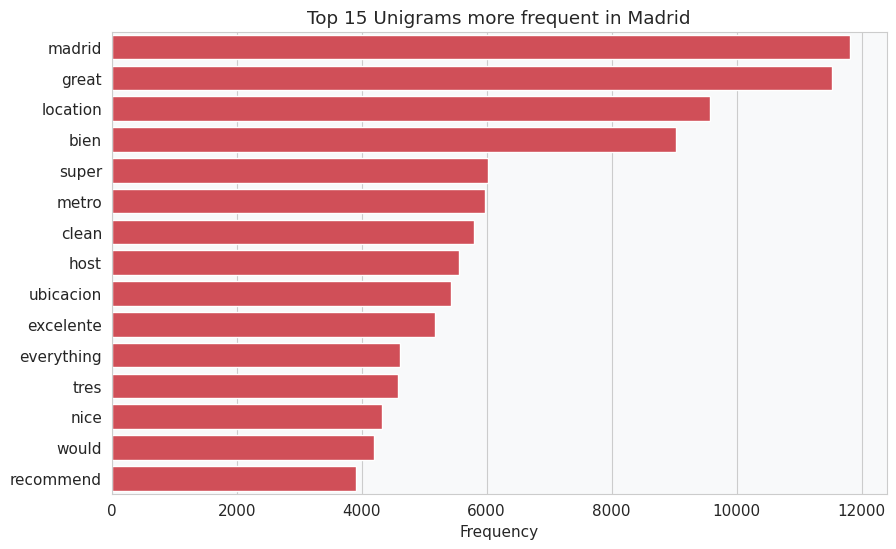

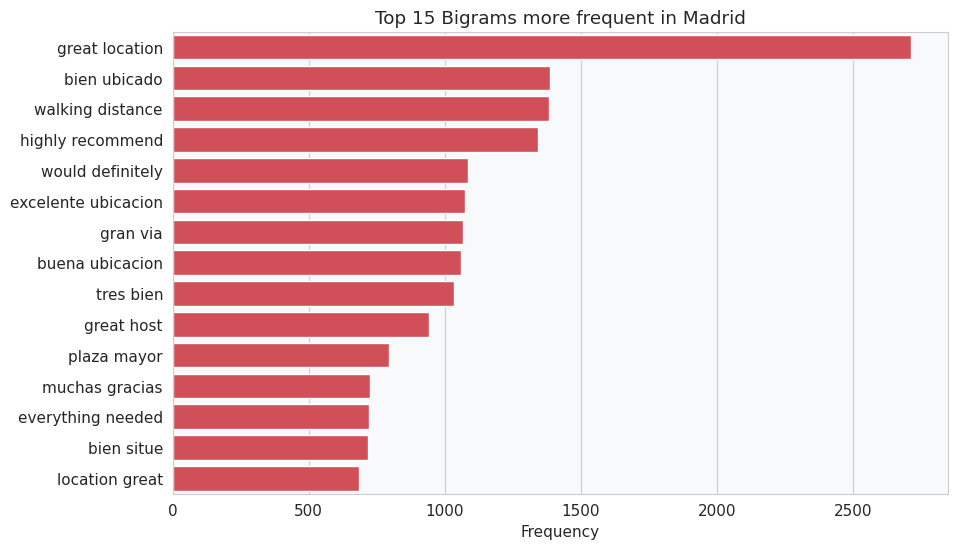

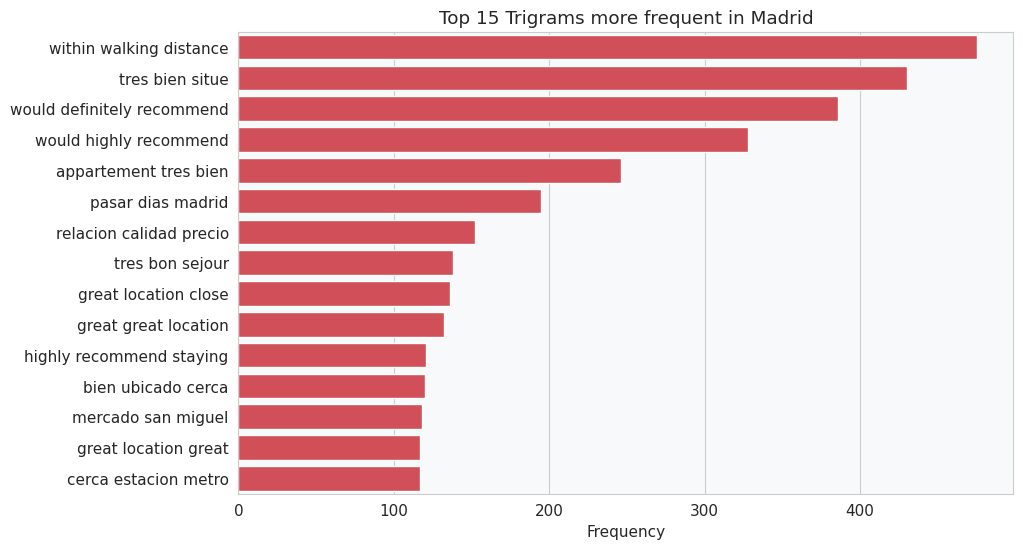


 Analyzing Barcelona...


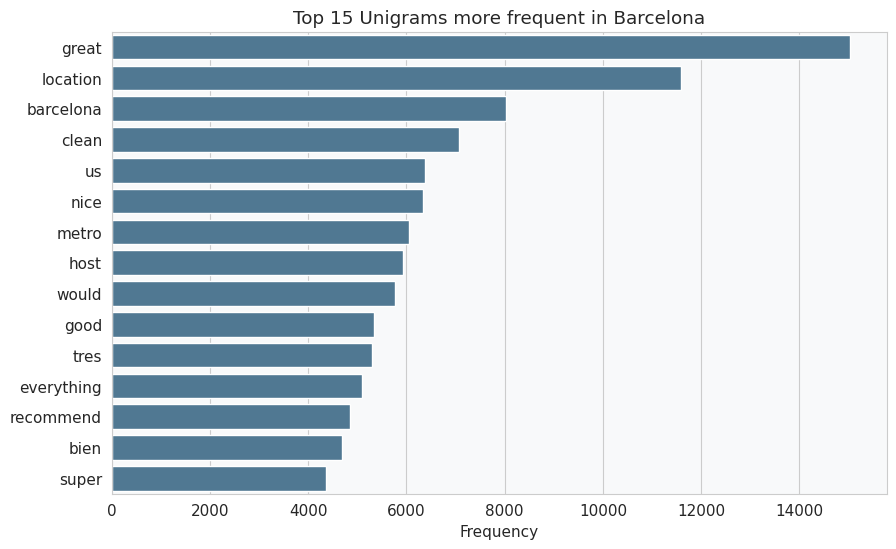

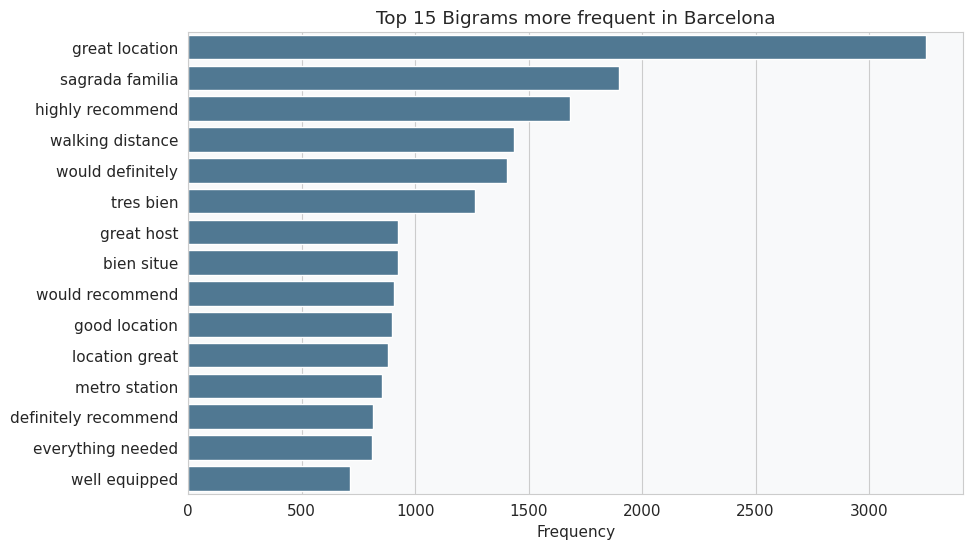

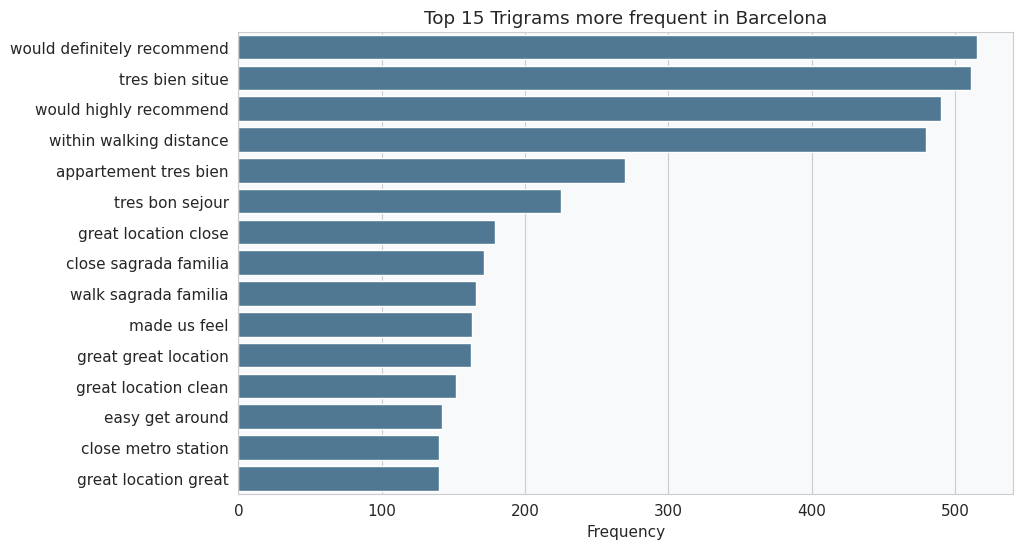

In [ ]:
nltk.download('stopwords')

def get_multilingual_stopwords():
    stop_words = set()
    languages = ['spanish', 'english', 'french', 'german', 'italian', 'portuguese']

    for lang in languages:
        stop_words.update(stopwords.words(lang))

    custom_noise = {'br', 'nan', 'apartamento', 'piso', 'room', 'apartment', 'stay', 'place'}
    stop_words.update(custom_noise)

    return list(stop_words)

final_stopwords = get_multilingual_stopwords()
print(f"Stopwords cargadas: {len(final_stopwords)} palabras.")

def plot_top_ngrams(texts, city_name, n=2, top_k=15, min_df_val=10):
    """
    Calculates and displays the most frequent N-grams.
    n=1 (Unigrams), n=2 (Bigrams), n=3 (Trigrams)
    """
    vectorizer = CountVectorizer(
        stop_words=final_stopwords,
        ngram_range=(n, n),
        min_df=min_df_val,
        max_features=10000
    )

    try:
        bag_of_words = vectorizer.fit_transform(texts.dropna())

        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

        common_words = words_freq[:top_k]
        words, freqs = zip(*common_words)

        plt.figure(figsize=(10, 6))
        color = '#E63946' if city_name == 'Madrid' else '#457B9D'

        sns.barplot(x=list(freqs), y=list(words), color=color)
        ngram_type = 'Unigrams' if n == 1 else ('Bigrams' if n == 2 else 'Trigrams')
        plt.title(f"Top {top_k} {ngram_type} more frequent in {city_name}")
        plt.xlabel("Frequency")
        plt.show()

    except ValueError:
        print(f"Not enough data to generate N-grams in {city_name}")

target_col = "clean_text" if "clean_text" in combined_reviews_sample.columns else "comments_clean"

for city in ["Madrid", "Barcelona"]:
    print(f"\n Analyzing {city}...")
    subset = combined_reviews_sample[combined_reviews_sample["City"] == city][target_col]

    plot_top_ngrams(subset, city, n=1)

    plot_top_ngrams(subset, city, n=2)

    plot_top_ngrams(subset, city, n=3)

####Interpretation & Business Insight

1. **Location is the King (in both cities)**
In both Madrid and Barcelona, "location" is the #2 or #3 most frequent unigram, and "great location" is the overwhelming #1 bigram.

- Madrid: Specific landmarks like "Gran Via" and "Plaza Mayor" appear frequently in the top bigrams. This suggests that for Madrid tourists, being central and close to these specific hubs is a primary delight factor. Terms like "metro" and "cerca estacion metro" (near metro station) in trigrams reinforce that connectivity is vital.

- Barcelona: The dominance of "Sagrada Familia" in bigrams and trigrams ("close sagrada familia", "walk sagrada familia") is striking. It’s not just about being central; it’s specifically about proximity to this iconic monument. "Metro station" also appears, but the landmark focus is sharper here.

**Business Insight:** Investors should prioritize properties within walking distance of these specific landmarks (Gran Via/Sol in Madrid, Sagrada Familia in BCN). "Walking distance" is a recurring high-frequency phrase; guests pay a premium to avoid long commutes.

2. **The "Hygiene Factors": Cleanliness & Comfort**
"Clean" is a top-5 unigram in both cities. Phrases like "everything needed" and "well equipped" (especially in Barcelona) appear frequently.

Cleanliness is a non-negotiable. It's mentioned so often because it's the first thing guests check. If a listing isn't spotless, it fails. The presence of "well equipped" suggests that guests in Barcelona (perhaps staying longer or more family-oriented) value functional amenities (kitchen, washing machine) more explicitly.

**Business Insight:** we should focus in keeping the accomodations clean and fully equipped.

3. **The Human Element: The "Superhost" Effect**
"Great host" is a top-10 bigram in both cities.

Despite the rise of professional property management, guests still highly value the personal connection. They aren't just renting a space; they are rating the interaction. A "great host" is often one who communicates well and solves problems quickly.

**Business Insight:** Automation is good for efficiency, but perceived personal hospitality (warm welcome messages, local tips) drives reviews.

4. **Recommendation as the Ultimate Metric**
Evidence: "Recommend", "highly recommend", "would definitely recommend" are ubiquitous across all n-grams.

This confirms the Net Promoter Score (NPS) logic. The ultimate expression of satisfaction in Airbnb reviews isn't just saying "it was good," but explicitly stating willingness to recommend it to others.

**Business Insight:** Positive reviews are a self-reinforcing loop. The frequency of these phrases suggests that social proof is the strongest currency on the platform.

5. **Language & Demographics**
Evidence: There is a significant presence of French phrases ("tres bien", "bien situe", "tres bon sejour") in the top n-grams for both cities, but especially in Barcelona.

This signals a strong French tourist demographic, likely due to proximity (for BCN) and popularity.

**Business Insight:** Hosts should consider translating guidebooks into French or having French-speaking support staff to cater to this large segment.

### Topic Modelling with LDA

To move beyond explicit keyword frequency, we apply Latent Dirichlet Allocation (LDA).

This unsupervised probabilistic model assumes that each review is a mixture of underlying topics, and each topic is a distribution of words. By analyzing the co-occurrence patterns of terms across the corpus, the algorithm clusters semantically related terms into coherent themes.

We apply strict frequency filters (min_df=0.01, max_df=0.90) to exclude unclear/unspecific terms that lack information and rare outliers, ensuring the resulting topics represent the guest experience.

Configuring LDA
Training LDA over 83956 reviews...
Generating topic visualization...


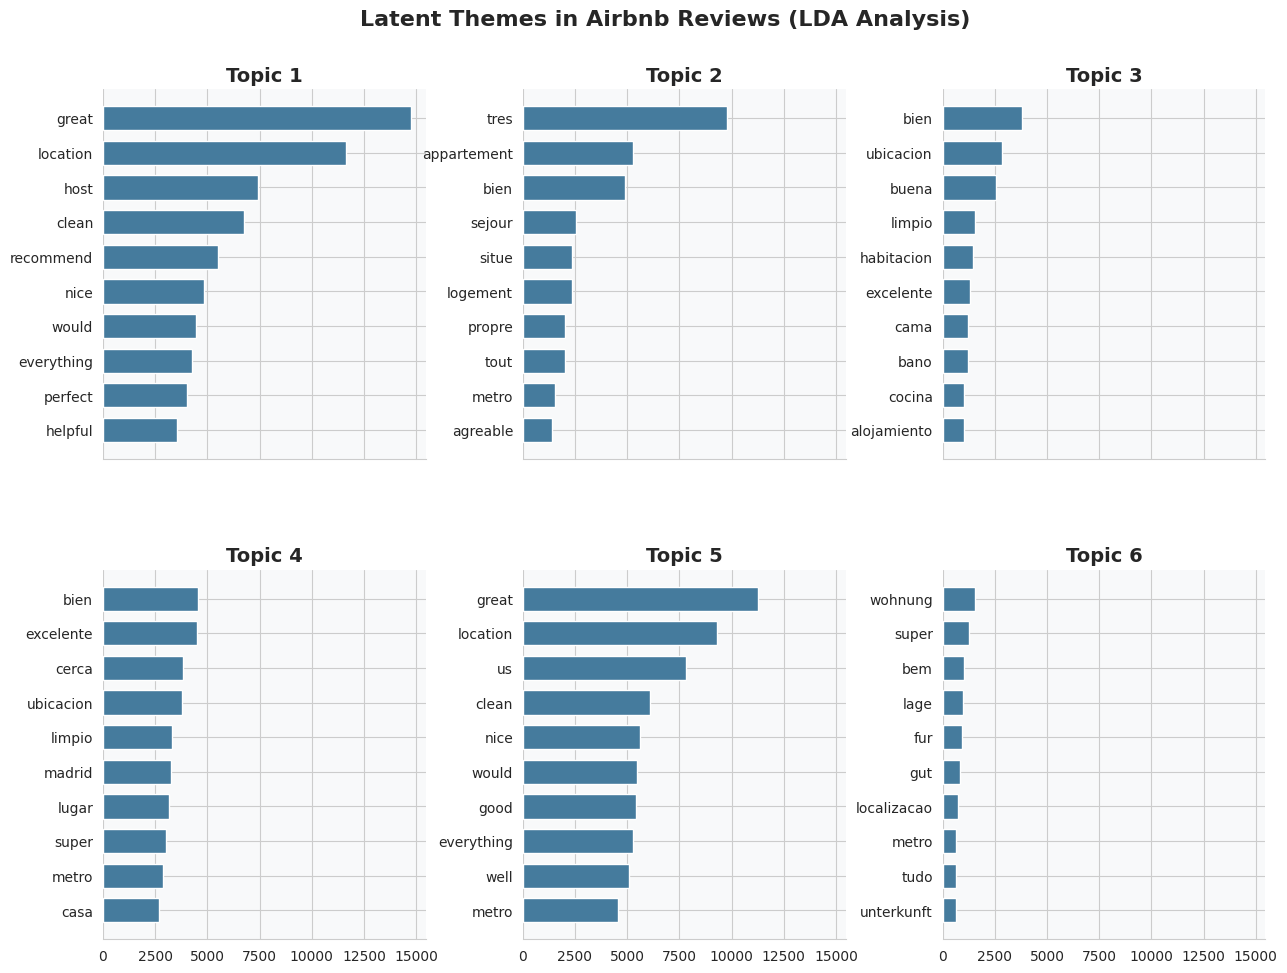

In [ ]:
def plot_lda_topics(model, vectorizer, n_top_words=10):
    """
    Visualizes LDA topics as horizontal bar charts.
    """
    feature_names = vectorizer.get_feature_names_out()

    n_topics = model.components_.shape[0]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        if topic_idx >= len(axes): break

        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='#457B9D')
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    fig.suptitle('Latent Themes in Airbnb Reviews (LDA Analysis)', fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.3, hspace=0.3)
    plt.show()

print("Configuring LDA")

# Intelligent Vectorization. Ignores words that appear 90% of cases.
lda_vectorizer = CountVectorizer(
    max_df=0.90,
    min_df=0.0,
    stop_words=final_stopwords,
    max_features=5000
)

corpus = df_filtered['clean_text'].dropna()
doc_term_matrix = lda_vectorizer.fit_transform(corpus)

lda_model = LatentDirichletAllocation(
    n_components=6,
    random_state=100498308,
    n_jobs=-1
)

print(f"Training LDA over {doc_term_matrix.shape[0]} reviews...")
lda_model.fit(doc_term_matrix)

print("Generating topic visualization...")
plot_lda_topics(lda_model, lda_vectorizer)

#### Interpretation & Business Insights



*AI NOTE: the following conclusion from the LDA was extracted using GenAI. Prompt: Make an interpretation in English of this LDA, based on the graphic I am providing with and considering the context of the review analysis**.

Our LDA reveals that guest satisfaction is not uniform. It is segmented by language differences. While English speakers fragment into three distinct profiles based on their travel style, European neighbors (Spanish, French) form distinct clusters with specific priorities.

**Topic 1: The "Standard International" (English)**
This is the baseline international tourist. They are looking for the three things: Location, Hygiene, and Safety. Their reviews are balanced and holistic. This is our mass market. To satisfy them, we don't need to be unique; we need to be reliable. No red flags, good location, clean sheets.

**Topic 2: The "Francophone Product-Critic" (French)**
The French market is consistently focused on the physical product. They analyze the "Appartement" (the asset) more than the "Host" (the person). They value aesthetics, functionality. Marketing to this group requires high-quality photos and detailed lists of amenities. They are the most likely to complain if the reality doesn't match the listing photos.

**Topic 3: The "Spanish Pragmatist" (Spanish A)**
This Spanish cluster is purely logistical. They talk about the "Piso" (the flat) and "Ubicación" (Location). They are judging the asset's convenience—is it close to the metro? Is it in a good zone? Is it good value for money? This group is price-sensitive and practical. We must sell them on connectivity and value. "Steps from Metro" is their trigger phrase.

**Topic 4: The "Spanish Socialite" (Spanish B)**
This is the emotional side of the Spanish market. The algorithm separated this from Topic 3 because the vocabulary is completely different. Here, the asset doesn't matter; the Host does. They value warmth, personal attention ("trato"), and feeling at home. To capture this segment, automation fails. We need a human touch—a warm welcome message, a personal recommendation, or a small welcome gift.

**Topic 5: The "English Logistics & Details" (English)**
Unlike the general enthusiasts in Topic 1, these English speakers are focused on the process. They judge the efficiency of the arrival, the ease of access (keypad vs. keys), and communication speed. They are likely business travelers or short-stay tourists.

Business Insight: This group fears friction. Your selling point here is "Self Check-in" and "Instant Book".

Topic 6: The "Universal Traveler" (Mixed Language)
Likely Keywords: Metro, Super, Perfect, 10/10, Center, Taxi, WiFi, Top.

Profile: This interesting cluster contains "loanwords" or universal terms used across all languages. It represents short, punchy reviews from global travelers who use simplified "International English/Spanglish".

Business Insight: These reviews are usually impulsive and highly positive. They signal a property that is "universally understood" to be good (likely very central).

## **Step 5: Rating Drivers**

To perform the analysis for rating drivers, we will merge the sentiment columns (df_filtered) with the listings_first_clean. We do this so that we have a single dataframe ready for correlation analysis to find the ratings drivers.

In [ ]:
# First, we group by and calculate the average sentiment score.
listing_sentiment = df_filtered.groupby('listing_id')['sentiment_score'].agg(['mean', 'count']).reset_index()
listing_sentiment.columns = ['id', 'avg_sentiment', 'review_count_sample']

# Ensure 'id' column in listing_sentiment is of type float to match listings_first_clean
listing_sentiment['id'] = listing_sentiment['id'].astype(float)

print(f"Sentiment calculated for {len(listing_sentiment)} accomodations.")

# Secondly, we merge this sentiment with the main listing dataset.
combined_listings_with_sentiment = pd.merge(
    combined_listings_review_analysis,
    listing_sentiment,
    on='id',
    how='left'
)

Sentiment calculated for 18307 accomodations.


### **Correlations**

1) Price vs Sentiment
2) Rating vs Sentiment

In [ ]:
corr_price = combined_listings_with_sentiment['price'].corr(combined_listings_with_sentiment['avg_sentiment'])
corr_rating = combined_listings_with_sentiment['review_scores_rating'].corr(combined_listings_with_sentiment['avg_sentiment'])

print(f"Correlation Price vs Sentiment: {corr_price:.3f}")
print(f"Correlation Rating  vs Sentiment: {corr_rating:.3f}")

Correlation Price vs Sentiment: -0.003
Correlation Rating  vs Sentiment: 0.456


Firstly, we see that Price tends to negatively affect Sentiment (the higher the price, the lower the sentiment) but this is a very weak, almost diminishable relation.

On the contrary, as one would expect, the higher the rating, the higher the sentiment. This is obviously normal, as the Sentiment we calculated is based on the ratings.

3) Price vs Sentiment grouped per Room Type & City

In [ ]:
correlation_by_room = combined_listings_with_sentiment.groupby('room_type').apply(
    lambda x: x['price'].corr(x['avg_sentiment']))

print("Price-Sentiment by Room Type")
display(correlation_by_room.sort_values(ascending=False))

Price-Sentiment by Room Type


/tmp/ipython-input-68907894.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_room = combined_listings_with_sentiment.groupby('room_type').apply(


room_type
Hotel room         0.028495
Entire home/apt    0.001671
Private room      -0.040105
Shared room       -0.228714
dtype: float64

If we focus on the Price vs Sentiment relation, but depending on the Room Type; we get that the most drivers of satisfaction are the Hotel Rooms.

This would be surprisingly contrary to the belief we had about the Airbnb Bias we commented previously, but still it is very interesting to know because we have a sense of the type of rooms people tend to prefer.

In [ ]:
def corr_debug(df):
    return pd.DataFrame({
        'n_rows': df.groupby('City').size(),
        'n_price_nonnull': df.groupby('City')['price'].apply(lambda s: s.notna().sum()),
        'n_sent_nonnull': df.groupby('City')['avg_sentiment'].apply(lambda s: s.notna().sum()),
        'price_std': df.groupby('City')['price'].std(),
        'sentiment_std': df.groupby('City')['avg_sentiment'].std()
    })

debug_stats = corr_debug(combined_listings_with_sentiment)
print(debug_stats)

correlation_by_city = combined_listings_with_sentiment.groupby('City').apply(
    lambda x: x['price'].corr(x['avg_sentiment'])
)
print("\nPrice-Sentiment by City")
print(correlation_by_city)

           n_rows  n_price_nonnull  n_sent_nonnull   price_std  sentiment_std
City                                                                         
Barcelona   11790            11790            6542  320.687058       0.254896
Madrid      15825            15825            9242  455.360092       0.252462

Price-Sentiment by City
City
Barcelona    0.005011
Madrid      -0.003696
dtype: float64


/tmp/ipython-input-2353345834.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_city = combined_listings_with_sentiment.groupby('City').apply(


Finally, if we specify the price-sentiment relation divided by city, we have the following:
- For Barcelona, the price-sentiment relation is extremely weak positive, so we deem this as diminishable, we do not consider this of relevance.
- For Madrid, the the price-sentiment relation is extremely weak negative. We also consider this of no relevance.

Now, let´s take it up a notch. Let´s see the correlation between avg_sentiment and the rest of numerical features.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify all numerical columns in the DataFrame
numerical_columns = combined_listings_with_sentiment.select_dtypes(include=np.number).columns.tolist()

# Ensure 'avg_sentiment' is in the list, and remove 'id' if not desired for correlation analysis
# (listing_id, scrape_id, host_id are usually identifiers, not features for correlation with sentiment)
columns_to_exclude_from_corr = ['id', 'scrape_id', 'host_id', 'listing_id'] # Add other ID-like columns if they exist and are numerical
numerical_features_for_corr = [col for col in numerical_columns if col not in columns_to_exclude_from_corr and col != 'review_count_sample']

# Add 'avg_sentiment' if it's not already there after exclusions
if 'avg_sentiment' not in numerical_features_for_corr:
    numerical_features_for_corr.append('avg_sentiment')

# Filter the DataFrame to only include these numerical features and drop rows with NaNs for correlation calculation
df_corr = combined_listings_with_sentiment[numerical_features_for_corr].dropna()

# Calculate the correlation matrix
corr_matrix = df_corr.corr()

print("Correlation Matrix of Numerical Features with Average Sentiment:")
# Display only the correlations with 'avg_sentiment', sorted
display(corr_matrix[['avg_sentiment']].sort_values(by='avg_sentiment', ascending=False))

Correlation Matrix of Numerical Features with Average Sentiment:


avg_sentiment
avg_sentiment                                      1.000000
review_scores_rating                               0.455485
review_scores_value                                0.428469
review_scores_accuracy                             0.418713
review_scores_communication                        0.386957
review_scores_checkin                              0.369467
review_scores_cleanliness                          0.367658
review_scores_location                             0.275962
estimated_occupancy_l365d                          0.113054
number_of_reviews                                  0.099563
number_of_reviews_ly                               0.078059
number_of_reviews_ltm                              0.065837
estimated_revenue_l365d                            0.053671
reviews_per_month                                  0.044373
number_of_reviews_l30d                             0.035410
minimum_maximum_nights                             0.030389
minimum_nights                                     0.019972
minimum_minimum_nights                             0.014810
year                                               0.010725
minimum_nights_avg_ntm                             0.006551
maximum_nights_avg_ntm                             0.004592
maximum_maximum_nights                             0.004592
bedrooms                                           0.001985
price                                             -0.002703
maximum_minimum_nights                            -0.004408
month                                             -0.008999
accommodates                                      -0.012525
calculated_host_listings_count_shared_rooms       -0.013267
latitude                                          -0.025802
longitude                                         -0.025896
maximum_nights                                    -0.032092
calculated_host_listings_count_private_rooms      -0.059067
availability_eoy                                  -0.064999
calculated_host_listings_count_entire_homes       -0.091916
calculated_host_listings_count                    -0.099549

From this result, we know what *numerical* variables to put into the regression model. Please note that for the review_based variables we will not insert them even if they have high correlations because they are literally based on the ratings, so it would create multicolinearity.

### **Regression Model**

Now, using a Regression Model, we try to predict what are the most important rating drivers.

We use the model *combined_listings_with_sentiment*.
We then define the features to be used and we "forget" the ones who are not relevant for the model. We also define a pipeline to automatically scale numeric variables and codify categorical ones.

We use Ridge instead of the simple Regression because it is more robust.

Training samples: 12233
Testing samples: 3059

Entrenando modelo de Drivers...
Resultados en Test Set:
R2 Score: 0.0646
MAE: 0.1640

--- TOP SATISFACTION DRIVERS ---


Driver  Impact (Coefficient)  \
5                                 host_is_superhost_t              0.106741   
36             neighbourhood_group_cleansed_Vicálvaro              0.102473   
27                neighbourhood_group_cleansed_Retiro              0.046468   
8                               room_type_Shared room             -0.042806   
28             neighbourhood_group_cleansed_Salamanca              0.040645   
29  neighbourhood_group_cleansed_San Blas - Canill...              0.034296   
12             neighbourhood_group_cleansed_Chamartín              0.030344   
19        neighbourhood_group_cleansed_Horta-Guinardó             -0.029789   
9                neighbourhood_group_cleansed_Barajas              0.029115   
11                neighbourhood_group_cleansed_Centro              0.024204   
35                 neighbourhood_group_cleansed_Usera             -0.023036   
10           neighbourhood_group_cleansed_Carabanchel              0.022861   
13              neighbourhood_group_cleansed_Chamberí              0.021988   
22             neighbourhood_group_cleansed_Les Corts             -0.020118   
30           neighbourhood_group_cleansed_Sant Andreu             -0.019831   
20             neighbourhood_group_cleansed_Hortaleza              0.016436   
26    neighbourhood_group_cleansed_Puente de Vallecas             -0.015483   
18                neighbourhood_group_cleansed_Gràcia             -0.015368   
38            neighbourhood_group_cleansed_Villaverde              0.013077   
4                                   number_of_reviews              0.012023   
24             neighbourhood_group_cleansed_Moratalaz              0.011850   
17  neighbourhood_group_cleansed_Fuencarral - El P...             -0.011346   
37     neighbourhood_group_cleansed_Villa de Vallecas              0.010995   
34                neighbourhood_group_cleansed_Tetuán              0.010090   
33   neighbourhood_group_cleansed_Sarrià-Sant Gervasi             -0.010086   
16              neighbourhood_group_cleansed_Eixample              0.010034   
2                                            bedrooms              0.008429   
3                           estimated_occupancy_l365d              0.007195   
6                                room_type_Hotel room              0.007052   
1                                        accommodates             -0.006519   
15          neighbourhood_group_cleansed_Ciutat Vella              0.005893   
23     neighbourhood_group_cleansed_Moncloa - Aravaca             -0.005790   
7                              room_type_Private room              0.005199   
32        neighbourhood_group_cleansed_Sants-Montjuïc             -0.004470   
25            neighbourhood_group_cleansed_Nou Barris             -0.004419   
14         neighbourhood_group_cleansed_Ciudad Lineal              0.004067   
31            neighbourhood_group_cleansed_Sant Martí             -0.002263   
0                                               price             -0.001921   
21                neighbourhood_group_cleansed_Latina             -0.001771   

    Abs Impact  
5     0.106741  
36    0.102473  
27    0.046468  
8     0.042806  
28    0.040645  
29    0.034296  
12    0.030344  
19    0.029789  
9     0.029115  
11    0.024204  
35    0.023036  
10    0.022861  
13    0.021988  
22    0.020118  
30    0.019831  
20    0.016436  
26    0.015483  
18    0.015368  
38    0.013077  
4     0.012023  
24    0.011850  
17    0.011346  
37    0.010995  
34    0.010090  
33    0.010086  
16    0.010034  
2     0.008429  
3     0.007195  
6     0.007052  
1     0.006519  
15    0.005893  
23    0.005790  
7     0.005199  
32    0.004470  
25    0.004419  
14    0.004067  
31    0.002263  
0     0.001921  
21    0.001771

/tmp/ipython-input-3076656772.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=drivers_df, x='Impact (Coefficient)', y='Driver', palette='coolwarm')


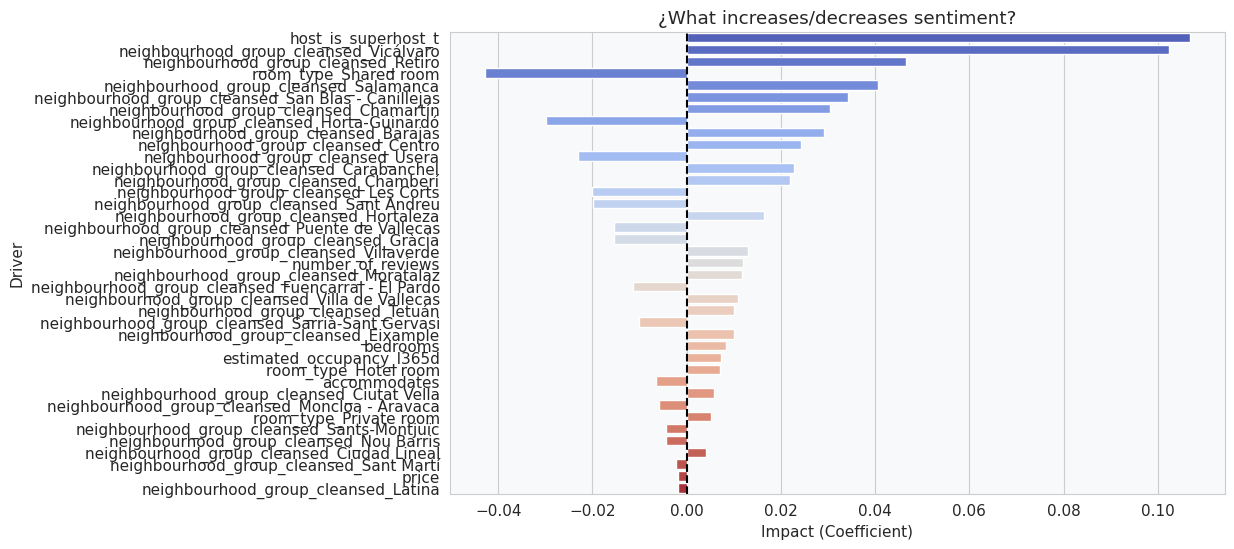

In [ ]:
df_model = combined_listings_with_sentiment.copy()

features = [
    "price",
    "host_is_superhost",
    "accommodates",
    "bedrooms",
    "room_type",
    "neighbourhood_group_cleansed",
    "estimated_occupancy_l365d",
    "number_of_reviews",
    ]
target = 'avg_sentiment'

df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


numeric_features = ['price', 'accommodates', 'bedrooms', "estimated_occupancy_l365d", "number_of_reviews"]
categorical_features = ['host_is_superhost', 'room_type', "neighbourhood_group_cleansed"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features) # drop='first' evita multicolinealidad en regresión lineal
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

print("\nEntrenando modelo de Drivers...")
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print("Resultados en Test Set:")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")


feature_names = numeric_features.copy()
cat_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names.extend(cat_names)

coefs = model_pipeline.named_steps['regressor'].coef_

drivers_df = pd.DataFrame({
    'Driver': feature_names,
    'Impact (Coefficient)': coefs,
    'Abs Impact': np.abs(coefs)
}).sort_values(by='Abs Impact', ascending=False)

print("\n--- TOP SATISFACTION DRIVERS ---")
display(drivers_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=drivers_df, x='Impact (Coefficient)', y='Driver', palette='coolwarm')
plt.title("¿What increases/decreases sentiment?")
plt.axvline(0, color='black', linestyle='--')
plt.show()

## **Step 6: Conclusions**

1. We must focus on those accomodations where the host is superhost. It is the highest driver of rating.

2. Geographical position is one of the most drivers of satisfaction. We must focus on Madrid, as it is the best satisfaction driver of the two cities, by a large amount. Inside Madrid, we recommend to focus on *(this depends on the boards number of areas they want to cover)* the following neighbourhoods:
- Vicálvaro
- Retiro
- Salamanca
- Canillejas
- Chamartín

3. The total number of reviews an accomodation has **does not directly mean that the accomodation will have a higher rating**

4. The *number of bedrooms*, *estimated occupancy-l365d*, *price* are not very high drivers of satisfaction. They have a low relationship. It is not recommended to forget them, but the geographical position seems to be more relevant.

5. Regarding negative drivers, we must **not offer shared rooms**, the neighborhoods Guimardó, Usera, Les Corts, San Andreu do terribly in reviews.

### **Executive Summary**

Our analysis of Airbnb reviews reveals a marketplace dominated by high satisfaction scores, driven largely by the "Airbnb Bias." As identified in academic literature, the interpersonal nature of the sharing economy creates social pressure, leading guests to avoid explicit negative ratings Consequently, 93% of reviews are positive, meaning investors cannot rely solely on star ratings to gauge performance.

Despite this universal bias, distinct patterns emerged between the two markets. Madrid demonstrates a higher and more consistent level of guest satisfaction compared to Barcelona. Furthermore, regression analysis identifies Geographical Position and Superhost Status as the strongest predictors of a high rating, far outweighing physical attributes like the number of bedrooms or price.

These location- and management-driven effects are consistent with our pricing and revenue analyses: Superhosts consistently outperform, and Madrid shows higher occupancy stability, reinforcing the strategic recommendation.

### **Recommendations for Investors**

Based on the Sentiment, Keyword, Topic, and Regression analyses, we propose the following strategic roadmap for investment and management:

1. **Location Strategy:**
- Primary City Focus: prioritize capital allocation in Madrid. The regression analysis confirms that being located in Madrid is a significantly stronger driver of satisfaction than being in Barcelona.
- Target Neighborhoods (Madrid): Within the capital, focus acquisition efforts on Retiro, Salamanca, Chamartín, Vicálvaro, and Canillejas. These areas are statistically correlated with higher guest ratings.
- The "Walking Distance" Premium: In both cities, the ability to walk to major hubs is a primary delight factor.
  - Madrid: Assets must be near Gran Vía, Sol, or Plaza Mayor
  - Barcelona: Proximity to La Sagrada Familia is the dominant location driver
  - Connectivity: If the asset is not city-center, proximity to a Metro station is mandatory for positive sentiment.

2. **Operational Strategy:**
- The "Superhost" Imperative: Achieving Superhost status is not a vanity metric; it is the single highest driver of ratings in our regression model. Investors must budget for professional, high-touch management that prioritizes responsiveness and problem-solving.
- Hygiene as a Deal-Breaker: "Clean" is a top-frequency keyword. Cleanliness is a non-negotiable hygiene factor; if a listing is not spotless, the rating collapses.
- Asset Type & Amenities:
  - Hotel Room / Serviced Apartments: Contrary to the assumption that guests only want "homey" vibes, Hotel Rooms were identified as top satisfaction drivers. This suggests a high demand for professionalized standards (easy check-in, predictability) within the platform.
  - Equipment: especially for Barcelona (likely due to family/longer stays), ensure apartments are "well equipped" (washing machines, full kitchens) to secure positive reviews.

3. **Marketing & Demographic Targeting**
- Leverage the "Linguistic niches": Our Topic Analysis identified distinct guest personas. Listings should be tailored to capture these markets:
  - The French Market: A massive demographic (especially in BCN). Translate guidebooks and listing descriptions into French. Emphasize "pleasant stay" (sejour agreable) and practicality.
  - The Italian Market: Emphasize the strategic position (ottima posizione) of the asset in marketing materials.
  - The "Lifestyle" Traveler (English speakers): Sell the neighborhood, not just the unit. Highlight nearby restaurants, walkability, and the local vibe.
- Encourage Recommendations: Since "willingness to recommend" is the ultimate currency of satisfaction, post-stay communication should gently encourage guests to mention if they would recommend the place to others, fueling social proof.

4. **Investment Misconceptions (What NOT to prioritize)**
- Price Sensitivity is Low: We found a negligible relationship between Price and Sentiment. High prices do not automatically lead to harsher reviews. Investors should not fear premium pricing if the location and hygiene factors are met.
- Volume does not equal Quality: Do not simply buy assets based on the total number of reviews. A high volume of reviews does not correlate with higher satisfaction. Focus on quality consistency over booking quantity.
- Physical Specs are Secondary: The number of bedrooms and occupancy capacity have a low relationship with satisfaction. A small, well-located studio in Salamanca managed by a Superhost will outperform a large, ill-positioned apartment in ratings.

### **Final Verdict**

For maximum ROI based on guest satisfaction, the data points to Madrid as the superior investment environment. The winning formula is Professional Management (Superhost level) + Prime Location (Walking distance to landmarks). While Barcelona offers high volume, Madrid offers stability and higher sentiment consistency.

# **Final Conclusions**

Throughout this project, we have conducted a comprehensive analysis of the Airbnb market in Madrid and Barcelona, combining descriptive analysis techniques, spatial segmentation, price and occupancy studies, Superhost evaluations, and an in-depth analysis of reviews using NLP. The multidimensional comparison between the two markets allows us to draw a clear and well-founded conclusion: **Madrid offers a more solid, stable, and consistent investment opportunity than Barcelona**, especially for investors who prioritize controlled risk, stable demand, and the ability to scale a portfolio.

Firstly, from a strictly economic perspective, **Barcelona has higher price levels, but also greater volatility**, with highly dispersed distributions and strong dependence on specific tourist areas. **Madrid, although slightly cheaper per night, offers a much more predictable price structure and consistently higher occupancy across all accommodation categories**. This means that revenues in Madrid, although somewhat lower per night, show greater operational stability and less exposure to fluctuations in demand due to seasonal factors or supply saturation.

Geographical analysis confirms this difference in behavior. Barcelona is organized around a small number of hypercompetitive tourist corridors (Gothic Quarter, Eixample, coast), where the concentration of supply does not reduce prices due to extremely strong but volatile demand. In contrast, **Madrid has multiple profitable micro-markets**, which are more widely distributed throughout the city and subject to less direct competitive pressure. Furthermore, the penalty for distance from the center is much more pronounced in Madrid, making it easier to identify optimal areas where the price-location ratio is particularly favorable for investors.

The operational dimension adds a decisive element. Our analysis of Superhosts' performance shows that the status is not cosmetic: it has a real economic impact, raising prices, occupancy, and, overall, total revenue. However, the way this impact manifests itself differs between cities. **In Barcelona, the Superhost advantage mainly translates into greater pricing power; in Madrid, on the other hand, the improvement is mainly seen in occupancy (+10 percentage points)**. From an investor's point of view, this difference is key: **occupancy is a more stable and resilient driver of revenue than price**, so the “Superhost effect” in Madrid is especially valuable for a portfolio focused on revenue stability.

Finally, the analysis of reviews and sentiment provides a qualitative dimension that reinforces the same conclusion. Although there is a systematic bias toward positivity on Airbnb—which limits the discriminatory power of numerical scores—we observe consistent patterns: **Madrid not only obtains a higher sentiment score, but also less dispersion and greater homogeneity in the guest experience**. This means that reputational risk is lower and that satisfaction depends more on manageable factors (location, cleanliness, management) and not on seasonal fluctuations or tourist tensions, as is the case in Barcelona.

Overall, the results clearly converge:
**Madrid offers a more balanced, less volatile market, with highly profitable micro-areas, a Superhost effect that enhances operational stability, and more consistent customer behavior**. Barcelona, while more lucrative in very specific scenarios, has greater competition, dependence on tourism, and volatility in sentiment and prices.

Therefore, **the final recommendation for investors is to prioritize investment in Madrid**, particularly in the neighborhoods of **Salamanca, Retiro, Chamartín, Vicálvaro, and Canillejas**, apply professional management geared toward Superhost status, and secure locations with good connectivity and high pedestrian accessibility to major urban hubs.

In this way, Madrid is positioned, under quantitative and qualitative metrics, as the most solid environment for maximizing risk-adjusted returns and building a sustainable, consistent, and scalable Airbnb portfolio in the long term.
